In [1]:
!git clone https://github.com/apple/ml-stuttering-events-dataset.git
%cd ml-stuttering-events-dataset

Cloning into 'ml-stuttering-events-dataset'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 29 (delta 8), reused 8 (delta 8), pack-reused 12 (from 1)
Receiving objects: 100% (29/29), 465.21 KiB | 10.11 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/kaggle/working/ml-stuttering-events-dataset


In [2]:
!pip install pandas numpy librosa soundfile tqdm requests pydub

In [3]:
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import warnings
from tqdm import tqdm
import random
import scipy.io.wavfile as wavfile
from matplotlib.patches import Rectangle
import pathlib
import traceback
import IPython.display as ipd
import soundfile as sf
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
import time

In [7]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Create necessary directories
os.makedirs('./raw_audio', exist_ok=True)
os.makedirs('./clips', exist_ok=True)
os.makedirs('./features', exist_ok=True)
os.makedirs('./plots', exist_ok=True)


In [ ]:
# 1. Load and process the CSV files with proper formatting
print("Loading dataset files...")

# Fix episodes data parsing
episodes_df = pd.read_csv('SEP-28k_episodes.csv', header=None)
episodes_df.columns = ['Show', 'EpId', 'URL', 'Source', 'SourceId']

# Clean whitespace from string columns
for col in episodes_df.columns:
    if episodes_df[col].dtype == 'object':
        episodes_df[col] = episodes_df[col].str.strip()

# Load labels data
labels_df = pd.read_csv('SEP-28k_labels.csv')

print(f"Loaded {len(episodes_df)} episodes and {len(labels_df)} labeled clips")
print("\nEpisodes DataFrame (first 3 rows):")
print(episodes_df.head(3))
print("\nLabels DataFrame (first 3 rows):")
print(labels_df.head(3))

# 2. Create a mapping between episode files and label identifiers
def create_episode_mapping(episodes_df, labels_df):
    """Create mapping between episodes and their standardized identifiers in labels"""
    mapping = {}

    # Get all unique shows in labels
    label_shows = labels_df['Show'].unique()

    for _, row in episodes_df.iterrows():
        show_name = row['Show']
        ep_id = row['EpId']

        # Check if Source column matches any label show
        if 'Source' in row and row['Source'] in label_shows:
            mapping[(show_name, ep_id)] = (row['Source'], row['SourceId'])
        # Check if Show column directly matches any label show
        elif show_name in label_shows:
            mapping[(show_name, ep_id)] = (show_name, ep_id)
        # Otherwise, assume HeStutters is the standardized name
        else:
            mapping[(show_name, ep_id)] = ("HeStutters", ep_id)

    return mapping




episode_mapping = create_episode_mapping(episodes_df, labels_df)
print(f"\nCreated mapping for {len(episode_mapping)} episodes")

# # 3. Function to download audio files without using the problematic script
def download_audio_files(episodes_df, n=2, output_dir='./raw_audio'):
    """Download audio files for a sample of episodes directly in Python"""
    os.makedirs(output_dir, exist_ok=True)

    # Select first n episodes
    sample_episodes = episodes_df.head(n)

    downloaded_info = []

    for _, episode in tqdm(sample_episodes.iterrows(),
                          total=len(sample_episodes),
                          desc="Downloading episodes"):

        # Create directory for show if it doesn't exist
        show_dir = os.path.join(output_dir, episode['Source'])
        os.makedirs(show_dir, exist_ok=True)

        # Define output file path
        ep_id = str(episode['SourceId'])
        output_path = os.path.join(show_dir, f"{ep_id}.mp3")

        # Skip if file already exists
        if os.path.exists(output_path):
            print(f"File already exists: {output_path}")
            downloaded_info.append({
                'file_path': output_path,
                'show': episode['Show'],
                'ep_id': episode['EpId']
            })
            continue

        # Download the file
        try:
            url = episode['URL']
            print(f"Downloading {url} to {output_path}")

            response = requests.get(url, stream=True)
            response.raise_for_status()

            with open(output_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            print(f"Successfully downloaded {output_path}")
            downloaded_info.append({
                'file_path': output_path,
                'show': episode['Show'],
                'ep_id': episode['EpId']
            })

        except Exception as e:
            print(f"Error downloading {url}: {str(e)}")

    return downloaded_info


# 4. Download sample episodes
num_episodes = len(episodes_df)
downloaded_info = download_audio_files(episodes_df, n=num_episodes)
print(f"\nDownloaded {len(downloaded_info)} audio files")

# 5. Extract clips with robust error handling
def extract_clips(labels_file, output_dir='./clips', data_dir = './raw_audio'):
    data = pd.read_csv(labels_file, dtype={"EpId":str})

    # Get label columns from data file
    shows = data.Show
    episodes = data.EpId
    clip_idxs = data.ClipId
    starts = data.Start
    stops = data.Stop
    labels = data.iloc[:,5:].values

    n_items = len(shows)

    loaded_wav = ""
    cur_iter = range(n_items)

    for i in tqdm(cur_iter):
      clip_idx = clip_idxs[i]
      show_abrev = shows[i]
      episode = episodes[i].strip()

      # Setup paths
      wav_path = f"{data_dir}/{shows[i]}/{episode}.mp3"
      clip_dir = pathlib.Path(f"{output_dir}/{show_abrev}/{episode}/")
      clip_path = f"{clip_dir}/{shows[i]}_{episode}_{clip_idx}.wav"

      if not os.path.exists(wav_path):
        continue

      # Verify clip directory exists
      os.makedirs(clip_dir, exist_ok=True)

      # Load audio. For efficiency reasons don't reload if we've already open the file.
      if wav_path != loaded_wav:
        audio, sample_rate = librosa.load(wav_path, sr=16000)
        assert sample_rate == 16000, "Sample rate must be 16 khz"

        # Keep track of the open file
        loaded_wav = wav_path

      # Save clip to file
      clip = audio[starts[i]:stops[i]]
      wavfile.write(clip_path, sample_rate, clip)



# 6. Extract clips using the robust function
extract_clips('SEP-28k_labels.csv')

# 7. Plot audio waveform and spectrogram functions
def plot_audio_waveform(audio_path, title=None):
    """Plot the waveform of an audio file"""
    y, sr = librosa.load(audio_path, sr=16000)

    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title or os.path.basename(audio_path))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

def plot_audio_spectrogram(audio_path, title=None):
    """Plot the mel spectrogram of an audio file"""
    y, sr = librosa.load(audio_path, sr=16000)

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title or f"Mel Spectrogram - {os.path.basename(audio_path)}")
    plt.tight_layout()
    plt.show()

# 8. Function to analyze a clip
def analyze_clip(clip, labels_df=None):
    """Analyze and display information about a clip"""
    audio_path = clip['path']
    clip_id = clip['clip_id']
    show = clip['show']
    ep_id = clip['ep_id']
    row = clip['row']

    # Extract stutter information
    stutter_types = []
    for field in ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']:
        if field in row and row[field] > 0:
            stutter_types.append(field)

    stutter_label = ", ".join(stutter_types) if stutter_types else "No stuttering"

    # Print information
    print(f"Clip ID: {clip_id}")
    print(f"Show: {show}, Episode: {ep_id}")
    print(f"Stutter Label: {stutter_label}")
    if 'Start' in row and 'Stop' in row:
        print(f"Start Sample: {row['Start']}")
        print(f"Stop Sample: {row['Stop']}")
        print(f"Duration: {(row['Stop'] - row['Start'])/16000:.2f}s")

    # Plot waveform and spectrogram
    plot_audio_waveform(audio_path, title=f"Waveform - {stutter_label}")
    plot_audio_spectrogram(audio_path, title=f"Spectrogram - {stutter_label}")


Loading dataset files...
Loaded 385 episodes and 28177 labeled clips

Episodes DataFrame (first 3 rows):
                                                Show  \
0  He_Stutters_Podcast_–_Make_Room_For_The_Stutte...   
1  He_Stutters_Podcast_–_Make_Room_For_The_Stutte...   
2  He_Stutters_Podcast_–_Make_Room_For_The_Stutte...   

                        EpId  \
0  episode-208-with-kelsey-h   
1  episode-208-with-kelsey-h   
2  episode-208-with-kelsey-h   

                                                 URL      Source  SourceId  
0  https://stutterrockstar.files.wordpress.com/20...  HeStutters         0  
1  https://stutterrockstar.files.wordpress.com/20...  HeStutters         1  
2  https://stutterrockstar.files.wordpress.com/20...  HeStutters         2  

Labels DataFrame (first 3 rows):
         Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
0  HeStutters     0       0  31900320  31948320       0                 0   
1  HeStutters     0       1  31977120  320251

Successfully downloaded ./raw_audio/HeStutters/0.mp3


Successfully downloaded ./raw_audio/HeStutters/1.mp3


Successfully downloaded ./raw_audio/HeStutters/2.mp3


Successfully downloaded ./raw_audio/HeStutters/3.mp3


Successfully downloaded ./raw_audio/HeStutters/4.mp3


Successfully downloaded ./raw_audio/HeStutters/5.mp3


Successfully downloaded ./raw_audio/HeStutters/6.mp3


Successfully downloaded ./raw_audio/HeStutters/7.mp3


Successfully downloaded ./raw_audio/HeStutters/8.mp3


Successfully downloaded ./raw_audio/HeStutters/9.mp3


Successfully downloaded ./raw_audio/HeStutters/10.mp3


Successfully downloaded ./raw_audio/HeStutters/11.mp3


Successfully downloaded ./raw_audio/HeStutters/12.mp3


Successfully downloaded ./raw_audio/HeStutters/13.mp3


Successfully downloaded ./raw_audio/HeStutters/14.mp3


Successfully downloaded ./raw_audio/HeStutters/15.mp3


Successfully downloaded ./raw_audio/HeStutters/16.mp3


Successfully downloaded ./raw_audio/HeStutters/17.mp3


Successfully downloaded ./raw_audio/HeStutters/18.mp3


Successfully downloaded ./raw_audio/HeStutters/19.mp3


Successfully downloaded ./raw_audio/HeStutters/20.mp3


Successfully downloaded ./raw_audio/HeStutters/21.mp3


Successfully downloaded ./raw_audio/HeStutters/22.mp3


Successfully downloaded ./raw_audio/HeStutters/23.mp3


Successfully downloaded ./raw_audio/HVSA/0.mp3


Successfully downloaded ./raw_audio/HVSA/1.mp3


Successfully downloaded ./raw_audio/HVSA/2.mp3


Successfully downloaded ./raw_audio/HVSA/3.mp3


Error downloading http://istuttersowhat.com/podcast/ISSW007final.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSW007final.mp3
Error downloading http://istuttersowhat.com/podcast/ISSWPodcast001.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSWPodcast001.mp3


Error downloading http://istuttersowhat.com/podcast/ISSWPodcast003-MikeLapot.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSWPodcast003-MikeLapot.mp3


Error downloading http://istuttersowhat.com/podcast/ISSWPodcast004-the-walk.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSWPodcast004-the-walk.mp3
Error downloading http://istuttersowhat.com/podcast/ISSWPodcast005.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSWPodcast005.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/0.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/1.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/2.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/3.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/4.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/5.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/6.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/7.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/8.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/9.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/10.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/11.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/12.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/13.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/14.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/15.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/16.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/17.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/18.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/19.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/20.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/21.mp3


Error downloading https://traffic.libsyn.com/secure/mystutteringlife/Roy-Johnson-ef1c45683c008.m4a?dest-id=1660175: 404 Client Error: Not Found for url: https://traffic.libsyn.com/secure/mystutteringlife/Roy-Johnson-ef1c45683c008.m4a?dest-id=1660175


Successfully downloaded ./raw_audio/MyStutteringLife/23.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/24.mp3


Error downloading https://traffic.libsyn.com/secure/mystutteringlife/Stuttering---Dating-a7bc436740b51.m4a?dest-id=1660175: 404 Client Error: Not Found for url: https://traffic.libsyn.com/secure/mystutteringlife/Stuttering---Dating-a7bc436740b51.m4a?dest-id=1660175


Successfully downloaded ./raw_audio/MyStutteringLife/26.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/27.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/28.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/29.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/30.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/31.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/32.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/33.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/34.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/35.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/36.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/37.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/38.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/39.mp3


Error downloading http://feeds.soundcloud.com/stream/393268140-user-709642316-episode-1-pilot.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/393268140-user-709642316-episode-1-pilot.mp3


Error downloading http://feeds.soundcloud.com/stream/407179179-user-709642316-episode-3-dont-let-anything-get-in-the-way-with-denis-wright.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/407179179-user-709642316-episode-3-dont-let-anything-get-in-the-way-with-denis-wright.mp3


Error downloading http://feeds.soundcloud.com/stream/413976822-user-709642316-episode-4-totally-transformed-with-monica-shanahan.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/413976822-user-709642316-episode-4-totally-transformed-with-monica-shanahan.mp3


Error downloading http://feeds.soundcloud.com/stream/420675876-user-709642316-bonus-episode-1-stuttering-research-with-tatiana-izmaylova.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/420675876-user-709642316-bonus-episode-1-stuttering-research-with-tatiana-izmaylova.mp3


Error downloading http://feeds.soundcloud.com/stream/421724238-user-709642316-svpodcast-ep-5.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/421724238-user-709642316-svpodcast-ep-5.mp3


Error downloading http://feeds.soundcloud.com/stream/428515275-user-709642316-episode-6-the-martial-art-of-speaking-with-kate-salkeld.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/428515275-user-709642316-episode-6-the-martial-art-of-speaking-with-kate-salkeld.mp3


Error downloading http://feeds.soundcloud.com/stream/435397359-user-709642316-episode-7-with-tom-deblaere.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/435397359-user-709642316-episode-7-with-tom-deblaere.mp3


Error downloading http://feeds.soundcloud.com/stream/442534920-user-709642316-episode-8-self-acceptance-and-eloquence-with-noel-kumar.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/442534920-user-709642316-episode-8-self-acceptance-and-eloquence-with-noel-kumar.mp3


Error downloading http://feeds.soundcloud.com/stream/451194234-user-709642316-episode-9-then-versus-now-with-kristy-warden.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/451194234-user-709642316-episode-9-then-versus-now-with-kristy-warden.mp3


Error downloading http://feeds.soundcloud.com/stream/462134433-user-709642316-episode-11-it-all-adds-up-with-strong-technique-with-marcel-conway.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/462134433-user-709642316-episode-11-it-all-adds-up-with-strong-technique-with-marcel-conway.mp3


Error downloading http://feeds.soundcloud.com/stream/468076068-user-709642316-episode-12-success-with-many-voices-with-yasmeen-hassan.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/468076068-user-709642316-episode-12-success-with-many-voices-with-yasmeen-hassan.mp3


Error downloading http://feeds.soundcloud.com/stream/481363221-user-709642316-episode-13-stay-chilled-and-enjoy-speaking-with-phil-jeffrey.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/481363221-user-709642316-episode-13-stay-chilled-and-enjoy-speaking-with-phil-jeffrey.mp3


Error downloading http://feeds.soundcloud.com/stream/494066280-user-709642316-episode-15-accessibility-and-the-future-with-ross-mullen.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/494066280-user-709642316-episode-15-accessibility-and-the-future-with-ross-mullen.mp3


Error downloading http://feeds.soundcloud.com/stream/500204031-user-709642316-episode-16-the-best-of-me-with-scott-monson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/500204031-user-709642316-episode-16-the-best-of-me-with-scott-monson.mp3


Error downloading http://feeds.soundcloud.com/stream/506871492-user-709642316-episode-17-the-hexagon-and-its-application-with-scott-monson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/506871492-user-709642316-episode-17-the-hexagon-and-its-application-with-scott-monson.mp3


Error downloading http://feeds.soundcloud.com/stream/514061178-user-709642316-episode-18-a-journey-begun-with-anthony-steed.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/514061178-user-709642316-episode-18-a-journey-begun-with-anthony-steed.mp3


Error downloading http://feeds.soundcloud.com/stream/520973022-user-709642316-episode-19-the-abc-of-everything-with-scott-monson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/520973022-user-709642316-episode-19-the-abc-of-everything-with-scott-monson.mp3


Error downloading http://feeds.soundcloud.com/stream/528397401-user-709642316-episode-20-goals-achieved-more-to-explore-with-freddie-westhuizen.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/528397401-user-709642316-episode-20-goals-achieved-more-to-explore-with-freddie-westhuizen.mp3


Error downloading http://feeds.soundcloud.com/stream/547557738-user-709642316-episode-24-2018-in-review-with-your-hosts.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/547557738-user-709642316-episode-24-2018-in-review-with-your-hosts.mp3


Error downloading http://feeds.soundcloud.com/stream/569330349-user-709642316-episode-25-part-1-with-mike-wilson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/569330349-user-709642316-episode-25-part-1-with-mike-wilson.mp3


Error downloading http://feeds.soundcloud.com/stream/576628695-user-709642316-episode-26-part-2-with-mike-wilson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/576628695-user-709642316-episode-26-part-2-with-mike-wilson.mp3


Error downloading http://feeds.soundcloud.com/stream/591248463-user-709642316-episode-28-part-1-with-ankur-aryaa-and-eugene-barannikov.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/591248463-user-709642316-episode-28-part-1-with-ankur-aryaa-and-eugene-barannikov.mp3


Error downloading http://feeds.soundcloud.com/stream/598593423-user-709642316-episode-29-part-2-with-ankur-aryaa-and-eugene-barannikov.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/598593423-user-709642316-episode-29-part-2-with-ankur-aryaa-and-eugene-barannikov.mp3


Error downloading http://feeds.soundcloud.com/stream/606220788-user-709642316-episode-30-with-todd-wheldon.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/606220788-user-709642316-episode-30-with-todd-wheldon.mp3


Error downloading http://feeds.soundcloud.com/stream/612122499-user-709642316-episode-31-moving-forward-with-katy-johnson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/612122499-user-709642316-episode-31-moving-forward-with-katy-johnson.mp3


Error downloading http://feeds.soundcloud.com/stream/619339989-user-709642316-episode-32-with-martin-bates.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/619339989-user-709642316-episode-32-with-martin-bates.mp3


Error downloading http://feeds.soundcloud.com/stream/625233042-user-709642316-episode-33-with-jhoney-ekladious.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/625233042-user-709642316-episode-33-with-jhoney-ekladious.mp3


Error downloading http://feeds.soundcloud.com/stream/632551599-user-709642316-episode-34-with-peter-wise.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/632551599-user-709642316-episode-34-with-peter-wise.mp3


Error downloading http://feeds.soundcloud.com/stream/668349341-user-709642316-episode-35-ride-the-wave-with-riley-cadman.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/668349341-user-709642316-episode-35-ride-the-wave-with-riley-cadman.mp3


Error downloading http://feeds.soundcloud.com/stream/710943172-user-709642316-svpodcast-ep37.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/710943172-user-709642316-svpodcast-ep37.mp3


Error downloading http://feeds.soundcloud.com/stream/714010465-user-709642316-episode-38-life-love-and-relationships-part-2-with-alex-cowan-and-kate.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/714010465-user-709642316-episode-38-life-love-and-relationships-part-2-with-alex-cowan-and-kate.mp3


Error downloading http://feeds.soundcloud.com/stream/722540014-user-709642316-episode-40-its-never-to-late-to-be-a-great-speaker-with-virginia-hortis.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/722540014-user-709642316-episode-40-its-never-to-late-to-be-a-great-speaker-with-virginia-hortis.mp3


Error downloading http://feeds.soundcloud.com/stream/728507386-user-709642316-episode-41-destroy-the-fear-with-kenny-macheka.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/728507386-user-709642316-episode-41-destroy-the-fear-with-kenny-macheka.mp3


Error downloading http://feeds.soundcloud.com/stream/730703080-user-709642316-episode-42-there-is-more-to-stuttering-than-stuttering-with-geoff-johnston.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/730703080-user-709642316-episode-42-there-is-more-to-stuttering-than-stuttering-with-geoff-johnston.mp3


Error downloading http://feeds.soundcloud.com/stream/746278345-user-709642316-episode-45-goodby-from-your-hosts.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/746278345-user-709642316-episode-45-goodby-from-your-hosts.mp3


Successfully downloaded ./raw_audio/StutterTalk/0.mp3


Successfully downloaded ./raw_audio/StutterTalk/1.mp3


Successfully downloaded ./raw_audio/StutterTalk/2.mp3


Successfully downloaded ./raw_audio/StutterTalk/3.mp3


Successfully downloaded ./raw_audio/StutterTalk/4.mp3


Successfully downloaded ./raw_audio/StutterTalk/5.mp3


Successfully downloaded ./raw_audio/StutterTalk/6.mp3


Successfully downloaded ./raw_audio/StutterTalk/7.mp3


Successfully downloaded ./raw_audio/StutterTalk/8.mp3


Successfully downloaded ./raw_audio/StutterTalk/9.mp3


Successfully downloaded ./raw_audio/StutterTalk/10.mp3


Successfully downloaded ./raw_audio/StutterTalk/11.mp3


Successfully downloaded ./raw_audio/StutterTalk/12.mp3


Successfully downloaded ./raw_audio/StutterTalk/13.mp3


Successfully downloaded ./raw_audio/StutterTalk/14.mp3


Successfully downloaded ./raw_audio/StutterTalk/15.mp3


Successfully downloaded ./raw_audio/StutterTalk/16.mp3


Successfully downloaded ./raw_audio/StutterTalk/17.mp3


Successfully downloaded ./raw_audio/StutterTalk/18.mp3


Successfully downloaded ./raw_audio/StutterTalk/19.mp3


Successfully downloaded ./raw_audio/StutterTalk/20.mp3


Successfully downloaded ./raw_audio/StutterTalk/21.mp3


Successfully downloaded ./raw_audio/StutterTalk/22.mp3


Successfully downloaded ./raw_audio/StutterTalk/23.mp3


Successfully downloaded ./raw_audio/StutterTalk/24.mp3


Successfully downloaded ./raw_audio/StutterTalk/25.mp3


Successfully downloaded ./raw_audio/StutterTalk/26.mp3


Successfully downloaded ./raw_audio/StutterTalk/27.mp3


Successfully downloaded ./raw_audio/StutterTalk/28.mp3


Successfully downloaded ./raw_audio/StutterTalk/29.mp3


Successfully downloaded ./raw_audio/StutterTalk/30.mp3


Successfully downloaded ./raw_audio/StutterTalk/31.mp3


Successfully downloaded ./raw_audio/StutterTalk/32.mp3


Successfully downloaded ./raw_audio/StutterTalk/33.mp3


Successfully downloaded ./raw_audio/StutterTalk/34.mp3


Successfully downloaded ./raw_audio/StutterTalk/35.mp3


Successfully downloaded ./raw_audio/StutterTalk/36.mp3


Successfully downloaded ./raw_audio/StutterTalk/37.mp3


Successfully downloaded ./raw_audio/StutterTalk/38.mp3


Successfully downloaded ./raw_audio/StutterTalk/39.mp3


Successfully downloaded ./raw_audio/StutterTalk/40.mp3


Successfully downloaded ./raw_audio/StutterTalk/41.mp3


Successfully downloaded ./raw_audio/StutterTalk/42.mp3


Successfully downloaded ./raw_audio/StutterTalk/43.mp3


Successfully downloaded ./raw_audio/StutterTalk/44.mp3


Successfully downloaded ./raw_audio/StutterTalk/45.mp3


Successfully downloaded ./raw_audio/StutterTalk/46.mp3


Successfully downloaded ./raw_audio/StutterTalk/47.mp3


Successfully downloaded ./raw_audio/StutterTalk/48.mp3


Successfully downloaded ./raw_audio/StutterTalk/49.mp3


Successfully downloaded ./raw_audio/StutterTalk/50.mp3


Successfully downloaded ./raw_audio/StutterTalk/51.mp3


Successfully downloaded ./raw_audio/StutterTalk/52.mp3


Successfully downloaded ./raw_audio/StutterTalk/53.mp3


Successfully downloaded ./raw_audio/StutterTalk/54.mp3


Successfully downloaded ./raw_audio/StutterTalk/55.mp3


Successfully downloaded ./raw_audio/StutterTalk/56.mp3


Successfully downloaded ./raw_audio/StutterTalk/57.mp3


Successfully downloaded ./raw_audio/StutterTalk/58.mp3


Successfully downloaded ./raw_audio/StutterTalk/59.mp3


Successfully downloaded ./raw_audio/StutterTalk/60.mp3


Successfully downloaded ./raw_audio/StutterTalk/61.mp3


Successfully downloaded ./raw_audio/StutterTalk/62.mp3


Successfully downloaded ./raw_audio/StutterTalk/63.mp3


Successfully downloaded ./raw_audio/StutterTalk/64.mp3


Successfully downloaded ./raw_audio/StutterTalk/65.mp3


Successfully downloaded ./raw_audio/StutterTalk/66.mp3


Successfully downloaded ./raw_audio/StutterTalk/67.mp3


Successfully downloaded ./raw_audio/StutterTalk/68.mp3


Successfully downloaded ./raw_audio/StutterTalk/69.mp3


Successfully downloaded ./raw_audio/StutterTalk/70.mp3


Successfully downloaded ./raw_audio/StutterTalk/71.mp3


Successfully downloaded ./raw_audio/StutterTalk/72.mp3


Successfully downloaded ./raw_audio/StutterTalk/73.mp3


Successfully downloaded ./raw_audio/StutterTalk/74.mp3


Successfully downloaded ./raw_audio/StutterTalk/75.mp3


Successfully downloaded ./raw_audio/StutterTalk/76.mp3


Successfully downloaded ./raw_audio/StutterTalk/77.mp3


Successfully downloaded ./raw_audio/StutterTalk/78.mp3


Successfully downloaded ./raw_audio/StutterTalk/79.mp3


Successfully downloaded ./raw_audio/StutterTalk/80.mp3


Successfully downloaded ./raw_audio/StutterTalk/81.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/6ctZYoFLT1o/Stuttering-is-Cool-1st-episode.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/6ctZYoFLT1o/Stuttering-is-Cool-1st-episode.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/cgNC5zjE6J4/cool100.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/cgNC5zjE6J4/cool100.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/LNLU2XfWt8E/cool101.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/LNLU2XfWt8E/cool101.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/Qp6UWNvsgIY/cool103.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/Qp6UWNvsgIY/cool103.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/tTYb1Z7G9Ss/cool104.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/tTYb1Z7G9Ss/cool104.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/Zxg0R7Iv2OA/cool106.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/Zxg0R7Iv2OA/cool106.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/XisH14bTWBg/cool107.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/XisH14bTWBg/cool107.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/IAbVF4hfWMM/cool108.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/IAbVF4hfWMM/cool108.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/JMPBks6CPjQ/cool111.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/JMPBks6CPjQ/cool111.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/kzY2TcEkN24/cool114.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/kzY2TcEkN24/cool114.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/rjR8nbLT8vo/cool115.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/rjR8nbLT8vo/cool115.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/gXBXKtRsZAA/cool119.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/gXBXKtRsZAA/cool119.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/3CEkMGmAWxo/cool120.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/3CEkMGmAWxo/cool120.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ikhqNWW0ZxY/cool124.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ikhqNWW0ZxY/cool124.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ClmJvu5YB6A/cool126.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ClmJvu5YB6A/cool126.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/63UHi10te5c/cool127.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/63UHi10te5c/cool127.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/jX1GvdliLTw/cool131.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/jX1GvdliLTw/cool131.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/Tv9772x6y-U/cool133.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/Tv9772x6y-U/cool133.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/zgwmEjBpX2Q/cool136.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/zgwmEjBpX2Q/cool136.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/9PfLcPdEWdw/cool137.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/9PfLcPdEWdw/cool137.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/-uWXGbrUh6w/cool138.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/-uWXGbrUh6w/cool138.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/Bz2DNrZUIx8/cool140.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/Bz2DNrZUIx8/cool140.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/A4yBT9_XvAQ/cool141.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/A4yBT9_XvAQ/cool141.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/007wXSUoKpw/cool142.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/007wXSUoKpw/cool142.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/7n0GCOnP-Ho/cool143.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/7n0GCOnP-Ho/cool143.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/aMI1Z1jcMCI/cool144.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/aMI1Z1jcMCI/cool144.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/aosVoQKrfE0/cool147.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/aosVoQKrfE0/cool147.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/laBdXpp_0Lw/cool148.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/laBdXpp_0Lw/cool148.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ywXNNRKkf9Y/cool151.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ywXNNRKkf9Y/cool151.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/8VkJj43Kktc/cool158.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/8VkJj43Kktc/cool158.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/JcWnKjOtuyY/cool159.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/JcWnKjOtuyY/cool159.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/gVN2kakZXTs/cool160.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/gVN2kakZXTs/cool160.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/6cQtXSy6BEI/cool163.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/6cQtXSy6BEI/cool163.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/byBWDpkJlWY/cool166.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/byBWDpkJlWY/cool166.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/q0AgOhvk7cs/cool167.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/q0AgOhvk7cs/cool167.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/B4IYZVBOJdg/cool169.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/B4IYZVBOJdg/cool169.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/TjArmv9HVak/cool170.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/TjArmv9HVak/cool170.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/vmasUslk59U/cool173.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/vmasUslk59U/cool173.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/qwuNYfcFc7I/cool174.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/qwuNYfcFc7I/cool174.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/1mZVOjJVSHk/cool176.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/1mZVOjJVSHk/cool176.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/VtkWsaG5lpY/cool177.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/VtkWsaG5lpY/cool177.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ulah-lx71kA/cool178.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ulah-lx71kA/cool178.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/gmsdy5yK-pA/cool179.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/gmsdy5yK-pA/cool179.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/MIO0zpN7zSQ/cool183.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/MIO0zpN7zSQ/cool183.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/2VUkB4F2d5A/cool190.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/2VUkB4F2d5A/cool190.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/dJ9I_oPRfP8/cool191.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/dJ9I_oPRfP8/cool191.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/boIxAGW0qRw/cool193.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/boIxAGW0qRw/cool193.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/x6_DC6Ffdo0/cool194.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/x6_DC6Ffdo0/cool194.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/_fkLeTVt3AM/cool195.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/_fkLeTVt3AM/cool195.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/aqoBMF32e0c/cool196.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/aqoBMF32e0c/cool196.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/3P0LG_ORg-I/cool197.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/3P0LG_ORg-I/cool197.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/t9gg0w5W_7I/cool203.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/t9gg0w5W_7I/cool203.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/rqbohFps7GA/cool204.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/rqbohFps7GA/cool204.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/GJ9ql1cm4u0/cool206.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/GJ9ql1cm4u0/cool206.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/4ybos2J76tE/cool207.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/4ybos2J76tE/cool207.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/V4ca5zvoHrY/cool209.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/V4ca5zvoHrY/cool209.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/atEQZbqkkEw/cool210.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/atEQZbqkkEw/cool210.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/pA0nJsjSsAw/cool211.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/pA0nJsjSsAw/cool211.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/748-rTwjGGk/cool213.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/748-rTwjGGk/cool213.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/GcxpkNUrUBg/cool214.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/GcxpkNUrUBg/cool214.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/iBhx4fsdxCY/cool215.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/iBhx4fsdxCY/cool215.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/VJfW0AyhTQo/cool216.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/VJfW0AyhTQo/cool216.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/9rXCRdRB6pY/cool218.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/9rXCRdRB6pY/cool218.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/6M1i2lOeo-o/cool219.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/6M1i2lOeo-o/cool219.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/1a2DKTQR91M/cool221.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/1a2DKTQR91M/cool221.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/Dr_UOEleklQ/cool222.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/Dr_UOEleklQ/cool222.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/iQgqfohlopE/cool224.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/iQgqfohlopE/cool224.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ra3sLT1FX5g/cool225.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ra3sLT1FX5g/cool225.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/Ujixf9AQrXA/cool227.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/Ujixf9AQrXA/cool227.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/2IPRbWwaer8/cool230.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/2IPRbWwaer8/cool230.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/c2cVE5sHZPo/cool234.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/c2cVE5sHZPo/cool234.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/0aaFcX8c9p4/cool235.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/0aaFcX8c9p4/cool235.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/y-StkZTcaj8/cool237.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/y-StkZTcaj8/cool237.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/d1BYcfh5JDU/cool238.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/d1BYcfh5JDU/cool238.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/3gKtIMjoYMQ/cool239.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/3gKtIMjoYMQ/cool239.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/lm91PvoJibw/cool240.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/lm91PvoJibw/cool240.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/WSxSYwkLxlE/cool242.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/WSxSYwkLxlE/cool242.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/O9I3MmDtoXU/cool244.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/O9I3MmDtoXU/cool244.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/vC8mUuQn2Kk/cool54.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/vC8mUuQn2Kk/cool54.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/aTTaOZtXQPM/cool66.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/aTTaOZtXQPM/cool66.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/iYmOU25-j58/cool81.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/iYmOU25-j58/cool81.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/FTcU1d4AXvk/cool84.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/FTcU1d4AXvk/cool84.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ya6WZPxM3ew/cool99.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ya6WZPxM3ew/cool99.mp3


Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/7gLFtvbnyhM/mochaccino-and-seesmic.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/7gLFtvbnyhM/mochaccino-and-seesmic.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/4t6Rp7RHuSI/shovelling-the-driveway.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/4t6Rp7RHuSI/shovelling-the-driveway.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/0.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/1.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/2.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/3.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/4.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/5.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/6.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/7.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/8.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/9.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/10.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/11.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/12.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/13.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/14.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/15.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/16.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/17.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/18.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/19.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/20.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/21.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/22.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/23.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/24.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/25.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/26.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/27.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/28.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/29.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/30.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/31.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/32.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/33.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/34.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/35.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/36.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/37.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/38.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/39.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/40.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/41.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/42.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/43.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/44.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/45.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/46.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/47.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/48.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/49.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/50.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/51.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/52.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/53.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/54.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/55.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/56.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/57.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/58.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/59.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/60.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/61.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/62.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/63.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/64.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/65.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/66.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/67.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/68.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/69.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/70.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/71.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/72.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/73.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/74.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/75.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/76.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/77.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/78.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/79.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/80.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/81.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/82.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/83.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/84.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/85.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/86.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/87.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/88.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/89.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/90.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/91.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/92.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/93.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/94.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/95.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/96.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/97.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/98.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/99.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/100.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/101.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/102.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/103.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/104.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/105.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/106.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/107.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/108.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/109.mp3

Downloaded 258 audio files


 39%|███▉      | 11118/28177 [11:00<1:33:08,  3.05it/s]

In [13]:
# Define stuttering types for classification
STUTTER_TYPES = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
IRRELEVANT_LABELS = ['Unsure', 'PoorAudioQuality', 'DifficultToUnderstand', 'NaturalPause', 'Music', 'NoSpeech']

def create_dataset_from_clips(clips_dir, labels_df):
    """Create a dataset from clips matching their labels correctly"""
    dataset = []

    for root, dirs, files in os.walk(clips_dir):
        for file in tqdm(files):
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)

                show, ep_id, clip_id = file.removesuffix(".wav").split("_")

                clip_label = labels_df[(labels_df["Show"] == show) & (labels_df["ClipId"] == int(clip_id)) & (labels_df["EpId"] == int(ep_id))]
                y, sr = librosa.load(file_path, sr=None)

                if all(clip_label[irrelevant].values[0] == 0 for irrelevant in IRRELEVANT_LABELS) and len(y) == 48000:
                    if sum([clip_label[stutter].values[0] for stutter in STUTTER_TYPES]) < clip_label['NoStutteredWords'].values[0]:
                        nostutter = 1
                        labels = [0, 0, 0, 0, 0]
                        has_stutter = 0
                    else:
                        nostutter = 0
                        has_stutter = 1
                        labels = [int(clip_label[stutter].values[0] > 0) for stutter in STUTTER_TYPES]
                    # Create dataset entry
                    dataset.append({
                        'file_path': file_path,
                        'show': show,
                        'ep_id': ep_id,
                        'Prolongation': labels[0],
                        'Block': labels[1],
                        'SoundRep': labels[2],
                        'WordRep': labels[3],
                        'Interjection': labels[4],
                        'No Stutter Words': nostutter,
                        'Stutter Word': has_stutter
                    })

    return pd.DataFrame(dataset)

# Load labels and create dataset
labels_df = pd.read_csv('SEP-28k_labels.csv')
clips_df = create_dataset_from_clips('./clips', labels_df)

print(f"Created dataset with {len(clips_df)} clips")
print(f"Number of stuttered clips: {len(clips_df) - clips_df['No Stutter Words'].sum()}")
print(f"Number of non-stuttered clips: {clips_df['No Stutter Words'].sum()}")
print(clips_df.head())

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 137/137 [00:00<00:00, 319.23it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 307.01it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 317.35it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 300.27it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 306.76it/s]

Created dataset with 9394 clips
Number of stuttered clips: 6038
Number of non-stuttered clips: 3356
                       file_path  show ep_id  Prolongation  Block  SoundRep  \
0   ./clips/HVSA/1/HVSA_1_19.wav  HVSA     1             0      1         0   
1   ./clips/HVSA/1/HVSA_1_15.wav  HVSA     1             1      1         1   
2  ./clips/HVSA/1/HVSA_1_127.wav  HVSA     1             0      1         1   
3  ./clips/HVSA/1/HVSA_1_150.wav  HVSA     1             0      0         0   
4  ./clips/HVSA/1/HVSA_1_136.wav  HVSA     1             0      1         1   

   WordRep  Interjection  No Stutter Words  Stutter Word  
0        0             1                 0             1  
1        0             0                 0             1  
2        0             0                 0             1  
3        0             0                 1             0  
4        0             0                 0             1  


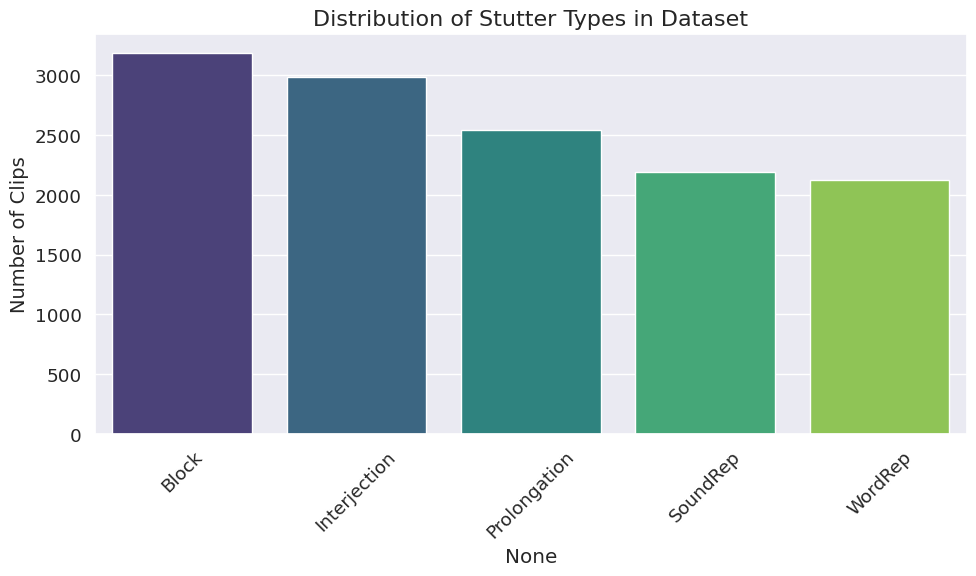

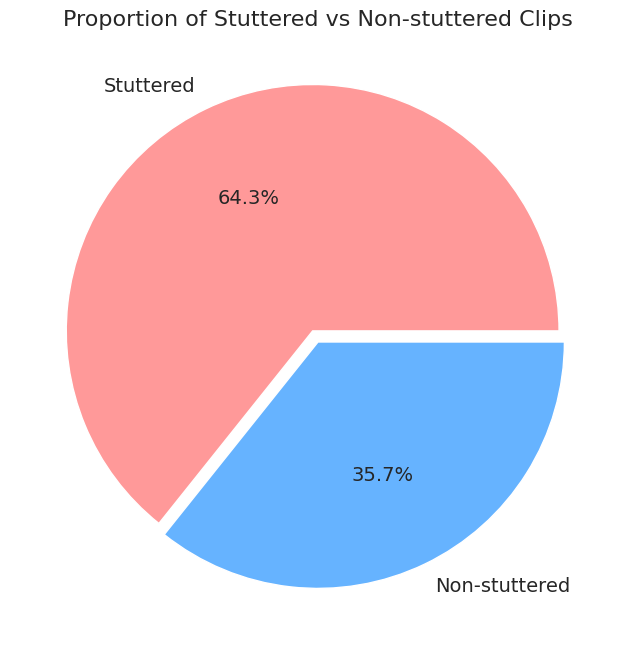

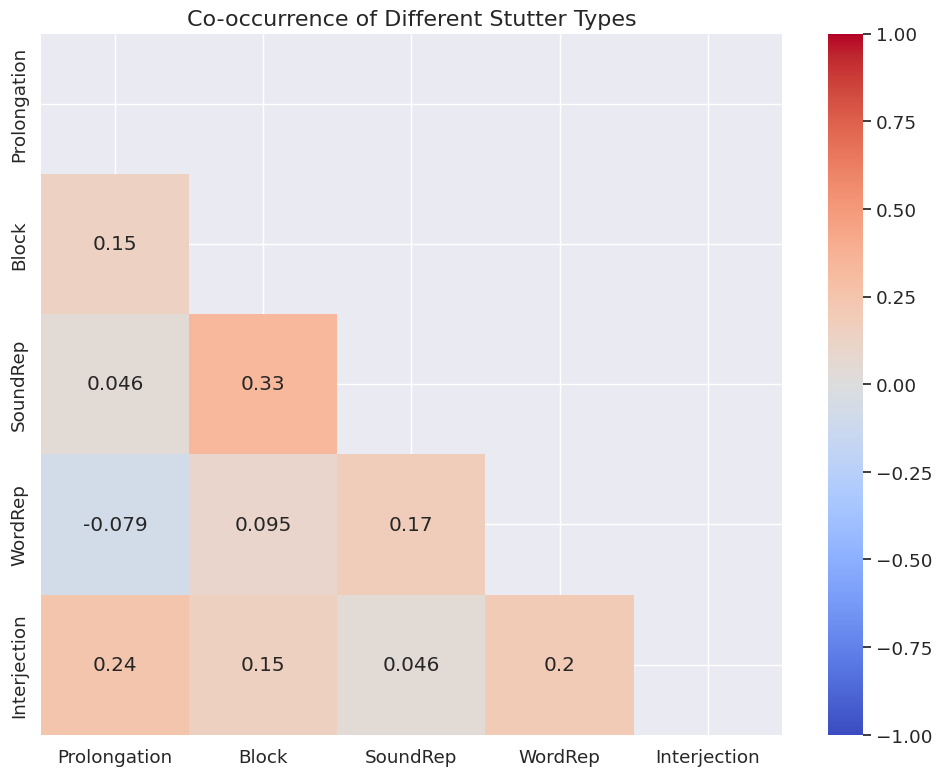

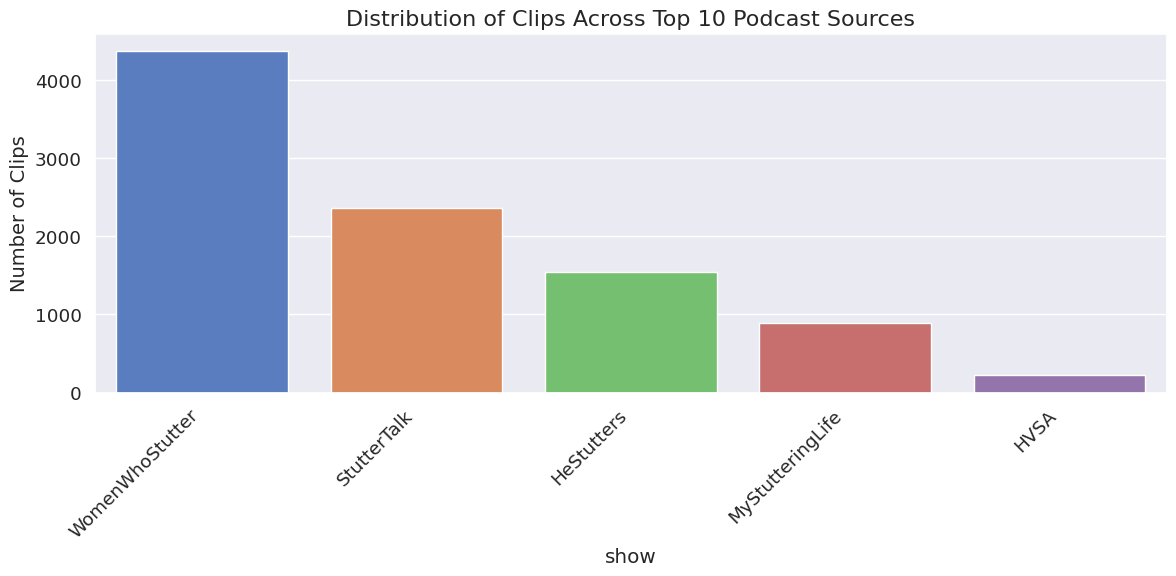

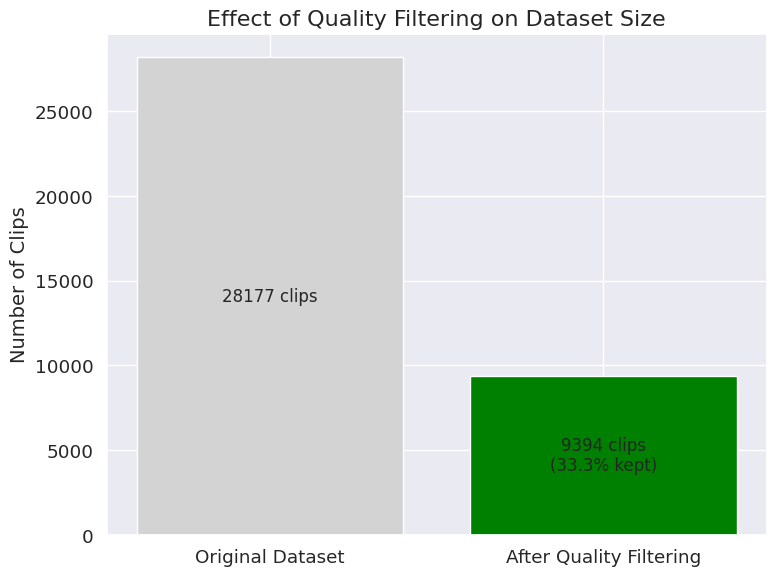

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# 1. Distribution of stutter types
plt.figure(figsize=(10, 6))
stutter_counts = clips_df[STUTTER_TYPES].sum().sort_values(ascending=False)
ax = sns.barplot(x=stutter_counts.index, y=stutter_counts.values, palette='viridis')
plt.title('Distribution of Stutter Types in Dataset', fontsize=16)
plt.ylabel('Number of Clips', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./plots/stutter_types_distribution.png', dpi=300)
plt.show()

# 2. Stutter vs Non-stutter proportion
plt.figure(figsize=(8, 8))
stutter_prop = [
    clips_df['Stutter Word'].sum(),
    clips_df['No Stutter Words'].sum()
]
plt.pie(stutter_prop,
        labels=['Stuttered', 'Non-stuttered'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'],
        explode=(0.05, 0),
        textprops={'fontsize': 14})
plt.title('Proportion of Stuttered vs Non-stuttered Clips', fontsize=16)
plt.savefig('./plots/stutter_proportion.png', dpi=300)
plt.show()

# 3. Co-occurrence of stutter types (heatmap)
plt.figure(figsize=(10, 8))
stutter_corr = clips_df[STUTTER_TYPES].corr()
mask = np.triu(np.ones_like(stutter_corr, dtype=bool))
sns.heatmap(stutter_corr, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Co-occurrence of Different Stutter Types', fontsize=16)
plt.tight_layout()
plt.savefig('./plots/stutter_correlation.png', dpi=300)
plt.show()

# 4. Show distribution by podcast source
plt.figure(figsize=(12, 6))
source_counts = clips_df['show'].value_counts().head(10)
sns.barplot(x=source_counts.index, y=source_counts.values, palette='muted')
plt.title('Distribution of Clips Across Top 10 Podcast Sources', fontsize=16)
plt.ylabel('Number of Clips', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./plots/source_distribution.png', dpi=300)
plt.show()

# 5. Quality filter effectiveness
original_count = len(labels_df)
filtered_count = len(clips_df)
removed_count = original_count - filtered_count

plt.figure(figsize=(8, 6))
plt.bar(['Original Dataset', 'After Quality Filtering'],
        [original_count, filtered_count],
        color=['lightgray', 'green'])
plt.text(0, original_count*0.5, f"{original_count} clips",
         ha='center', va='center', fontsize=12)
plt.text(1, filtered_count*0.5, f"{filtered_count} clips\n({filtered_count/original_count:.1%} kept)",
         ha='center', va='center', fontsize=12)
plt.title('Effect of Quality Filtering on Dataset Size', fontsize=16)
plt.ylabel('Number of Clips', fontsize=14)
plt.tight_layout()
plt.savefig('./plots/quality_filtering.png', dpi=300)
plt.show()


Extracting MFCC features...
Processing batch 1/94 (clips 1-100)


Batch 1: 100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


Processing batch 2/94 (clips 101-200)


Batch 2: 100%|██████████| 100/100 [00:02<00:00, 40.23it/s]


Processing batch 3/94 (clips 201-300)


Batch 3: 100%|██████████| 100/100 [00:02<00:00, 41.73it/s]


Processing batch 4/94 (clips 301-400)


Batch 4: 100%|██████████| 100/100 [00:02<00:00, 37.17it/s]


Processing batch 5/94 (clips 401-500)


Batch 5: 100%|██████████| 100/100 [00:03<00:00, 32.07it/s]


Processing batch 6/94 (clips 501-600)


Batch 6: 100%|██████████| 100/100 [00:02<00:00, 40.91it/s]


Processing batch 7/94 (clips 601-700)


Batch 7: 100%|██████████| 100/100 [00:02<00:00, 42.52it/s]


Processing batch 8/94 (clips 701-800)


Batch 8: 100%|██████████| 100/100 [00:02<00:00, 40.95it/s]


Processing batch 9/94 (clips 801-900)


Batch 9: 100%|██████████| 100/100 [00:02<00:00, 40.57it/s]


Processing batch 10/94 (clips 901-1000)


Batch 10: 100%|██████████| 100/100 [00:02<00:00, 42.52it/s]


Processing batch 11/94 (clips 1001-1100)


Batch 11: 100%|██████████| 100/100 [00:02<00:00, 40.91it/s]


Processing batch 12/94 (clips 1101-1200)


Batch 12: 100%|██████████| 100/100 [00:02<00:00, 39.10it/s]


Processing batch 13/94 (clips 1201-1300)


Batch 13: 100%|██████████| 100/100 [00:02<00:00, 39.14it/s]


Processing batch 14/94 (clips 1301-1400)


Batch 14: 100%|██████████| 100/100 [00:02<00:00, 40.24it/s]


Processing batch 15/94 (clips 1401-1500)


Batch 15: 100%|██████████| 100/100 [00:02<00:00, 40.33it/s]


Processing batch 16/94 (clips 1501-1600)


Batch 16: 100%|██████████| 100/100 [00:02<00:00, 40.44it/s]


Processing batch 17/94 (clips 1601-1700)


Batch 17: 100%|██████████| 100/100 [00:02<00:00, 35.60it/s]


Processing batch 18/94 (clips 1701-1800)


Batch 18: 100%|██████████| 100/100 [00:02<00:00, 41.07it/s]


Processing batch 19/94 (clips 1801-1900)


Batch 19: 100%|██████████| 100/100 [00:02<00:00, 41.05it/s]


Processing batch 20/94 (clips 1901-2000)


Batch 20: 100%|██████████| 100/100 [00:02<00:00, 42.09it/s]


Processing batch 21/94 (clips 2001-2100)


Batch 21: 100%|██████████| 100/100 [00:02<00:00, 41.03it/s]


Processing batch 22/94 (clips 2101-2200)


Batch 22: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


Processing batch 23/94 (clips 2201-2300)


Batch 23: 100%|██████████| 100/100 [00:02<00:00, 41.58it/s]


Processing batch 24/94 (clips 2301-2400)


Batch 24: 100%|██████████| 100/100 [00:02<00:00, 39.90it/s]


Processing batch 25/94 (clips 2401-2500)


Batch 25: 100%|██████████| 100/100 [00:02<00:00, 38.96it/s]


Processing batch 26/94 (clips 2501-2600)


Batch 26: 100%|██████████| 100/100 [00:02<00:00, 41.74it/s]


Processing batch 27/94 (clips 2601-2700)


Batch 27: 100%|██████████| 100/100 [00:02<00:00, 40.28it/s]


Processing batch 28/94 (clips 2701-2800)


Batch 28: 100%|██████████| 100/100 [00:02<00:00, 39.10it/s]


Processing batch 29/94 (clips 2801-2900)


Batch 29: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


Processing batch 30/94 (clips 2901-3000)


Batch 30: 100%|██████████| 100/100 [00:02<00:00, 41.53it/s]


Processing batch 31/94 (clips 3001-3100)


Batch 31: 100%|██████████| 100/100 [00:02<00:00, 40.37it/s]


Processing batch 32/94 (clips 3101-3200)


Batch 32: 100%|██████████| 100/100 [00:02<00:00, 40.14it/s]


Processing batch 33/94 (clips 3201-3300)


Batch 33: 100%|██████████| 100/100 [00:02<00:00, 41.92it/s]


Processing batch 34/94 (clips 3301-3400)


Batch 34: 100%|██████████| 100/100 [00:02<00:00, 40.25it/s]


Processing batch 35/94 (clips 3401-3500)


Batch 35: 100%|██████████| 100/100 [00:02<00:00, 40.21it/s]


Processing batch 36/94 (clips 3501-3600)


Batch 36: 100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


Processing batch 37/94 (clips 3601-3700)


Batch 37: 100%|██████████| 100/100 [00:02<00:00, 40.52it/s]


Processing batch 38/94 (clips 3701-3800)


Batch 38: 100%|██████████| 100/100 [00:02<00:00, 40.49it/s]


Processing batch 39/94 (clips 3801-3900)


Batch 39: 100%|██████████| 100/100 [00:02<00:00, 40.21it/s]


Processing batch 40/94 (clips 3901-4000)


Batch 40: 100%|██████████| 100/100 [00:02<00:00, 40.28it/s]


Processing batch 41/94 (clips 4001-4100)


Batch 41: 100%|██████████| 100/100 [00:02<00:00, 42.08it/s]


Processing batch 42/94 (clips 4101-4200)


Batch 42: 100%|██████████| 100/100 [00:02<00:00, 41.71it/s]


Processing batch 43/94 (clips 4201-4300)


Batch 43: 100%|██████████| 100/100 [00:02<00:00, 42.30it/s]


Processing batch 44/94 (clips 4301-4400)


Batch 44: 100%|██████████| 100/100 [00:02<00:00, 38.52it/s]


Processing batch 45/94 (clips 4401-4500)


Batch 45: 100%|██████████| 100/100 [00:02<00:00, 42.12it/s]


Processing batch 46/94 (clips 4501-4600)


Batch 46: 100%|██████████| 100/100 [00:02<00:00, 41.87it/s]


Processing batch 47/94 (clips 4601-4700)


Batch 47: 100%|██████████| 100/100 [00:02<00:00, 41.55it/s]


Processing batch 48/94 (clips 4701-4800)


Batch 48: 100%|██████████| 100/100 [00:02<00:00, 38.92it/s]


Processing batch 49/94 (clips 4801-4900)


Batch 49: 100%|██████████| 100/100 [00:02<00:00, 40.12it/s]


Processing batch 50/94 (clips 4901-5000)


Batch 50: 100%|██████████| 100/100 [00:02<00:00, 41.72it/s]


Processing batch 51/94 (clips 5001-5100)


Batch 51: 100%|██████████| 100/100 [00:02<00:00, 42.11it/s]


Processing batch 52/94 (clips 5101-5200)


Batch 52: 100%|██████████| 100/100 [00:02<00:00, 40.03it/s]


Processing batch 53/94 (clips 5201-5300)


Batch 53: 100%|██████████| 100/100 [00:02<00:00, 41.78it/s]


Processing batch 54/94 (clips 5301-5400)


Batch 54: 100%|██████████| 100/100 [00:02<00:00, 40.34it/s]


Processing batch 55/94 (clips 5401-5500)


Batch 55: 100%|██████████| 100/100 [00:02<00:00, 39.86it/s]


Processing batch 56/94 (clips 5501-5600)


Batch 56: 100%|██████████| 100/100 [00:02<00:00, 40.55it/s]


Processing batch 57/94 (clips 5601-5700)


Batch 57: 100%|██████████| 100/100 [00:02<00:00, 41.64it/s]


Processing batch 58/94 (clips 5701-5800)


Batch 58: 100%|██████████| 100/100 [00:02<00:00, 40.31it/s]


Processing batch 59/94 (clips 5801-5900)


Batch 59: 100%|██████████| 100/100 [00:02<00:00, 40.10it/s]


Processing batch 60/94 (clips 5901-6000)


Batch 60: 100%|██████████| 100/100 [00:02<00:00, 40.80it/s]


Processing batch 61/94 (clips 6001-6100)


Batch 61: 100%|██████████| 100/100 [00:02<00:00, 41.81it/s]


Processing batch 62/94 (clips 6101-6200)


Batch 62: 100%|██████████| 100/100 [00:02<00:00, 38.85it/s]


Processing batch 63/94 (clips 6201-6300)


Batch 63: 100%|██████████| 100/100 [00:02<00:00, 39.92it/s]


Processing batch 64/94 (clips 6301-6400)


Batch 64: 100%|██████████| 100/100 [00:02<00:00, 42.13it/s]


Processing batch 65/94 (clips 6401-6500)


Batch 65: 100%|██████████| 100/100 [00:02<00:00, 40.52it/s]


Processing batch 66/94 (clips 6501-6600)


Batch 66: 100%|██████████| 100/100 [00:02<00:00, 41.94it/s]


Processing batch 67/94 (clips 6601-6700)


Batch 67: 100%|██████████| 100/100 [00:02<00:00, 38.82it/s]


Processing batch 68/94 (clips 6701-6800)


Batch 68: 100%|██████████| 100/100 [00:02<00:00, 40.01it/s]


Processing batch 69/94 (clips 6801-6900)


Batch 69: 100%|██████████| 100/100 [00:02<00:00, 40.49it/s]


Processing batch 70/94 (clips 6901-7000)


Batch 70: 100%|██████████| 100/100 [00:02<00:00, 41.55it/s]


Processing batch 71/94 (clips 7001-7100)


Batch 71: 100%|██████████| 100/100 [00:02<00:00, 40.44it/s]


Processing batch 72/94 (clips 7101-7200)


Batch 72: 100%|██████████| 100/100 [00:02<00:00, 40.48it/s]


Processing batch 73/94 (clips 7201-7300)


Batch 73: 100%|██████████| 100/100 [00:02<00:00, 41.69it/s]


Processing batch 74/94 (clips 7301-7400)


Batch 74: 100%|██████████| 100/100 [00:02<00:00, 42.06it/s]


Processing batch 75/94 (clips 7401-7500)


Batch 75: 100%|██████████| 100/100 [00:02<00:00, 40.26it/s]


Processing batch 76/94 (clips 7501-7600)


Batch 76: 100%|██████████| 100/100 [00:02<00:00, 41.83it/s]


Processing batch 77/94 (clips 7601-7700)


Batch 77: 100%|██████████| 100/100 [00:02<00:00, 41.63it/s]


Processing batch 78/94 (clips 7701-7800)


Batch 78: 100%|██████████| 100/100 [00:02<00:00, 41.71it/s]


Processing batch 79/94 (clips 7801-7900)


Batch 79: 100%|██████████| 100/100 [00:02<00:00, 38.69it/s]


Processing batch 80/94 (clips 7901-8000)


Batch 80: 100%|██████████| 100/100 [00:02<00:00, 41.67it/s]


Processing batch 81/94 (clips 8001-8100)


Batch 81: 100%|██████████| 100/100 [00:02<00:00, 43.77it/s]


Processing batch 82/94 (clips 8101-8200)


Batch 82: 100%|██████████| 100/100 [00:02<00:00, 41.95it/s]


Processing batch 83/94 (clips 8201-8300)


Batch 83: 100%|██████████| 100/100 [00:02<00:00, 40.26it/s]


Processing batch 84/94 (clips 8301-8400)


Batch 84: 100%|██████████| 100/100 [00:02<00:00, 43.61it/s]


Processing batch 85/94 (clips 8401-8500)


Batch 85: 100%|██████████| 100/100 [00:02<00:00, 43.69it/s]


Processing batch 86/94 (clips 8501-8600)


Batch 86: 100%|██████████| 100/100 [00:02<00:00, 42.01it/s]


Processing batch 87/94 (clips 8601-8700)


Batch 87: 100%|██████████| 100/100 [00:02<00:00, 40.07it/s]


Processing batch 88/94 (clips 8701-8800)


Batch 88: 100%|██████████| 100/100 [00:02<00:00, 41.86it/s]


Processing batch 89/94 (clips 8801-8900)


Batch 89: 100%|██████████| 100/100 [00:02<00:00, 41.67it/s]


Processing batch 90/94 (clips 8901-9000)


Batch 90: 100%|██████████| 100/100 [00:02<00:00, 42.12it/s]


Processing batch 91/94 (clips 9001-9100)


Batch 91: 100%|██████████| 100/100 [00:02<00:00, 38.76it/s]


Processing batch 92/94 (clips 9101-9200)


Batch 92: 100%|██████████| 100/100 [00:02<00:00, 41.62it/s]


Processing batch 93/94 (clips 9201-9300)


Batch 93: 100%|██████████| 100/100 [00:02<00:00, 42.01it/s]


Processing batch 94/94 (clips 9301-9394)


Batch 94: 100%|██████████| 94/94 [00:02<00:00, 43.15it/s]


Saving extracted features...
Preparing train/val/test datasets...
Training set: 6786 samples
Validation set: 1198 samples
Testing set: 1410 samples
Features: 80
Class distribution in training set: [2424 4362]
Class distribution in validation set: [428 770]
Class distribution in testing set: [504 906]
Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,633 (84.50 KB)

 Trainable params: 21,185 (82.75 KB)

 Non-trainable params: 448 (1.75 KB)

Training model...
Training model...
Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4900 - auc: 0.4944 - loss: 0.8523 - precision: 0.6330 - recall: 0.4802 - val_accuracy: 0.5017 - val_auc: 0.5749 - val_loss: 0.7081 - val_precision: 0.7247 - val_recall: 0.3623 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5216 - auc: 0.5396 - loss: 0.7337 - precision: 0.6627 - recall: 0.5164 - val_accuracy: 0.5234 - val_auc: 0.5988 - val_loss: 0.6981 - val_precision: 0.7457 - val_recall: 0.3922 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5528 - auc: 0.5807 - loss: 0.7020 - precision: 0.6963 - recall: 0.5272 - val_accuracy: 0.5309 - val_auc: 0.6125 - val_loss: 0.6918 - val_precision: 0.7537 - val_recall: 0.4013 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5584 - auc: 0.5876 - loss: 0.6875 - precision: 0.7054 - recall: 0.5410 - val_accuracy: 0.5242 - 

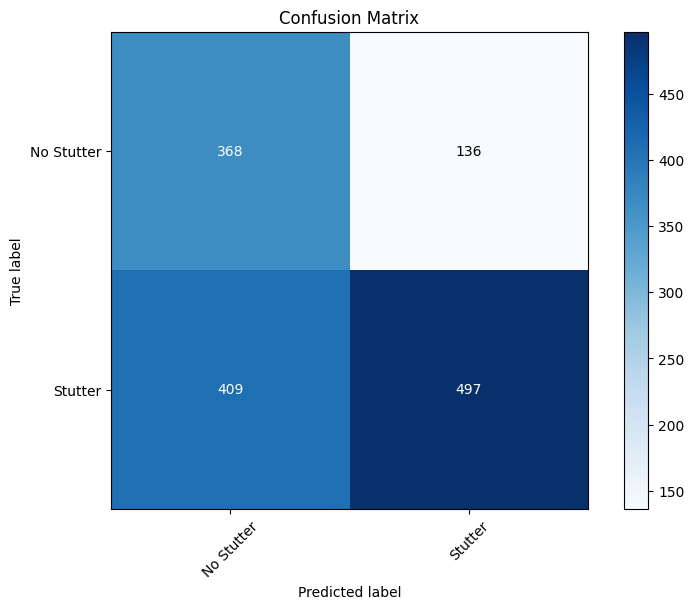


Classification Report:
              precision    recall  f1-score   support

  No Stutter       0.47      0.73      0.57       504
     Stutter       0.79      0.55      0.65       906

    accuracy                           0.61      1410
   macro avg       0.63      0.64      0.61      1410
weighted avg       0.67      0.61      0.62      1410

Plotting training history...
Available history keys: ['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate']


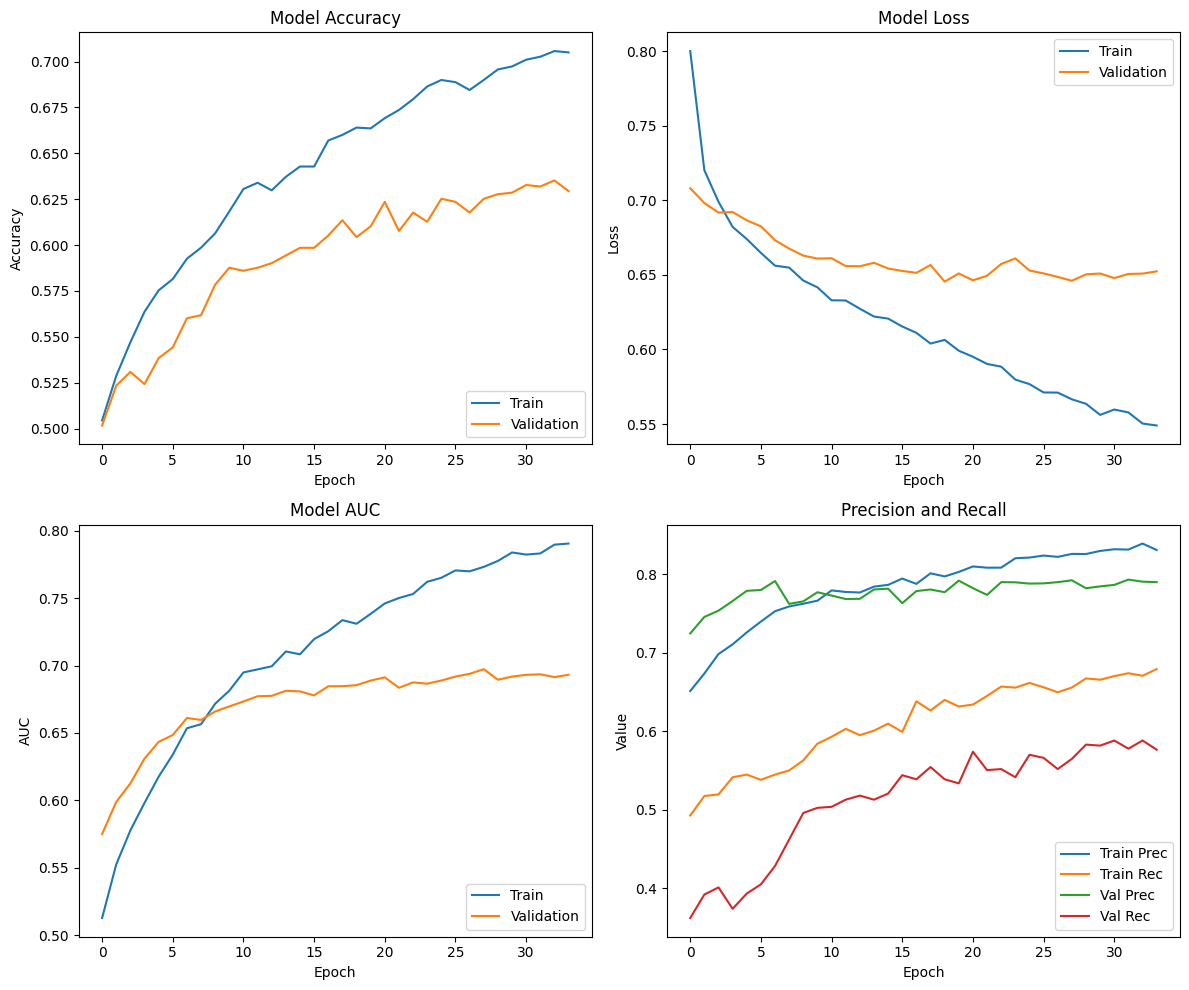

Analyzing feature importance...


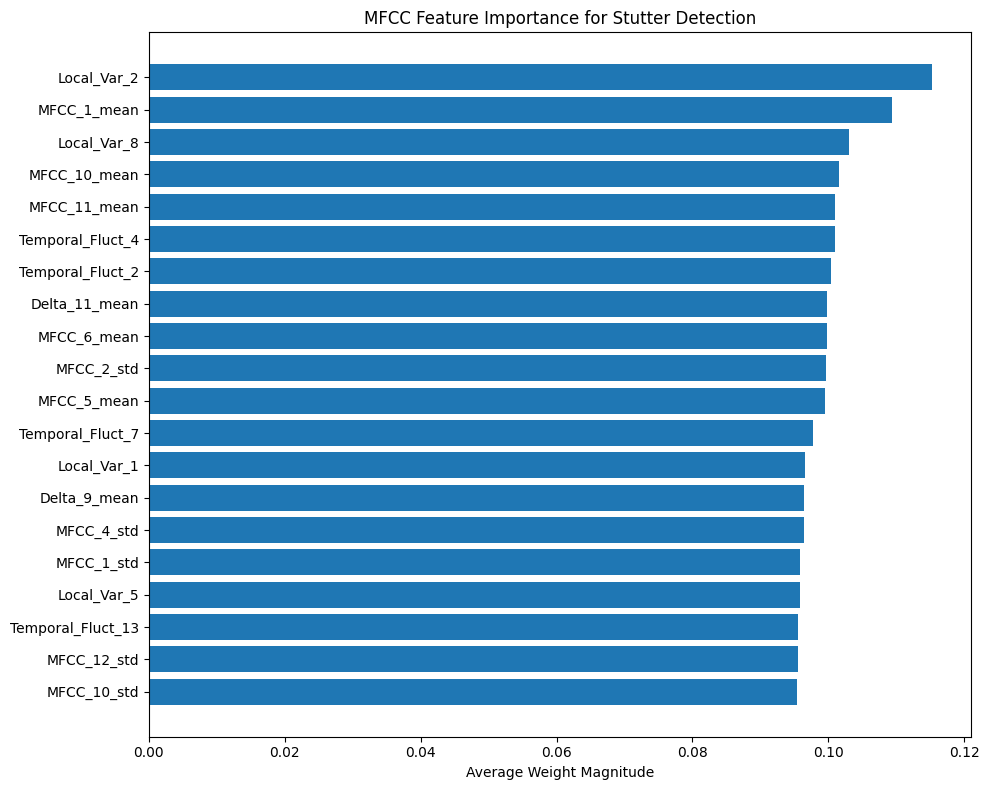


Top 10 MFCC Features for Stutter Detection:
Local_Var_2: 0.1152
MFCC_1_mean: 0.1093
Local_Var_8: 0.1031
MFCC_10_mean: 0.1016
MFCC_11_mean: 0.1009
Temporal_Fluct_4: 0.1009
Temporal_Fluct_2: 0.1004
Delta_11_mean: 0.0998
MFCC_6_mean: 0.0998
MFCC_2_std: 0.0997
Saving model...
MFCC-based stutter classification pipeline completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import warnings
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc  # Garbage collector
import IPython.display as ipd
import traceback

# Suppress warnings
warnings.filterwarnings('ignore')

def extract_mfcc_features(audio_path, sr=16000, n_mfcc=13, visualize=False):
    """
    Enhanced MFCC feature extraction with optimized parameters for stutter detection

    Parameters:
        audio_path (str): Path to the audio file
        sr (int): Sampling rate
        n_mfcc (int): Number of MFCC coefficients to extract
        visualize (bool): Whether to visualize the features

    Returns:
        dict: Dictionary containing MFCC features and statistics optimized for stutter detection
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr)

        # Apply pre-emphasis filter (standard in speech processing)
        y = librosa.effects.preemphasis(y, coef=0.97)

        # Extract MFCCs with optimized parameters for stuttering detection
        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=n_mfcc,
            n_fft=int(0.025*sr),    # 25ms window
            hop_length=int(0.010*sr), # 10ms hop
            lifter=22               # Emphasize lower-order coefficients
        )

        # Normalize MFCCs (important for stutter pattern recognition)
        mfcc = librosa.util.normalize(mfcc, axis=1)

        # Compute delta and delta-delta features (higher orders capture transitions)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

        # Compute temporal dynamics statistics (stutter correlates)
        temporal_fluctuation = np.std(np.diff(mfcc, axis=1), axis=1)

        # Calculate local variability (rapid changes indicate stutter)
        local_variability = []
        for i in range(mfcc.shape[0]):
            # Use rolling window of 5 frames (50ms)
            rolled = np.lib.stride_tricks.sliding_window_view(mfcc[i], 5)
            local_var = np.mean(np.var(rolled, axis=1))
            local_variability.append(local_var)

        # Create feature dictionary
        features = {
            'raw_audio': y,
            'sr': sr,
            'mfcc_raw': mfcc,
            'delta_raw': delta_mfcc,
            'delta2_raw': delta2_mfcc,
            'mfcc_mean': np.mean(mfcc, axis=1),
            'mfcc_std': np.std(mfcc, axis=1),
            'delta_mean': np.mean(delta_mfcc, axis=1),
            'delta_std': np.std(delta_mfcc, axis=1),
            'delta2_mean': np.mean(delta2_mfcc, axis=1),
            'delta2_std': np.std(delta2_mfcc, axis=1),
            'temporal_fluctuation': temporal_fluctuation,
            'local_variability': np.array(local_variability)
        }

        # Calculate transition metrics (repetition indicators)
        features['transition_rate'] = np.mean(np.abs(np.diff(mfcc, axis=1)))
        features['mfcc_stability'] = np.mean(temporal_fluctuation)

        # Visualize if requested
        if visualize:
            plt.figure(figsize=(14, 12))

            # Play audio
            print("Playing audio clip...")
            ipd.display(ipd.Audio(y, rate=sr))

            # Plot waveform
            plt.subplot(5, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title('Waveform')

            # Plot MFCC
            plt.subplot(5, 1, 2)
            librosa.display.specshow(mfcc, sr=sr, x_axis='time')
            plt.colorbar(format='%+2.0f')
            plt.title('MFCC Features')

            # Plot Delta MFCC
            plt.subplot(5, 1, 3)
            librosa.display.specshow(delta_mfcc, sr=sr, x_axis='time')
            plt.colorbar(format='%+2.0f')
            plt.title('Delta MFCC (Transitions)')

            # Plot temporal fluctuation (useful for spotting repetitions)
            plt.subplot(5, 1, 4)
            plt.bar(range(len(temporal_fluctuation)), temporal_fluctuation)
            plt.title('Temporal Fluctuation by Coefficient')
            plt.xlabel('MFCC Coefficient')
            plt.ylabel('Fluctuation')

            # Plot local variability
            plt.subplot(5, 1, 5)
            plt.bar(range(len(local_variability)), local_variability)
            plt.title('Local Variability (Stutter Indicator)')
            plt.xlabel('MFCC Coefficient')
            plt.ylabel('Variability')

            plt.tight_layout()
            plt.show()

            # Print key statistics
            print("\nMFCC Statistics for Stutter Detection:")
            print(f"Overall MFCC Stability: {features['mfcc_stability']:.4f}")
            print(f"Transition Rate: {features['transition_rate']:.4f}")
            print("\nIndividual Coefficients:")
            for i in range(n_mfcc):
                print(f"MFCC {i+1}: Mean = {features['mfcc_mean'][i]:.4f}, "
                      f"Std = {features['mfcc_std'][i]:.4f}, "
                      f"Fluctuation = {temporal_fluctuation[i]:.4f}")

        return features

    except Exception as e:
        print(f"Error extracting MFCC features: {str(e)}")
        traceback.print_exc()
        return None

def extract_mfcc_feature_vector(audio_path, sr=16000, n_mfcc=13):
    """
    Extract a flat feature vector from MFCC features for model input
    """
    try:
        # Extract MFCC features
        features = extract_mfcc_features(audio_path, sr=sr, n_mfcc=n_mfcc, visualize=False)

        if features is None:
            return None

        # Create feature vector suitable for model input
        feature_vector = np.concatenate([
            features['mfcc_mean'],
            features['mfcc_std'],
            features['delta_mean'],
            features['delta2_mean'],
            features['temporal_fluctuation'],
            features['local_variability'],
            [features['transition_rate']],
            [features['mfcc_stability']]
        ])

        return feature_vector

    except Exception as e:
        print(f"Error extracting feature vector from {audio_path}: {str(e)}")
        return None

def batch_process_clips(clips_df, batch_size=100, n_mfcc=13):
    """Process clips in batches to avoid memory issues"""
    all_features = []
    all_labels = []

    total_batches = len(clips_df) // batch_size + (1 if len(clips_df) % batch_size > 0 else 0)

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(clips_df))

        batch_df = clips_df.iloc[start_idx:end_idx]

        print(f"Processing batch {batch_idx+1}/{total_batches} (clips {start_idx+1}-{end_idx})")

        # Extract features for this batch
        batch_results = []
        for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx+1}"):
            feature_vector = extract_mfcc_feature_vector(row['file_path'], n_mfcc=n_mfcc)
            if feature_vector is not None:
                batch_results.append((feature_vector, row['Stutter Word']))

        # Add valid results to our lists
        for features, label in batch_results:
            all_features.append(features)
            all_labels.append(label)

        # Force garbage collection to free memory
        gc.collect()

    if len(all_features) == 0:
        raise ValueError("No valid features extracted. Check your audio files and paths.")

    # Convert features to arrays
    features_array = np.array(all_features)
    labels = np.array(all_labels)

    return features_array, labels

def prepare_dataset(features_array, labels):
    """Prepare train/val/test datasets with proper scaling"""
    # First split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        features_array, labels, test_size=0.15, random_state=42, stratify=labels
    )

    # Then split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )

    # Standardize features based on training set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")

    # Print class distribution
    print(f"Class distribution in training set: {np.bincount(y_train)}")
    print(f"Class distribution in validation set: {np.bincount(y_val)}")
    print(f"Class distribution in testing set: {np.bincount(y_test)}")

    # Save scaler for future use
    from joblib import dump
    dump(scaler, 'mfcc_feature_scaler.joblib')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def build_model(input_shape):
    """Build DNN model for stutter detection using MFCC features"""
    model = Sequential([
        # Input layer - adapted for MFCC features which typically have higher dimensionality
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),

        # Hidden layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile model with explicitly named metrics
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    # Show model summary
    model.summary()

    return model

def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with early stopping and LR reduction"""
    # Calculate class weights for imbalanced dataset
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    print("Evaluating model on test set...")
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Stutter', 'Stutter'], rotation=45)
    plt.yticks(tick_marks, ['No Stutter', 'Stutter'])

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Stutter', 'Stutter']))

    return y_pred

def plot_training_history(history):
    """Plot training metrics"""
    # First, print available keys to debug
    print("Available history keys:", list(history.history.keys()))

    plt.figure(figsize=(12, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot Precision/Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['precision'])
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_precision'])
    plt.plot(history.history['val_recall'])
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(['Train Prec', 'Train Rec', 'Val Prec', 'Val Rec'], loc='lower right')

    plt.tight_layout()
    plt.show()

def analyze_feature_importance(model, feature_names):
    """Analyze which MFCC features are most important for stutter detection"""
    # For a DNN, we can examine the weights of the first layer
    weights = model.layers[0].get_weights()[0]

    # Calculate average absolute weight for each feature
    importance = np.mean(np.abs(weights), axis=1)

    # Pair feature names with their importance
    feature_importance = list(zip(feature_names, importance))

    # Sort by importance (descending)
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    features, importance = zip(*feature_importance[:20])  # Top 20 features
    plt.barh(features, importance)
    plt.xlabel('Average Weight Magnitude')
    plt.title('MFCC Feature Importance for Stutter Detection')
    plt.gca().invert_yaxis()  # Display most important at the top
    plt.tight_layout()
    plt.show()

    print("\nTop 10 MFCC Features for Stutter Detection:")
    for feature, imp in feature_importance[:10]:
        print(f"{feature}: {imp:.4f}")

    return feature_importance

def run_mfcc_stutter_classification(clips_df, n_mfcc=13):
    """End-to-end MFCC-based stutter classification pipeline"""
    # Check if cached features exist
    if os.path.exists('mfcc_features.npy') and os.path.exists('mfcc_labels.npy'):
        print("Loading pre-extracted features...")
        features_array = np.load('mfcc_features.npy')
        labels = np.load('mfcc_labels.npy')
    else:
        # 1. Extract features
        print("Extracting MFCC features...")
        features_array, labels = batch_process_clips(clips_df, n_mfcc=n_mfcc)

        # Save extracted features to avoid reprocessing
        print("Saving extracted features...")
        np.save('mfcc_features.npy', features_array)
        np.save('mfcc_labels.npy', labels)

    # 2. Prepare datasets
    print("Preparing train/val/test datasets...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_array, labels)

    # 3. Build model
    print("Building model...")
    model = build_model(X_train.shape[1])

    # 4. Train model
    print("Training model...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)

    # 5. Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X_test, y_test)

    # 6. Plot training history
    print("Plotting training history...")
    plot_training_history(history)

    # 7. Analyze feature importance
    print("Analyzing feature importance...")
    # Create feature names
    feature_names = []
    for i in range(n_mfcc):
        feature_names.append(f"MFCC_{i+1}_mean")
    for i in range(n_mfcc):
        feature_names.append(f"MFCC_{i+1}_std")
    for i in range(n_mfcc):
        feature_names.append(f"Delta_{i+1}_mean")
    for i in range(n_mfcc):
        feature_names.append(f"Delta2_{i+1}_mean")
    for i in range(n_mfcc):
        feature_names.append(f"Temporal_Fluct_{i+1}")
    for i in range(n_mfcc):
        feature_names.append(f"Local_Var_{i+1}")
    feature_names.append("Transition_Rate")
    feature_names.append("MFCC_Stability")

    analyze_feature_importance(model, feature_names)

    # 8. Save model
    print("Saving model...")
    model.save('mfcc_stutter_detection_model.h5')

    return model, features_array

# Function to test a single clip
def test_single_clip(clip_path, model, scaler, n_mfcc=13):
    """Test the model on a single clip"""
    print(f"Testing clip: {clip_path}")

    # Extract features
    features = extract_mfcc_features(clip_path, n_mfcc=n_mfcc, visualize=True)

    if features is None:
        print("Failed to extract features from the clip")
        return

    # Create feature vector
    feature_vector = np.concatenate([
        features['mfcc_mean'],
        features['mfcc_std'],
        features['delta_mean'],
        features['delta2_mean'],
        features['temporal_fluctuation'],
        features['local_variability'],
        [features['transition_rate']],
        [features['mfcc_stability']]
    ])

    # Scale features
    feature_vector_scaled = scaler.transform(feature_vector.reshape(1, -1))

    # Predict
    pred_prob = model.predict(feature_vector_scaled)[0][0]
    prediction = "Stutter" if pred_prob > 0.5 else "No Stutter"

    print(f"\nPrediction: {prediction} (Confidence: {pred_prob:.2f})")
    print("Stutter indicators:")
    print(f"- MFCC Stability: {features['mfcc_stability']:.4f} (Lower values suggest more stuttering)")
    print(f"- Transition Rate: {features['transition_rate']:.4f} (Higher values suggest more stuttering)")

    return prediction, pred_prob

# Run the pipeline
try:
    # Check if model already exists
    if os.path.exists('mfcc_stutter_detection_model.h5') and os.path.exists('mfcc_feature_scaler.joblib'):
        print("Loading existing model and scaler...")
        from tensorflow.keras.models import load_model
        from joblib import load
        model = load_model('mfcc_stutter_detection_model.h5')
        scaler = load('mfcc_feature_scaler.joblib')

        # Ask if user wants to test a single clip
        test_clip = input("Do you want to test a single clip? (y/n): ")
        if test_clip.lower() == 'y':
            clip_path = input("Enter the path to the audio clip: ")
            test_single_clip(clip_path, model, scaler)
    else:
        model, features_array = run_mfcc_stutter_classification(clips_df)
        print("MFCC-based stutter classification pipeline completed successfully!")

except Exception as e:
    print(f"Error in MFCC-based stutter classification pipeline: {str(e)}")
    traceback.print_exc()


Extracting prosodic features...
Processing batch 1/20 (clips 1-500)


Batch 1: 100%|██████████| 500/500 [05:54<00:00,  1.41it/s]


Processing batch 2/20 (clips 501-1000)


Batch 2: 100%|██████████| 500/500 [05:44<00:00,  1.45it/s]


Processing batch 3/20 (clips 1001-1500)


Batch 3: 100%|██████████| 500/500 [05:05<00:00,  1.64it/s]


Processing batch 4/20 (clips 1501-2000)


Batch 4: 100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


Processing batch 5/20 (clips 2001-2500)


Batch 5: 100%|██████████| 500/500 [04:21<00:00,  1.91it/s]


Processing batch 6/20 (clips 2501-3000)


Batch 6: 100%|██████████| 500/500 [04:21<00:00,  1.91it/s]


Processing batch 7/20 (clips 3001-3500)


Batch 7: 100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


Processing batch 8/20 (clips 3501-4000)


Batch 8: 100%|██████████| 500/500 [04:32<00:00,  1.83it/s]


Processing batch 9/20 (clips 4001-4500)


Batch 9: 100%|██████████| 500/500 [04:47<00:00,  1.74it/s]


Processing batch 10/20 (clips 4501-5000)


Batch 10: 100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


Processing batch 11/20 (clips 5001-5500)


Batch 11: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


Processing batch 12/20 (clips 5501-6000)


Batch 12: 100%|██████████| 500/500 [04:21<00:00,  1.91it/s]


Processing batch 13/20 (clips 6001-6500)


Batch 13: 100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


Processing batch 14/20 (clips 6501-7000)


Batch 14: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]


Processing batch 15/20 (clips 7001-7500)


Batch 15: 100%|██████████| 500/500 [04:18<00:00,  1.93it/s]


Processing batch 16/20 (clips 7501-8000)


Batch 16: 100%|██████████| 500/500 [04:14<00:00,  1.97it/s]


Processing batch 17/20 (clips 8001-8500)


Batch 17: 100%|██████████| 500/500 [04:15<00:00,  1.95it/s]


Processing batch 18/20 (clips 8501-9000)


Batch 18: 100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


Processing batch 19/20 (clips 9001-9500)


Batch 19: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


Processing batch 20/20 (clips 9501-9751)


Batch 20: 100%|██████████| 251/251 [02:10<00:00,  1.92it/s]


Saving extracted features...
Preparing train/val/test datasets...
Training set: 7044 samples
Validation set: 1244 samples
Testing set: 1463 samples
Features: 13
Class distribution in training set: [2477 4567]
Class distribution in validation set: [438 806]
Class distribution in testing set: [514 949]
Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,969 (15.50 KB)

 Trainable params: 3,745 (14.63 KB)

 Non-trainable params: 224 (896.00 B)

Training model...
Training model...
Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.5046 - auc: 0.5185 - loss: 0.8240 - precision: 0.6609 - recall: 0.4798 - val_accuracy: 0.4839 - val_auc: 0.5534 - val_loss: 0.7089 - val_precision: 0.6898 - val_recall: 0.3697 - learning_rate: 0.0010
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5247 - auc: 0.5458 - loss: 0.7296 - precision: 0.6751 - recall: 0.5151 - val_accuracy: 0.5129 - val_auc: 0.5604 - val_loss: 0.6988 - val_precision: 0.7066 - val_recall: 0.4243 - learning_rate: 0.0010
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5357 - auc: 0.5587 - loss: 0.7157 - precision: 0.6896 - recall: 0.4996 - val_accuracy: 0.5193 - val_auc: 0.5690 - val_loss: 0.6928 - val_precision: 0.7000 - val_recall: 0.4516 - learning_rate: 0.0010
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5401 - auc: 0.5769 - loss: 0.6891 - precision: 0.6955 - recall: 0.5223 - val_accuracy: 0.5241 

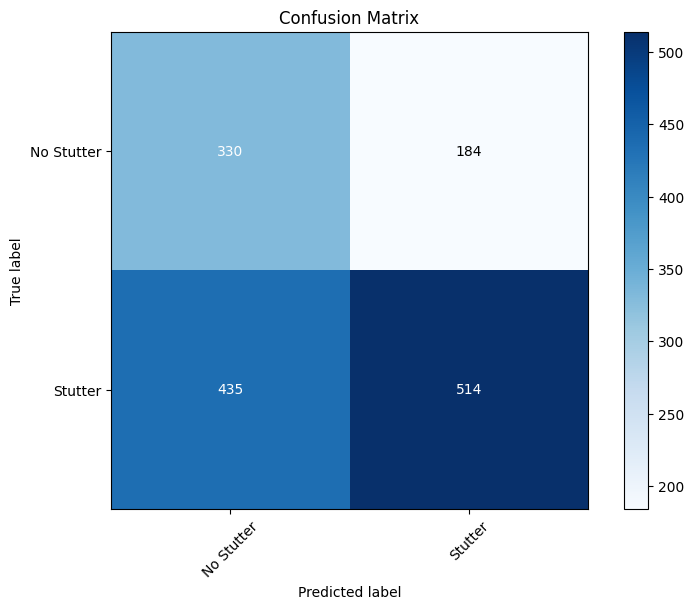


Classification Report:
              precision    recall  f1-score   support

  No Stutter       0.43      0.64      0.52       514
     Stutter       0.74      0.54      0.62       949

    accuracy                           0.58      1463
   macro avg       0.58      0.59      0.57      1463
weighted avg       0.63      0.58      0.59      1463

Plotting training history...


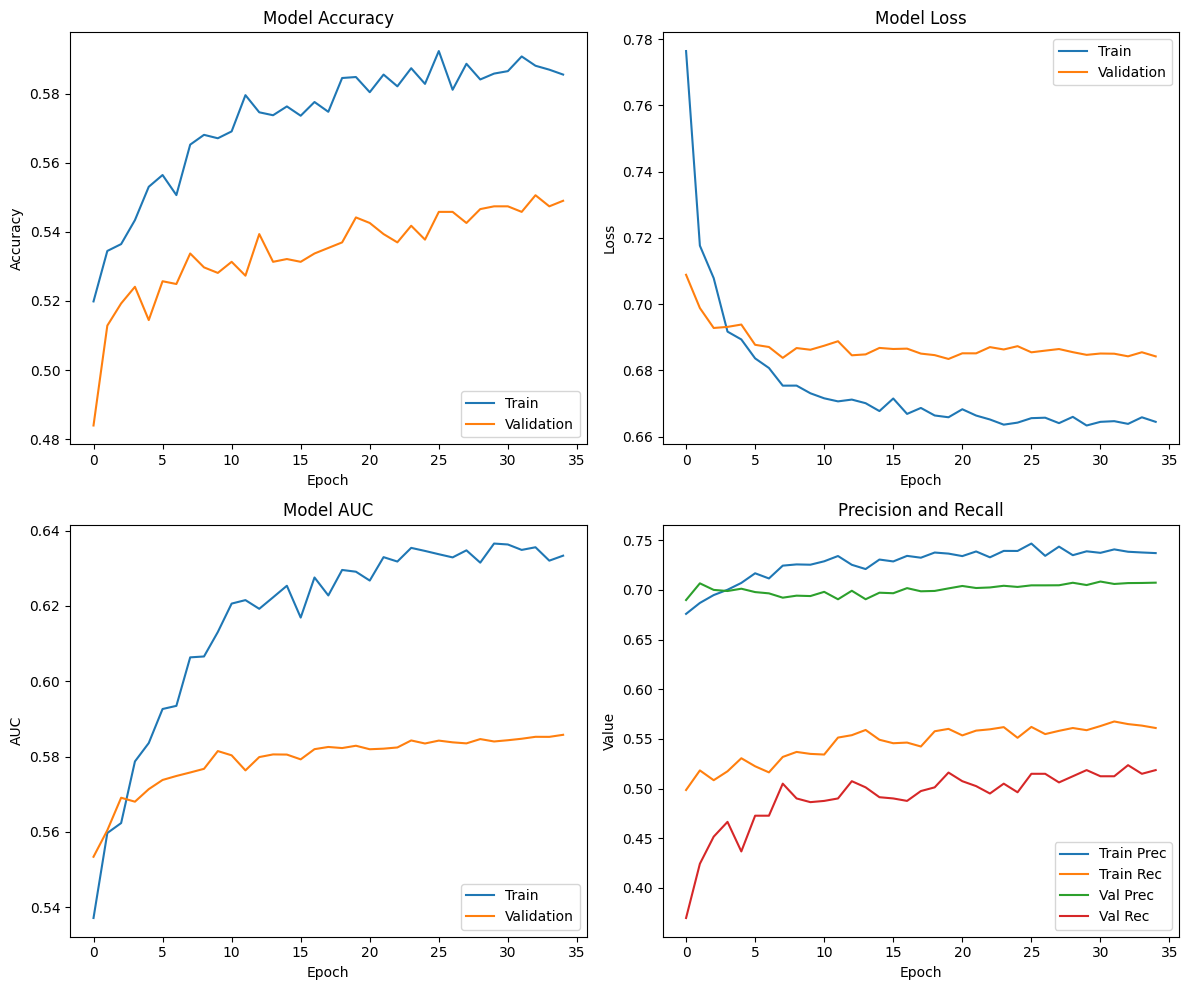

Analyzing feature importance...


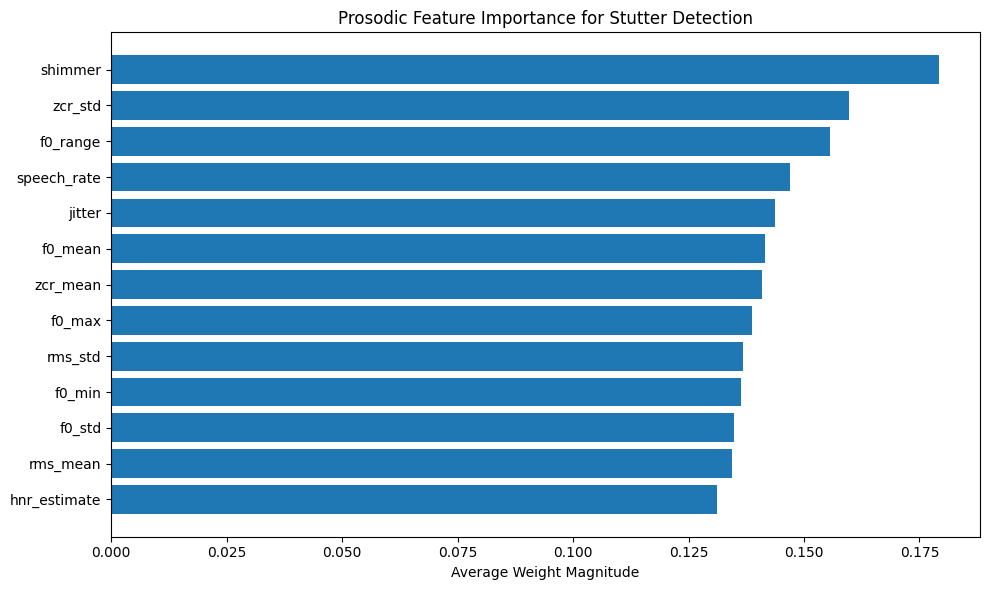


Feature Importance Ranking:
shimmer: 0.1791
zcr_std: 0.1598
f0_range: 0.1556
speech_rate: 0.1469
jitter: 0.1438
f0_mean: 0.1415
zcr_mean: 0.1408
f0_max: 0.1388
rms_std: 0.1368
f0_min: 0.1363
f0_std: 0.1348
rms_mean: 0.1343
hnr_estimate: 0.1311
Saving model...
Stutter classification pipeline completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import warnings
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc  # Garbage collector

# Suppress warnings
warnings.filterwarnings('ignore')

def extract_prosodic_features(audio_path, sr=16000):
    """
    Extract prosodic features with robust error handling
    """
    try:
        # Load audio file with error checking
        try:
            y, sr = librosa.load(audio_path, sr=sr)
            # Check if audio is valid
            if len(y) == 0 or np.isnan(y).any() or np.isinf(y).any():
                print(f"Invalid audio in {audio_path}: empty or contains invalid values")
                return None
        except Exception as e:
            print(f"Error loading {audio_path}: {str(e)}")
            return None

        # Apply pre-emphasis filter
        y = librosa.effects.preemphasis(y, coef=0.97)

        # Initialize feature dictionary with default values
        features = {
            'f0_mean': 0, 'f0_std': 0, 'f0_min': 0, 'f0_max': 0, 'f0_range': 0,
            'rms_mean': 0, 'rms_std': 0, 'zcr_mean': 0, 'zcr_std': 0,
            'speech_rate': 0, 'jitter': 0, 'shimmer': 0, 'hnr_estimate': -60
        }

        # Extract pitch (F0) using pYIN algorithm with error handling
        try:
            f0, voiced_flag, _ = librosa.pyin(
                y, fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C7'), sr=sr
            )

            # Handle NaN values in f0
            f0_valid = f0[~np.isnan(f0)] if len(f0[~np.isnan(f0)]) > 0 else np.array([0])

            if len(f0_valid) > 0:
                features['f0_mean'] = float(np.mean(f0_valid))
                features['f0_std'] = float(np.std(f0_valid))
                features['f0_min'] = float(np.min(f0_valid))
                features['f0_max'] = float(np.max(f0_valid))
                features['f0_range'] = float(features['f0_max'] - features['f0_min'])
        except Exception as e:
            print(f"Error extracting pitch from {audio_path}: {str(e)}")

        # Extract energy (RMS)
        try:
            rms = librosa.feature.rms(y=y)[0]
            if len(rms) > 0:
                features['rms_mean'] = float(np.mean(rms))
                features['rms_std'] = float(np.std(rms))
        except Exception as e:
            print(f"Error extracting RMS from {audio_path}: {str(e)}")

        # Extract zero-crossing rate
        try:
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            if len(zcr) > 0:
                features['zcr_mean'] = float(np.mean(zcr))
                features['zcr_std'] = float(np.std(zcr))
        except Exception as e:
            print(f"Error extracting ZCR from {audio_path}: {str(e)}")

        # Extract speech rate
        try:
            onsets = librosa.onset.onset_detect(y=y, sr=sr)
            features['speech_rate'] = float(len(onsets) / (len(y) / sr)) if len(onsets) > 0 else 0
        except Exception as e:
            print(f"Error extracting speech rate from {audio_path}: {str(e)}")

        # Extract jitter (cycle-to-cycle frequency variation)
        try:
            if len(f0_valid) > 1 and np.mean(f0_valid) > 0:
                f0_diff = np.abs(np.diff(f0_valid))
                features['jitter'] = float(np.mean(f0_diff) / np.mean(f0_valid))
        except Exception as e:
            print(f"Error extracting jitter from {audio_path}: {str(e)}")

        # Extract shimmer (cycle-to-cycle amplitude variation)
        try:
            amplitude_env = librosa.feature.rms(y=y, frame_length=256, hop_length=128)[0]
            if len(amplitude_env) > 1 and np.mean(amplitude_env) > 0:
                amp_diff = np.abs(np.diff(amplitude_env))
                features['shimmer'] = float(np.mean(amp_diff) / np.mean(amplitude_env))
        except Exception as e:
            print(f"Error extracting shimmer from {audio_path}: {str(e)}")

        # Extract HNR
        try:
            S = np.abs(librosa.stft(y))
            S_db = librosa.amplitude_to_db(S, ref=np.max)
            features['hnr_estimate'] = float(np.mean(S_db)) if np.mean(S_db) != -np.inf else -60
        except Exception as e:
            print(f"Error extracting HNR from {audio_path}: {str(e)}")

        # Make sure all values are finite
        for key in features:
            if not np.isfinite(features[key]):
                features[key] = 0.0

        return features

    except Exception as e:
        print(f"Unexpected error in feature extraction for {audio_path}: {str(e)}")
        return None

def batch_process_clips(clips_df, batch_size=500):
    """Process clips in batches to avoid memory issues"""
    all_features = []
    all_labels = []

    total_batches = len(clips_df) // batch_size + (1 if len(clips_df) % batch_size > 0 else 0)

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(clips_df))

        batch_df = clips_df.iloc[start_idx:end_idx]

        print(f"Processing batch {batch_idx+1}/{total_batches} (clips {start_idx+1}-{end_idx})")

        # Extract features for this batch
        batch_results = []
        for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx+1}"):
            features = extract_prosodic_features(row['file_path'])
            if features is not None:
                batch_results.append((features, row['Stutter Word']))

        # Add valid results to our lists
        for features, label in batch_results:
            all_features.append(features)
            all_labels.append(label)

        # Force garbage collection to free memory
        gc.collect()

    if len(all_features) == 0:
        raise ValueError("No valid features extracted. Check your audio files and paths.")

    # Convert features to DataFrame
    features_df = pd.DataFrame(all_features)
    labels = np.array(all_labels)

    return features_df, labels

def prepare_dataset(features_df, labels):
    """Prepare train/val/test datasets with proper scaling"""
    # First split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        features_df, labels, test_size=0.15, random_state=42, stratify=labels
    )

    # Then split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )

    # Standardize features based on training set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")

    # Print class distribution
    print(f"Class distribution in training set: {np.bincount(y_train)}")
    print(f"Class distribution in validation set: {np.bincount(y_val)}")
    print(f"Class distribution in testing set: {np.bincount(y_test)}")

    # Save scaler for future use
    from joblib import dump
    dump(scaler, 'prosodic_feature_scaler.joblib')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def build_model(input_shape):
    """Build DNN model for stutter detection"""
    model = Sequential([
        # Input layer
        Dense(64, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden layers
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()]
    )

    # Show model summary
    model.summary()

    return model

def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with early stopping and LR reduction"""
    # Calculate class weights for imbalanced dataset
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    print("Evaluating model on test set...")
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Stutter', 'Stutter'], rotation=45)
    plt.yticks(tick_marks, ['No Stutter', 'Stutter'])

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Stutter', 'Stutter']))

    return y_pred

def plot_training_history(history):
    """Plot training metrics"""
    plt.figure(figsize=(12, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot Precision/Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['precision'])
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_precision'])
    plt.plot(history.history['val_recall'])
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(['Train Prec', 'Train Rec', 'Val Prec', 'Val Rec'], loc='lower right')

    plt.tight_layout()
    plt.show()

def analyze_feature_importance(model, feature_names):
    """Analyze which prosodic features are most important"""
    # For a DNN, we can examine the weights of the first layer
    weights = model.layers[0].get_weights()[0]

    # Calculate average absolute weight for each feature
    importance = np.mean(np.abs(weights), axis=1)

    # Pair feature names with their importance
    feature_importance = list(zip(feature_names, importance))

    # Sort by importance (descending)
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    features, importance = zip(*feature_importance)
    plt.barh(features, importance)
    plt.xlabel('Average Weight Magnitude')
    plt.title('Prosodic Feature Importance for Stutter Detection')
    plt.gca().invert_yaxis()  # Display most important at the top
    plt.tight_layout()
    plt.show()

    print("\nFeature Importance Ranking:")
    for feature, imp in feature_importance:
        print(f"{feature}: {imp:.4f}")

    return feature_importance

def run_stutter_classification(clips_df):
    """End-to-end stutter classification pipeline"""
    # 1. Extract features (with batch processing to prevent memory issues)
    print("Extracting prosodic features...")
    features_df, labels = batch_process_clips(clips_df)

    # 2. Save extracted features to avoid reprocessing
    print("Saving extracted features...")
    features_df.to_csv('prosodic_features.csv', index=False)
    np.save('prosodic_labels.npy', labels)

    # 3. Prepare datasets
    print("Preparing train/val/test datasets...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_df, labels)

    # 4. Build model
    print("Building model...")
    model = build_model(X_train.shape[1])

    # 5. Train model
    print("Training model...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)

    # 6. Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X_test, y_test)

    # 7. Plot training history
    print("Plotting training history...")
    plot_training_history(history)

    # 8. Analyze feature importance
    print("Analyzing feature importance...")
    analyze_feature_importance(model, features_df.columns)

    # 9. Save model
    print("Saving model...")
    model.save('stutter_detection_model.h5')

    return model, features_df

# Run the pipeline
try:
    # Skip feature extraction if features are already saved
    if os.path.exists('prosodic_features.csv') and os.path.exists('prosodic_labels.npy'):
        print("Loading pre-extracted features...")
        features_df = pd.read_csv('prosodic_features.csv')
        labels = np.load('prosodic_labels.npy')

        # Proceed with model training
        X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_df, labels)
        model = build_model(X_train.shape[1])
        model, history = train_model(model, X_train, y_train, X_val, y_val)
        evaluate_model(model, X_test, y_test)
        plot_training_history(history)
        analyze_feature_importance(model, features_df.columns)
        model.save('stutter_detection_model.h5')
    else:
        model, features_df = run_stutter_classification(clips_df)

    print("Stutter classification pipeline completed successfully!")

except Exception as e:
    print(f"Error in stutter classification pipeline: {str(e)}")


In [ ]:

import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.stats
from sklearn.preprocessing import StandardScaler
import traceback

def extract_word_level_features(audio_path, sr=16000, max_words=20, visualize=False):
    """
    Extract features at word level from an audio clip with enhanced features for stutter detection
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr)

        # Apply pre-emphasis filter
        pre_emphasis = 0.97
        y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        # Compute energy
        hop_length = 512
        energy = librosa.feature.rms(y=y, hop_length=hop_length)[0]

        # Calculate silence threshold (adaptive)
        silence_threshold = np.mean(energy) + 0.5 * np.std(energy)

        # Find silent regions (potential word boundaries)
        silences = []
        in_silence = True
        start_idx = 0

        # Minimum silence duration in frames (150ms typical between words)
        min_silence_frames = int(0.15 * sr / hop_length)

        for i, e in enumerate(energy):
            if in_silence and e > silence_threshold:
                # End of silence
                if i - start_idx >= min_silence_frames:
                    silences.append((start_idx, i))
                in_silence = False
            elif not in_silence and e <= silence_threshold:
                # Start of silence
                start_idx = i
                in_silence = True

        # Handle final silence
        if in_silence and len(energy) - start_idx >= min_silence_frames:
            silences.append((start_idx, len(energy)))

        # Convert silences to word segments
        word_segments = []

        # Add segment from start to first silence
        if silences and silences[0][0] > 0:
            word_segments.append((0, librosa.frames_to_samples(silences[0][0], hop_length=hop_length)))
        elif not silences:
            word_segments.append((0, len(y)))  # No silences, treat whole clip as one word

        # Add segments between silences
        for i in range(len(silences)-1):
            start = librosa.frames_to_samples(silences[i][1], hop_length=hop_length)
            end = librosa.frames_to_samples(silences[i+1][0], hop_length=hop_length)
            if end - start > sr * 0.1:  # Only keep segments longer than 100ms
                word_segments.append((start, end))

        # Add segment from last silence to end
        if silences and silences[-1][1] < len(energy):
            start = librosa.frames_to_samples(silences[-1][1], hop_length=hop_length)
            if len(y) - start > sr * 0.1:
                word_segments.append((start, len(y)))

        # If no word segments found, use whole clip
        if not word_segments:
            word_segments = [(0, len(y))]

        # Limit to max_words
        word_segments = word_segments[:max_words]

        # Initialize feature collections
        word_features = {}
        word_features['word_count'] = len(word_segments)
        word_features['word_segments'] = word_segments
        word_features['features_per_word'] = []

        # Extract features for each word
        for i, (start, end) in enumerate(word_segments):
            # Extract word audio
            word_audio = y[start:end]

            # Skip very short segments
            if len(word_audio) < sr * 0.05:  # < 50ms
                continue

            # Extract enhanced features for this word
            word_feature_dict = extract_enhanced_word_features(word_audio, sr, i)
            word_features['features_per_word'].append(word_feature_dict)

        # Store raw audio for visualization
        word_features['raw_audio'] = y
        word_features['sr'] = sr

        # Visualize if requested
        if visualize:
            plt.figure(figsize=(14, 10))

            # Play audio
            print("Playing audio clip...")
            ipd.display(ipd.Audio(y, rate=sr))

            # Plot waveform with word boundaries
            plt.subplot(3, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title('Waveform with Word Boundaries')

            # Add vertical lines for word boundaries
            for start, end in word_segments:
                plt.axvline(x=start/sr, color='r', linestyle='--', alpha=0.7)
                plt.axvline(x=end/sr, color='g', linestyle='--', alpha=0.7)

            # Plot energy
            plt.subplot(3, 1, 2)
            times = librosa.times_like(energy, sr=sr, hop_length=hop_length)
            plt.plot(times, energy)
            plt.axhline(y=silence_threshold, color='r', linestyle='--', label='Threshold')
            plt.title('Energy (RMS)')
            plt.ylabel('Energy')
            plt.legend()

            # Plot spectrogram
            plt.subplot(3, 1, 3)
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Mel Spectrogram with Word Boundaries')

            # Add vertical lines for word boundaries on spectrogram
            for start, end in word_segments:
                plt.axvline(x=start/sr, color='r', linestyle='--', alpha=0.7)
                plt.axvline(x=end/sr, color='g', linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.show()

            # Print key statistics
            print(f"\nDetected {word_features['word_count']} words")

            # Display features for each word
            for i, (start, end) in enumerate(word_segments):
                if i < len(word_features['features_per_word']):
                    word_feat = word_features['features_per_word'][i]
                    duration = (end - start) / sr

                    print(f"\nWord {i+1}:")
                    print(f"  Duration: {duration:.3f} sec")

                    # Play word audio
                    word_audio = y[start:end]
                    print(f"  Playing word audio...")
                    ipd.display(ipd.Audio(word_audio, rate=sr))

                    # Print stutter-relevant features
                    print(f"  Jitter: {word_feat['jitter']:.4f} (>0.015 indicates potential stutter)")
                    print(f"  Shimmer: {word_feat['shimmer']:.4f} (>0.035 indicates potential stutter)")
                    print(f"  HNR: {word_feat['hnr']:.2f} dB (<18 dB indicates potential stutter)")
                    print(f"  MFCC Stability: {word_feat['mfcc_stability']:.4f} (>0.12 indicates potential stutter)")

        return word_features

    except Exception as e:
        print(f"Error extracting word-level features: {str(e)}")
        traceback.print_exc()
        return None


def extract_enhanced_word_features(word_audio, sr, word_index):
    """
    Extract enhanced MFCC and prosodic features optimized for stutter detection
    """
    features = {}

    # Basic metadata
    features['word_index'] = word_index
    features['duration'] = len(word_audio) / sr

    try:
        # 1. Enhanced MFCC features
        mfcc = librosa.feature.mfcc(
            y=word_audio,
            sr=sr,
            n_mfcc=13,
            n_fft=int(0.025*sr),
            hop_length=int(0.010*sr),
            lifter=22
        )

        # Normalize MFCCs
        mfcc = librosa.util.normalize(mfcc, axis=1)

        # Compute delta and delta-delta features
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

        # Calculate temporal fluctuation (important for stutter detection)
        temporal_fluctuation = np.std(np.diff(mfcc, axis=1), axis=1)

        # Calculate local variability (rapid changes indicate stutter)
        local_variability = []
        for i in range(mfcc.shape[0]):
            if mfcc[i].shape[0] >= 5:  # Ensure enough frames
                rolled = np.lib.stride_tricks.sliding_window_view(mfcc[i], 5)
                local_variability.append(np.mean(np.var(rolled, axis=1)))
            else:
                local_variability.append(0)

        # Store MFCC features
        features['mfcc_mean'] = np.mean(mfcc, axis=1).tolist()
        features['mfcc_std'] = np.std(mfcc, axis=1).tolist()
        features['delta_mean'] = np.mean(delta_mfcc, axis=1).tolist()
        features['delta2_mean'] = np.mean(delta2_mfcc, axis=1).tolist()
        features['temporal_fluctuation'] = temporal_fluctuation.tolist()
        features['local_variability'] = local_variability
        features['mfcc_stability'] = np.mean(temporal_fluctuation)
        features['transition_rate'] = np.mean(np.abs(np.diff(mfcc, axis=1)))

        # 2. Enhanced prosodic features
        # Pitch (F0) extraction
        f0, voiced_flag, _ = librosa.pyin(
            word_audio,
            fmin=80,
            fmax=400,
            sr=sr
        )
        f0_valid = f0[~np.isnan(f0)]

        # Jitter calculation (cycle-to-cycle frequency variation)
        if len(f0_valid) > 1:
            jitter = np.mean(np.abs(np.diff(f0_valid))) / np.mean(f0_valid)
            # Relative Average Perturbation (RAP)
            if len(f0_valid) > 2:
                rap = np.mean(np.abs(f0_valid[1:-1] - (f0_valid[:-2] + f0_valid[1:-1] + f0_valid[2:])/3)) / np.mean(f0_valid)
            else:
                rap = 0
        else:
            jitter = 0
            rap = 0

        # Shimmer calculation (cycle-to-cycle amplitude variation)
        amplitude = librosa.feature.rms(y=word_audio)[0]
        if len(amplitude) > 1:
            shimmer = np.mean(np.abs(np.diff(amplitude))) / np.mean(amplitude)
            # Amplitude Perturbation Quotient (APQ)
            if len(amplitude) > 4:
                apq = np.mean(np.abs(amplitude[2:-2] - np.mean(np.lib.stride_tricks.sliding_window_view(amplitude, 5), axis=1))) / np.mean(amplitude)
            else:
                apq = 0
        else:
            shimmer = 0
            apq = 0

        # Harmonics-to-Noise Ratio (HNR)
        harmonic, percussive = librosa.effects.hpss(word_audio)
        hnr = 10 * np.log10(np.sum(harmonic**2) / (np.sum(percussive**2) + 1e-10))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=word_audio)[0]

        # Store prosodic features
        features['f0_mean'] = np.mean(f0_valid) if len(f0_valid) > 0 else 0
        features['f0_std'] = np.std(f0_valid) if len(f0_valid) > 0 else 0
        features['jitter'] = jitter
        features['rap'] = rap
        features['shimmer'] = shimmer
        features['apq'] = apq
        features['hnr'] = hnr
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)
        features['voiced_ratio'] = np.sum(~np.isnan(f0)) / len(f0) if len(f0) > 0 else 0

        # 3. Stutter-specific metrics
        # Repetition indicator (high local variability with low global variability)
        features['repetition_score'] = np.mean(local_variability) / (np.mean(features['mfcc_std']) + 1e-10)

        # Prolongation indicator (low jitter with high duration)
        features['prolongation_score'] = features['duration'] * (1 - min(jitter * 10, 1))

        # Block indicator (low energy with high ZCR)
        features['block_score'] = features['zcr_mean'] * (1 - min(np.mean(amplitude) * 10, 1))

        return features

    except Exception as e:
        print(f"Error extracting enhanced word features: {str(e)}")
        # Return basic features if extraction fails
        return {
            'word_index': word_index,
            'duration': len(word_audio) / sr,
            'error': str(e)
        }



Loading pre-extracted features...
Preparing train/val/test datasets...
Training set: 7044 samples
Validation set: 1244 samples
Testing set: 1463 samples
Features: 43
Class distribution in training set: [2477 4567]
Class distribution in validation set: [438 806]
Class distribution in testing set: [514 949]
Building model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 128)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 16,993 (66.38 KB)

 Non-trainable params: 480 (1.88 KB)

Training model...
Training model...
Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5075 - auc_2: 0.5140 - loss: 0.8407 - precision_2: 0.6734 - recall_2: 0.4900 - val_accuracy: 0.5040 - val_auc_2: 0.5419 - val_loss: 0.7001 - val_precision_2: 0.6780 - val_recall_2: 0.4467 - learning_rate: 0.0010
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5232 - auc_2: 0.5286 - loss: 0.7383 - precision_2: 0.6865 - recall_2: 0.5055 - val_accuracy: 0.5096 - val_auc_2: 0.5210 - val_loss: 0.6936 - val_precision_2: 0.6556 - val_recall_2: 0.5124 - learning_rate: 0.0010
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5180 - auc_2: 0.5340 - loss: 0.7180 - precision_2: 0.6708 - recall_2: 0.5058 - val_accuracy: 0.5209 - val_auc_2: 0.5360 - val_loss: 0.6913 - val_precision_2: 0.6762 - val_recall_2: 0.5000 - learning_rate: 0.0010
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5258 - auc_2: 0.5563 - loss: 0.7008 - precision_2: 0.6794 

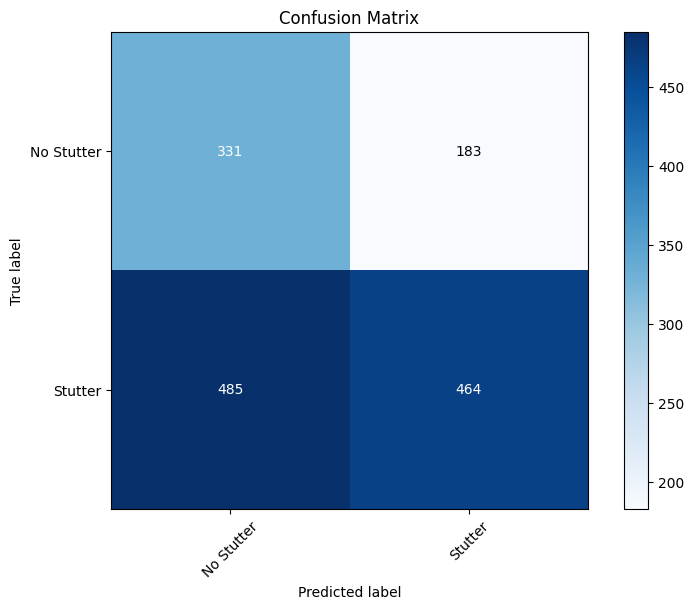


Classification Report:
              precision    recall  f1-score   support

  No Stutter       0.41      0.64      0.50       514
     Stutter       0.72      0.49      0.58       949

    accuracy                           0.54      1463
   macro avg       0.56      0.57      0.54      1463
weighted avg       0.61      0.54      0.55      1463

Plotting training history...
Available history keys: dict_keys(['accuracy', 'auc_2', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_auc_2', 'val_loss', 'val_precision_2', 'val_recall_2', 'learning_rate'])


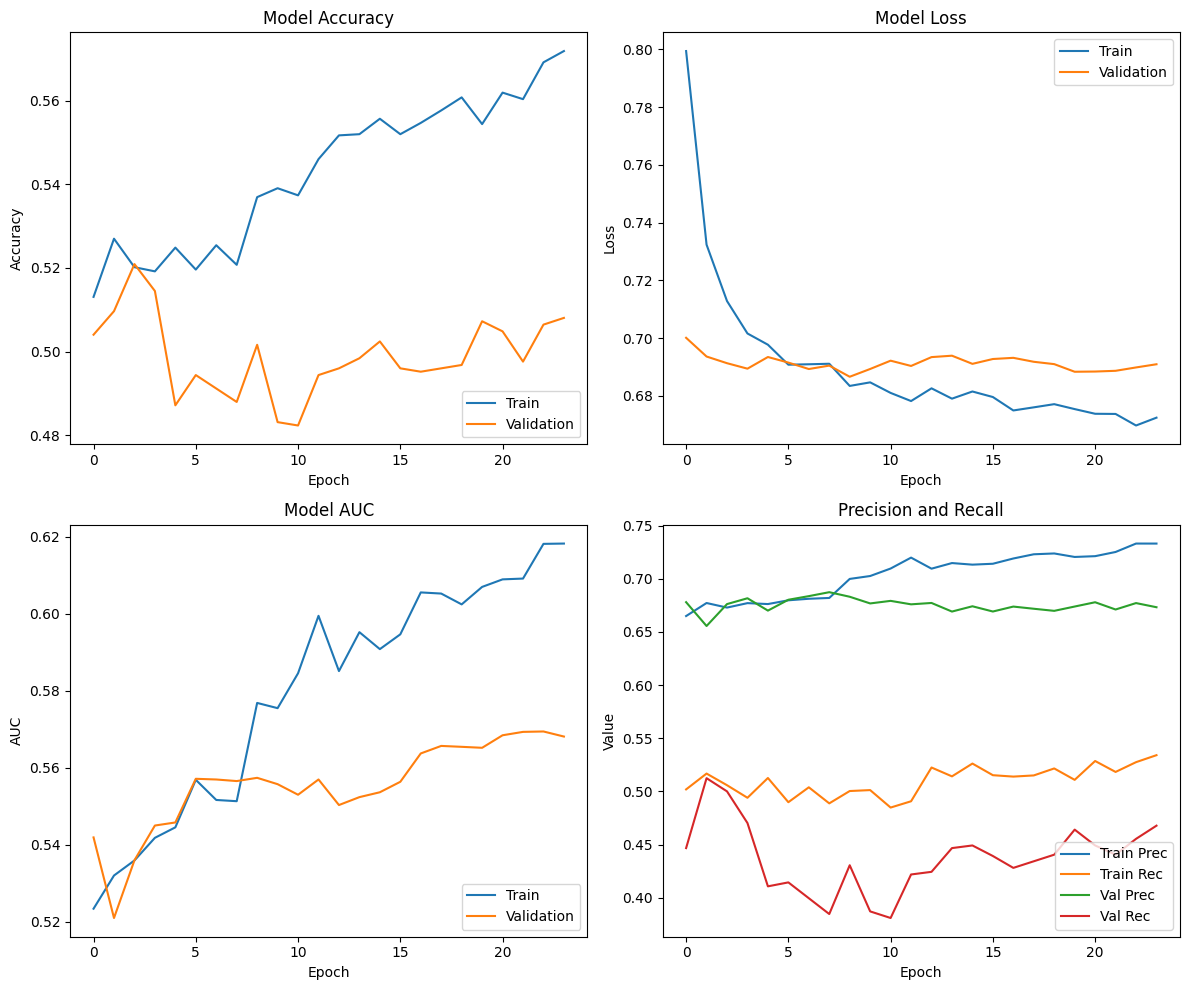

Analyzing feature importance...


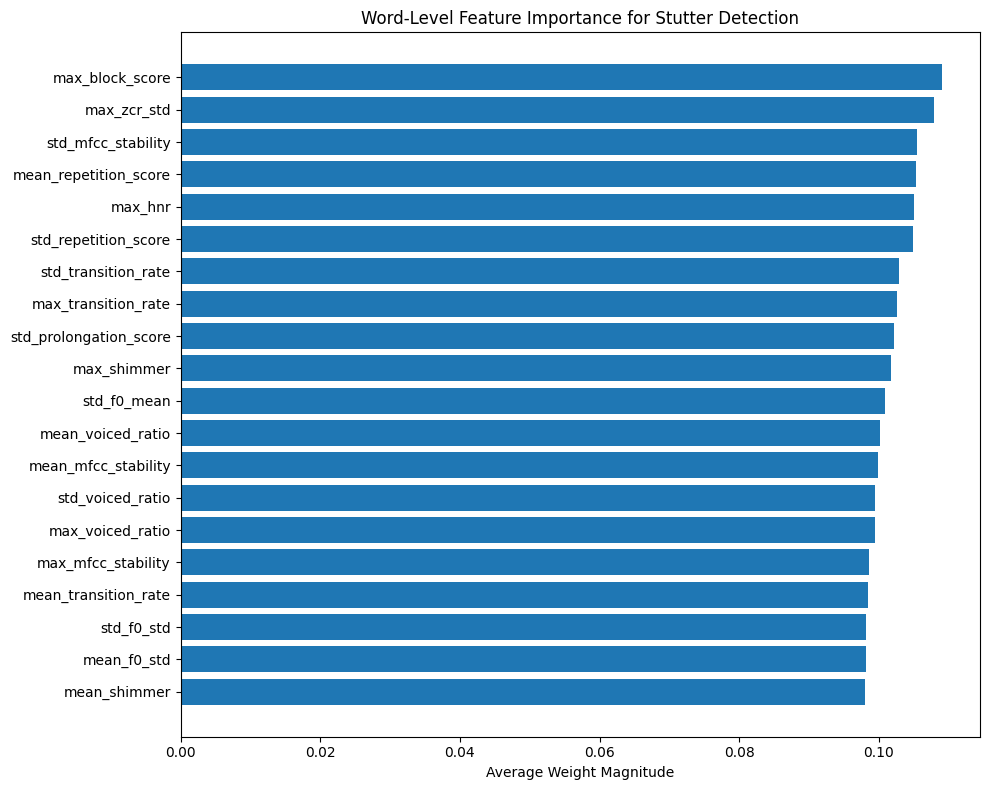


Top 10 Word-Level Features for Stutter Detection:
max_block_score: 0.1090
max_zcr_std: 0.1079
std_mfcc_stability: 0.1055
mean_repetition_score: 0.1053
max_hnr: 0.1051
std_repetition_score: 0.1048
std_transition_rate: 0.1028
max_transition_rate: 0.1026
std_prolongation_score: 0.1022
max_shimmer: 0.1017
Saving model...
Word-level stutter classification pipeline completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc  # Garbage collector

# Suppress warnings
warnings.filterwarnings('ignore')


def extract_word_level_features(audio_path, sr=16000, max_words=20, visualize=False):
    """
    Extract features at word level from an audio clip with enhanced features for stutter detection
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr)

        # Apply pre-emphasis filter
        pre_emphasis = 0.97
        y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        # Compute energy
        hop_length = 512
        energy = librosa.feature.rms(y=y, hop_length=hop_length)[0]

        # Calculate silence threshold (adaptive)
        silence_threshold = np.mean(energy) + 0.5 * np.std(energy)

        # Find silent regions (potential word boundaries)
        silences = []
        in_silence = True
        start_idx = 0

        # Minimum silence duration in frames (150ms typical between words)
        min_silence_frames = int(0.15 * sr / hop_length)

        for i, e in enumerate(energy):
            if in_silence and e > silence_threshold:
                # End of silence
                if i - start_idx >= min_silence_frames:
                    silences.append((start_idx, i))
                in_silence = False
            elif not in_silence and e <= silence_threshold:
                # Start of silence
                start_idx = i
                in_silence = True

        # Handle final silence
        if in_silence and len(energy) - start_idx >= min_silence_frames:
            silences.append((start_idx, len(energy)))

        # Convert silences to word segments
        word_segments = []

        # Add segment from start to first silence
        if silences and silences[0][0] > 0:
            word_segments.append((0, librosa.frames_to_samples(silences[0][0], hop_length=hop_length)))
        elif not silences:
            word_segments.append((0, len(y)))  # No silences, treat whole clip as one word

        # Add segments between silences
        for i in range(len(silences)-1):
            start = librosa.frames_to_samples(silences[i][1], hop_length=hop_length)
            end = librosa.frames_to_samples(silences[i+1][0], hop_length=hop_length)
            if end - start > sr * 0.1:  # Only keep segments longer than 100ms
                word_segments.append((start, end))

        # Add segment from last silence to end
        if silences and silences[-1][1] < len(energy):
            start = librosa.frames_to_samples(silences[-1][1], hop_length=hop_length)
            if len(y) - start > sr * 0.1:
                word_segments.append((start, len(y)))

        # If no word segments found, use whole clip
        if not word_segments:
            word_segments = [(0, len(y))]

        # Limit to max_words
        word_segments = word_segments[:max_words]

        # Initialize feature collections
        word_features = {}
        word_features['word_count'] = len(word_segments)
        word_features['word_segments'] = word_segments
        word_features['features_per_word'] = []

        # Extract features for each word
        for i, (start, end) in enumerate(word_segments):
            # Extract word audio
            word_audio = y[start:end]

            # Skip very short segments
            if len(word_audio) < sr * 0.05:  # < 50ms
                continue

            # Extract enhanced features for this word
            word_feature_dict = extract_enhanced_word_features(word_audio, sr, i)
            word_features['features_per_word'].append(word_feature_dict)

        # Store raw audio for visualization
        word_features['raw_audio'] = y
        word_features['sr'] = sr

        # Visualize if requested
        if visualize:
            plt.figure(figsize=(14, 10))

            # Play audio
            print("Playing audio clip...")
            ipd.display(ipd.Audio(y, rate=sr))

            # Plot waveform with word boundaries
            plt.subplot(3, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title('Waveform with Word Boundaries')

            # Add vertical lines for word boundaries
            for start, end in word_segments:
                plt.axvline(x=start/sr, color='r', linestyle='--', alpha=0.7)
                plt.axvline(x=end/sr, color='g', linestyle='--', alpha=0.7)

            # Plot energy
            plt.subplot(3, 1, 2)
            times = librosa.times_like(energy, sr=sr, hop_length=hop_length)
            plt.plot(times, energy)
            plt.axhline(y=silence_threshold, color='r', linestyle='--', label='Threshold')
            plt.title('Energy (RMS)')
            plt.ylabel('Energy')
            plt.legend()

            # Plot spectrogram
            plt.subplot(3, 1, 3)
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Mel Spectrogram with Word Boundaries')

            # Add vertical lines for word boundaries on spectrogram
            for start, end in word_segments:
                plt.axvline(x=start/sr, color='r', linestyle='--', alpha=0.7)
                plt.axvline(x=end/sr, color='g', linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.show()

            # Print key statistics
            print(f"\nDetected {word_features['word_count']} words")

            # Display features for each word
            for i, (start, end) in enumerate(word_segments):
                if i < len(word_features['features_per_word']):
                    word_feat = word_features['features_per_word'][i]
                    duration = (end - start) / sr

                    print(f"\nWord {i+1}:")
                    print(f"  Duration: {duration:.3f} sec")

                    # Play word audio
                    word_audio = y[start:end]
                    print(f"  Playing word audio...")
                    ipd.display(ipd.Audio(word_audio, rate=sr))

                    # Print stutter-relevant features
                    print(f"  Jitter: {word_feat['jitter']:.4f} (>0.015 indicates potential stutter)")
                    print(f"  Shimmer: {word_feat['shimmer']:.4f} (>0.035 indicates potential stutter)")
                    print(f"  HNR: {word_feat['hnr']:.2f} dB (<18 dB indicates potential stutter)")
                    print(f"  MFCC Stability: {word_feat['mfcc_stability']:.4f} (>0.12 indicates potential stutter)")

        return word_features

    except Exception as e:
        print(f"Error extracting word-level features: {str(e)}")
        traceback.print_exc()
        return None


def extract_enhanced_word_features(word_audio, sr, word_index):
    """
    Extract enhanced MFCC and prosodic features optimized for stutter detection
    """
    features = {}

    # Basic metadata
    features['word_index'] = word_index
    features['duration'] = len(word_audio) / sr

    try:
        # 1. Enhanced MFCC features
        mfcc = librosa.feature.mfcc(
            y=word_audio,
            sr=sr,
            n_mfcc=13,
            n_fft=int(0.025*sr),
            hop_length=int(0.010*sr),
            lifter=22
        )

        # Normalize MFCCs
        mfcc = librosa.util.normalize(mfcc, axis=1)

        # Compute delta and delta-delta features
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

        # Calculate temporal fluctuation (important for stutter detection)
        temporal_fluctuation = np.std(np.diff(mfcc, axis=1), axis=1)

        # Calculate local variability (rapid changes indicate stutter)
        local_variability = []
        for i in range(mfcc.shape[0]):
            if mfcc[i].shape[0] >= 5:  # Ensure enough frames
                rolled = np.lib.stride_tricks.sliding_window_view(mfcc[i], 5)
                local_variability.append(np.mean(np.var(rolled, axis=1)))
            else:
                local_variability.append(0)

        # Store MFCC features
        features['mfcc_mean'] = np.mean(mfcc, axis=1).tolist()
        features['mfcc_std'] = np.std(mfcc, axis=1).tolist()
        features['delta_mean'] = np.mean(delta_mfcc, axis=1).tolist()
        features['delta2_mean'] = np.mean(delta2_mfcc, axis=1).tolist()
        features['temporal_fluctuation'] = temporal_fluctuation.tolist()
        features['local_variability'] = local_variability
        features['mfcc_stability'] = np.mean(temporal_fluctuation)
        features['transition_rate'] = np.mean(np.abs(np.diff(mfcc, axis=1)))

        # 2. Enhanced prosodic features
        # Pitch (F0) extraction
        f0, voiced_flag, _ = librosa.pyin(
            word_audio,
            fmin=80,
            fmax=400,
            sr=sr
        )
        f0_valid = f0[~np.isnan(f0)]

        # Jitter calculation (cycle-to-cycle frequency variation)
        if len(f0_valid) > 1:
            jitter = np.mean(np.abs(np.diff(f0_valid))) / np.mean(f0_valid)
            # Relative Average Perturbation (RAP)
            if len(f0_valid) > 2:
                rap = np.mean(np.abs(f0_valid[1:-1] - (f0_valid[:-2] + f0_valid[1:-1] + f0_valid[2:])/3)) / np.mean(f0_valid)
            else:
                rap = 0
        else:
            jitter = 0
            rap = 0

        # Shimmer calculation (cycle-to-cycle amplitude variation)
        amplitude = librosa.feature.rms(y=word_audio)[0]
        if len(amplitude) > 1:
            shimmer = np.mean(np.abs(np.diff(amplitude))) / np.mean(amplitude)
            # Amplitude Perturbation Quotient (APQ)
            if len(amplitude) > 4:
                apq = np.mean(np.abs(amplitude[2:-2] - np.mean(np.lib.stride_tricks.sliding_window_view(amplitude, 5), axis=1))) / np.mean(amplitude)
            else:
                apq = 0
        else:
            shimmer = 0
            apq = 0

        # Harmonics-to-Noise Ratio (HNR)
        harmonic, percussive = librosa.effects.hpss(word_audio)
        hnr = 10 * np.log10(np.sum(harmonic**2) / (np.sum(percussive**2) + 1e-10))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=word_audio)[0]

        # Store prosodic features
        features['f0_mean'] = np.mean(f0_valid) if len(f0_valid) > 0 else 0
        features['f0_std'] = np.std(f0_valid) if len(f0_valid) > 0 else 0
        features['jitter'] = jitter
        features['rap'] = rap
        features['shimmer'] = shimmer
        features['apq'] = apq
        features['hnr'] = hnr
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)
        features['voiced_ratio'] = np.sum(~np.isnan(f0)) / len(f0) if len(f0) > 0 else 0

        # 3. Stutter-specific metrics
        # Repetition indicator (high local variability with low global variability)
        features['repetition_score'] = np.mean(local_variability) / (np.mean(features['mfcc_std']) + 1e-10)

        # Prolongation indicator (low jitter with high duration)
        features['prolongation_score'] = features['duration'] * (1 - min(jitter * 10, 1))

        # Block indicator (low energy with high ZCR)
        features['block_score'] = features['zcr_mean'] * (1 - min(np.mean(amplitude) * 10, 1))

        return features

    except Exception as e:
        print(f"Error extracting enhanced word features: {str(e)}")
        # Return basic features if extraction fails
        return {
            'word_index': word_index,
            'duration': len(word_audio) / sr,
            'error': str(e)
        }

def extract_aggregated_word_features(clip_path):
    """Extract and aggregate word-level features for a single clip"""
    try:
        # Extract word-level features
        word_features = extract_word_level_features(clip_path, visualize=False)

        if word_features is None or 'features_per_word' not in word_features or len(word_features['features_per_word']) == 0:
            return None

        # Initialize aggregated features dictionary
        agg_features = {}

        # Track word count
        word_count = len(word_features['features_per_word'])
        agg_features['word_count'] = word_count

        # Numeric features to aggregate
        numeric_features = ['duration', 'mfcc_stability', 'transition_rate',
                          'jitter', 'shimmer', 'hnr', 'f0_mean', 'f0_std',
                          'zcr_mean', 'zcr_std', 'voiced_ratio',
                          'repetition_score', 'prolongation_score', 'block_score']

        # Initialize aggregated features
        for feature in numeric_features:
            agg_features[f'mean_{feature}'] = 0
            agg_features[f'std_{feature}'] = 0
            agg_features[f'max_{feature}'] = 0

        # Collect values for each feature across words
        feature_values = {feature: [] for feature in numeric_features}

        # Extract values from each word
        for word_feat in word_features['features_per_word']:
            for feature in numeric_features:
                if feature in word_feat:
                    feature_values[feature].append(word_feat[feature])

        # Calculate statistics for each feature
        for feature in numeric_features:
            if feature_values[feature]:  # If we have values
                agg_features[f'mean_{feature}'] = np.mean(feature_values[feature])
                if len(feature_values[feature]) > 1:
                    agg_features[f'std_{feature}'] = np.std(feature_values[feature])
                agg_features[f'max_{feature}'] = np.max(feature_values[feature])

        return agg_features

    except Exception as e:
        print(f"Error processing {clip_path}: {str(e)}")
        return None

def batch_process_clips(clips_df, batch_size=100):
    """Process clips in batches to avoid memory issues"""
    all_features = []
    all_labels = []

    total_batches = len(clips_df) // batch_size + (1 if len(clips_df) % batch_size > 0 else 0)

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(clips_df))

        batch_df = clips_df.iloc[start_idx:end_idx]

        print(f"Processing batch {batch_idx+1}/{total_batches} (clips {start_idx+1}-{end_idx})")

        # Extract features for this batch
        batch_results = []
        for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx+1}"):
            features = extract_aggregated_word_features(row['file_path'])
            if features is not None:
                batch_results.append((features, row['Stutter Word']))

        # Add valid results to our lists
        for features, label in batch_results:
            all_features.append(features)
            all_labels.append(label)

        # Force garbage collection to free memory
        gc.collect()

    if len(all_features) == 0:
        raise ValueError("No valid features extracted. Check your audio files and paths.")

    # Convert features to DataFrame
    features_df = pd.DataFrame(all_features)
    labels = np.array(all_labels)

    return features_df, labels

def prepare_dataset(features_df, labels):
    """Prepare train/val/test datasets with proper scaling"""
    # First split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        features_df, labels, test_size=0.15, random_state=42, stratify=labels
    )

    # Then split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )

    # Standardize features based on training set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")

    # Print class distribution
    print(f"Class distribution in training set: {np.bincount(y_train)}")
    print(f"Class distribution in validation set: {np.bincount(y_val)}")
    print(f"Class distribution in testing set: {np.bincount(y_test)}")

    # Save scaler for future use
    from joblib import dump
    dump(scaler, 'word_features_scaler.joblib')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def build_model(input_shape):
    """Build DNN model for word-level stutter detection"""
    model = Sequential([
        # Input layer
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),

        # Hidden layers (deeper for word-level features)
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()]
    )

    # Show model summary
    model.summary()

    return model

def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with early stopping and LR reduction"""
    # Calculate class weights for imbalanced dataset
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    print("Evaluating model on test set...")
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Stutter', 'Stutter'], rotation=45)
    plt.yticks(tick_marks, ['No Stutter', 'Stutter'])

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Stutter', 'Stutter']))

    return y_pred


def plot_training_history(history):
    """Plot training metrics"""
    # First, print available keys to debug
    print("Available history keys:", history.history.keys())

    plt.figure(figsize=(12, 10))

    # Plot accuracy - access the correct metric name
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC - the key might be different than just 'auc'
    # In TF 2.0+, it might be something like 'auc_1' or the custom name you provided
    plt.subplot(2, 2, 3)

    # Use the correct AUC key from the printed keys above
    auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' not in k][0]
    val_auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' in k][0]

    plt.plot(history.history[auc_key])
    plt.plot(history.history[val_auc_key])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot Precision/Recall if available
    if any('precision' in k for k in history.history.keys()):
        plt.subplot(2, 2, 4)
        prec_key = [k for k in history.history.keys() if 'precision' in k and 'val' not in k][0]
        val_prec_key = [k for k in history.history.keys() if 'precision' in k and 'val' in k][0]
        rec_key = [k for k in history.history.keys() if 'recall' in k and 'val' not in k][0]
        val_rec_key = [k for k in history.history.keys() if 'recall' in k and 'val' in k][0]

        plt.plot(history.history[prec_key])
        plt.plot(history.history[rec_key])
        plt.plot(history.history[val_prec_key])
        plt.plot(history.history[val_rec_key])
        plt.title('Precision and Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend(['Train Prec', 'Train Rec', 'Val Prec', 'Val Rec'], loc='lower right')

    plt.tight_layout()
    plt.show()


def analyze_feature_importance(model, feature_names):
    """Analyze which word-level features are most important"""
    # For a DNN, we can examine the weights of the first layer
    weights = model.layers[0].get_weights()[0]

    # Calculate average absolute weight for each feature
    importance = np.mean(np.abs(weights), axis=1)

    # Pair feature names with their importance
    feature_importance = list(zip(feature_names, importance))

    # Sort by importance (descending)
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    features, importance = zip(*feature_importance[:20])  # Top 20 features
    plt.barh(features, importance)
    plt.xlabel('Average Weight Magnitude')
    plt.title('Word-Level Feature Importance for Stutter Detection')
    plt.gca().invert_yaxis()  # Display most important at the top
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Word-Level Features for Stutter Detection:")
    for feature, imp in feature_importance[:10]:
        print(f"{feature}: {imp:.4f}")

    return feature_importance

def run_word_level_classification(clips_df):
    """End-to-end word-level stutter classification pipeline"""
    # Check if cached features exist
    if os.path.exists('word_features.csv') and os.path.exists('word_labels.npy'):
        print("Loading pre-extracted features...")
        features_df = pd.read_csv('word_features.csv')
        labels = np.load('word_labels.npy')
    else:
        # 1. Extract features
        print("Extracting word-level features...")
        features_df, labels = batch_process_clips(clips_df)

        # Save extracted features to avoid reprocessing
        print("Saving extracted features...")
        features_df.to_csv('word_features.csv', index=False)
        np.save('word_labels.npy', labels)

    # 2. Prepare datasets
    print("Preparing train/val/test datasets...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_df, labels)

    # 3. Build model
    print("Building model...")
    model = build_model(X_train.shape[1])

    # 4. Train model
    print("Training model...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)

    # 5. Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X_test, y_test)

    # 6. Plot training history
    print("Plotting training history...")
    plot_training_history(history)

    # 7. Analyze feature importance
    print("Analyzing feature importance...")
    analyze_feature_importance(model, features_df.columns)

    # 8. Save model
    print("Saving model...")
    model.save('word_level_stutter_model.h5')

    return model, features_df

# Run the pipeline
try:
    model, features_df = run_word_level_classification(clips_df)
    print("Word-level stutter classification pipeline completed successfully!")
except Exception as e:
    print(f"Error in word-level classification pipeline: {str(e)}")
    import traceback
    traceback.print_exc()


In [ ]:


import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import traceback
from scipy.signal import lfilter
import scipy.stats

def extract_syllable_level_features(audio_path, sr=16000, visualize=False):
    """
    Extract syllable-level features using group delay function approach from Nagarajan et al. (2003)
    with enhanced features for stutter detection.

    Parameters:
        audio_path (str): Path to the audio file
        sr (int): Sampling rate
        visualize (bool): Whether to visualize the features

    Returns:
        dict: Dictionary containing syllable-level features
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr)

        # Apply pre-emphasis filter
        pre_emphasis = 0.97
        y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        # Create three sub-bands as described in the paper
        # 1. Original signal
        y_original = y.copy()

        # 2. Low-pass filtered signal (to remove fricatives)
        b_low = [1.0, -0.97]
        a_low = [1.0]
        y_low = lfilter(b_low, a_low, y)

        # 3. Band-pass filtered signal (to attenuate semivowels)
        D = librosa.stft(y, n_fft=1024, hop_length=256)
        D_mid = D.copy()
        D_mid[:20] = 0
        D_mid[50:] = 0
        y_mid = librosa.istft(D_mid, hop_length=256)

        # Ensure all signals have the same length by truncating to the minimum length
        min_length = min(len(y_original), len(y_low), len(y_mid))
        y_original = y_original[:min_length]
        y_low = y_low[:min_length]
        y_mid = y_mid[:min_length]

        # Compute short-term energy functions for each sub-band with the same parameters
        hop_length = 128
        frame_length = 512
        energy_original = librosa.feature.rms(y=y_original, frame_length=frame_length, hop_length=hop_length)[0]
        energy_low = librosa.feature.rms(y=y_low, frame_length=frame_length, hop_length=hop_length)[0]
        energy_mid = librosa.feature.rms(y=y_mid, frame_length=frame_length, hop_length=hop_length)[0]

        # Normalize energy functions
        energy_original = energy_original / np.max(energy_original) if np.max(energy_original) > 0 else energy_original
        energy_low = energy_low / np.max(energy_low) if np.max(energy_low) > 0 else energy_low
        energy_mid = energy_mid / np.max(energy_mid) if np.max(energy_mid) > 0 else energy_mid

        # Function to compute minimum phase group delay function
        def compute_group_delay(energy):
            # 1. Create symmetric energy sequence
            energy_sym = np.concatenate([energy, energy[::-1]])

            # 2. Invert the sequence (since we're interested in valleys)
            energy_inv = 1.0 - energy_sym

            # 3. Compute root cepstrum (inverse DFT)
            root_cepstrum = np.fft.ifft(energy_inv).real

            # 4. Window the causal part (minimum phase signal)
            window_size = int(len(root_cepstrum) * 0.1)
            windowed_cepstrum = root_cepstrum[:window_size].copy()

            # 5. Compute group delay function
            group_delay = np.zeros_like(energy)
            for n in range(len(group_delay)):
                for k in range(min(window_size, len(windowed_cepstrum))):
                    group_delay[n] += k * windowed_cepstrum[k] * np.cos(2 * np.pi * k * n / len(energy))

            return group_delay

        # Compute group delay functions for each sub-band
        gd_original = compute_group_delay(energy_original)
        gd_low = compute_group_delay(energy_low)
        gd_mid = compute_group_delay(energy_mid)

        # Detect peaks in each group delay function
        def find_peaks(gd, threshold=0.2):
            peaks = []
            for i in range(1, len(gd) - 1):
                if gd[i] > gd[i-1] and gd[i] > gd[i+1] and gd[i] > threshold:
                    peaks.append(i)
            return peaks

        peaks_original = find_peaks(gd_original)
        peaks_low = find_peaks(gd_low)
        peaks_mid = find_peaks(gd_mid)

        # Convert peak indices to time (in samples)
        peaks_original_samples = [p * hop_length for p in peaks_original]
        peaks_low_samples = [p * hop_length for p in peaks_low]
        peaks_mid_samples = [p * hop_length for p in peaks_mid]

        # Combine evidence from all sub-bands as per paper section 3.2.5
        combined_peaks = []

        # First, add all peaks from original signal
        combined_peaks.extend(peaks_original_samples)

        # Add peaks from low-pass filtered signal if close to original
        for peak_low in peaks_low_samples:
            # Check if within 20ms of any peak in original
            if not any(abs(peak_low - peak_orig) <= 0.02 * sr for peak_orig in peaks_original_samples):
                # Only add if not too close to existing peaks
                if not any(abs(peak_low - peak) <= 0.01 * sr for peak in combined_peaks):
                    combined_peaks.append(peak_low)

        # Add peaks from band-pass filtered signal if in specific range
        for peak_mid in peaks_mid_samples:
            # Check if within 50-100ms range from any peak in combined
            if not any(0.05 * sr <= abs(peak_mid - peak) <= 0.1 * sr for peak in combined_peaks):
                # Only add if not too close to existing peaks
                if not any(abs(peak_mid - peak) <= 0.01 * sr for peak in combined_peaks):
                    combined_peaks.append(peak_mid)

        # Sort peaks chronologically
        combined_peaks.sort()

        # Create syllable segments
        segments = []
        for i in range(len(combined_peaks) - 1):
            start = combined_peaks[i]
            end = combined_peaks[i + 1]
            # Ensure minimum syllable duration (50ms)
            if (end - start) >= 0.05 * sr:
                segments.append((start, end))

        # If no segments detected or only one boundary, use whole clip
        if len(segments) == 0 and len(combined_peaks) > 0:
            segments = [(0, combined_peaks[0]), (combined_peaks[0], len(y))]
        elif len(segments) == 0:
            segments = [(0, len(y))]

        # Extract features from each syllable
        syllable_features = {}
        syllable_features['syllable_count'] = len(segments)
        syllable_features['syllable_segments'] = segments
        syllable_features['syllable_data'] = []

        durations = []
        energies = []
        pitches = []
        mfccs_means = []
        mfccs_stds = []
        jitters = []
        shimmers = []
        hnrs = []

        # Process each syllable segment
        for i, (start, end) in enumerate(segments):
            if end <= len(y):
                syllable = y[start:end]
                duration = (end - start) / sr
                durations.append(duration)

                # Energy profile
                syl_energy = librosa.feature.rms(y=syllable)[0]
                energy_mean = np.mean(syl_energy)
                energy_std = np.std(syl_energy)
                energies.append(energy_mean)

                # MFCC features
                if len(syllable) > 512:  # Ensure enough samples for MFCC
                    mfcc = librosa.feature.mfcc(
                        y=syllable,
                        sr=sr,
                        n_mfcc=13,
                        n_fft=int(0.025*sr),
                        hop_length=int(0.010*sr)
                    )
                    mfcc_mean = np.mean(mfcc, axis=1)
                    mfcc_std = np.std(mfcc, axis=1)
                    mfccs_means.append(mfcc_mean)
                    mfccs_stds.append(mfcc_std)

                    # Calculate temporal fluctuation
                    temporal_fluctuation = np.std(np.diff(mfcc, axis=1), axis=1)
                else:
                    mfcc_mean = np.zeros(13)
                    mfcc_std = np.zeros(13)
                    temporal_fluctuation = np.zeros(13)
                    mfccs_means.append(mfcc_mean)
                    mfccs_stds.append(mfcc_std)

                # Pitch analysis
                if len(syllable) > 512:  # Ensure enough samples for pitch analysis
                    f0, voiced_flag, _ = librosa.pyin(
                        syllable,
                        fmin=librosa.note_to_hz('C2'),
                        fmax=librosa.note_to_hz('C7'),
                        sr=sr
                    )
                    f0_valid = f0[~np.isnan(f0)]

                    if len(f0_valid) > 0:
                        f0_mean = np.mean(f0_valid)
                        f0_std = np.std(f0_valid)
                        f0_stability = f0_std/f0_mean if f0_mean > 0 else 0
                        pitches.append(f0_mean)

                        # Calculate jitter (frequency perturbation)
                        if len(f0_valid) > 1:
                            jitter = np.mean(np.abs(np.diff(f0_valid))) / f0_mean if f0_mean > 0 else 0
                            jitters.append(jitter)
                        else:
                            jitter = 0
                            jitters.append(0)
                    else:
                        f0_mean = 0
                        f0_std = 0
                        f0_stability = 0
                        pitches.append(0)
                        jitter = 0
                        jitters.append(0)
                else:
                    f0_mean = 0
                    f0_std = 0
                    f0_stability = 0
                    pitches.append(0)
                    jitter = 0
                    jitters.append(0)

                # Calculate shimmer (amplitude perturbation)
                if len(syl_energy) > 1:
                    shimmer = np.mean(np.abs(np.diff(syl_energy))) / energy_mean if energy_mean > 0 else 0
                    shimmers.append(shimmer)
                else:
                    shimmer = 0
                    shimmers.append(0)

                # Calculate HNR (harmonics-to-noise ratio)
                if len(syllable) > 512:
                    harmonic, percussive = librosa.effects.hpss(syllable)
                    hnr = 10 * np.log10(np.sum(harmonic**2) / (np.sum(percussive**2) + 1e-10))
                    hnrs.append(hnr)
                else:
                    hnr = 0
                    hnrs.append(0)

                # Zero-crossing rate
                zcr = librosa.feature.zero_crossing_rate(y=syllable)[0]
                zcr_mean = np.mean(zcr)

                # Spectral centroid
                if len(syllable) > 512:
                    spectral_centroid = librosa.feature.spectral_centroid(y=syllable, sr=sr)[0]
                    centroid_mean = np.mean(spectral_centroid)
                else:
                    centroid_mean = 0

                # Store syllable features
                syllable_data = {
                    'start_time': start/sr,
                    'end_time': end/sr,
                    'duration': duration,
                    'energy_mean': energy_mean,
                    'energy_std': energy_std,
                    'f0_mean': f0_mean,
                    'f0_std': f0_std,
                    'f0_stability': f0_stability,
                    'mfcc_mean': mfcc_mean.tolist(),
                    'mfcc_std': mfcc_std.tolist(),
                    'temporal_fluctuation': temporal_fluctuation.tolist(),
                    'jitter': jitter,
                    'shimmer': shimmer,
                    'hnr': hnr,
                    'zcr_mean': zcr_mean,
                    'spectral_centroid': centroid_mean
                }

                syllable_features['syllable_data'].append(syllable_data)

        # Calculate rhythm metrics if we have enough syllables
        if len(durations) > 1:
            # Normalized Pairwise Variability Index (nPVI)
            pvi_norm = np.mean([abs(a-b)/((a+b)/2) for a, b in zip(durations[:-1], durations[1:])])

            # Calculate duration coefficient of variation
            duration_cv = np.std(durations)/np.mean(durations) if np.mean(durations) > 0 else 0

            # Calculate energy variability
            energy_cv = np.std(energies)/np.mean(energies) if np.mean(energies) > 0 else 0

            # Calculate pitch variability
            valid_pitches = [p for p in pitches if p > 0]
            pitch_cv = np.std(valid_pitches)/np.mean(valid_pitches) if len(valid_pitches) > 0 and np.mean(valid_pitches) > 0 else 0

            # Calculate jitter and shimmer variability
            jitter_cv = np.std(jitters)/np.mean(jitters) if len(jitters) > 0 and np.mean(jitters) > 0 else 0
            shimmer_cv = np.std(shimmers)/np.mean(shimmers) if len(shimmers) > 0 and np.mean(shimmers) > 0 else 0

            syllable_features.update({
                'syllable_rate': len(durations)/(segments[-1][1]/sr),
                'mean_duration': np.mean(durations),
                'duration_variability': duration_cv,
                'rhythm_pvi_norm': pvi_norm,
                'energy_variability': energy_cv,
                'pitch_variability': pitch_cv,
                'jitter_variability': jitter_cv,
                'shimmer_variability': shimmer_cv,
                'mean_jitter': np.mean(jitters),
                'mean_shimmer': np.mean(shimmers),
                'mean_hnr': np.mean(hnrs)
            })

            # Detect potential repetitions (important for stutter analysis)
            repetition_indices = []
            for i in range(len(durations)-1):
                # Check for similar consecutive syllables
                duration_ratio = min(durations[i], durations[i+1]) / max(durations[i], durations[i+1])
                energy_ratio = min(energies[i], energies[i+1]) / max(energies[i], energies[i+1])

                # If we have MFCC data, use it for similarity
                mfcc_similarity = 0
                if i < len(mfccs_means)-1:
                    mfcc_similarity = np.corrcoef(mfccs_means[i], mfccs_means[i+1])[0,1]
                    if np.isnan(mfcc_similarity):
                        mfcc_similarity = 0

                # Combine multiple factors for repetition detection
                if duration_ratio > 0.8 and energy_ratio > 0.75 and mfcc_similarity > 0.6:
                    repetition_indices.append(i)

            syllable_features['potential_repetitions'] = repetition_indices
            syllable_features['repetition_count'] = len(repetition_indices)

            # Calculate stutter-specific metrics
            # Prolongation detection (long syllables with stable pitch)
            prolongation_indices = []
            mean_duration = np.mean(durations)
            for i, duration in enumerate(durations):
                if duration > 1.5 * mean_duration and i < len(jitters) and jitters[i] < 0.015:
                    prolongation_indices.append(i)

            syllable_features['potential_prolongations'] = prolongation_indices
            syllable_features['prolongation_count'] = len(prolongation_indices)

            # Block detection (short syllables with high jitter/shimmer)
            block_indices = []
            for i, duration in enumerate(durations):
                if duration < 0.7 * mean_duration and i < len(jitters) and i < len(shimmers):
                    if jitters[i] > 0.025 or shimmers[i] > 0.04:
                        block_indices.append(i)

            syllable_features['potential_blocks'] = block_indices
            syllable_features['block_count'] = len(block_indices)

        # Visualize if requested
        if visualize:
            plt.figure(figsize=(14, 12))

            # Play audio
            print("Playing audio clip...")
            ipd.display(ipd.Audio(y, rate=sr))

            # Plot waveform with syllable boundaries
            plt.subplot(5, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            for start, end in segments:
                plt.axvline(x=start/sr, color='r', linestyle='--', alpha=0.7)
                plt.axvline(x=end/sr, color='g', linestyle='--', alpha=0.7)
            plt.title('Waveform with Syllable Boundaries')

            # Generate time axis - Ensure all energy arrays have same length
            min_energy_len = min(len(energy_original), len(energy_low), len(energy_mid))
            energy_original_plot = energy_original[:min_energy_len]
            energy_low_plot = energy_low[:min_energy_len]
            energy_mid_plot = energy_mid[:min_energy_len]
            times = librosa.times_like(energy_original_plot, sr=sr, hop_length=hop_length)

            # Plot energy contours
            plt.subplot(5, 1, 2)
            plt.plot(times, energy_original_plot, label='Original')
            plt.plot(times, energy_low_plot, label='Low-pass filtered')
            plt.plot(times, energy_mid_plot, label='Band-pass filtered')
            plt.legend()
            plt.title('Energy Contours from Different Sub-bands')

            # Plot group delay functions
            plt.subplot(5, 1, 3)
            gd_original_plot = gd_original[:min_energy_len]
            gd_low_plot = gd_low[:min_energy_len]
            gd_mid_plot = gd_mid[:min_energy_len]

            plt.plot(times, gd_original_plot, label='Original')
            plt.plot(times, gd_low_plot, label='Low-pass filtered')
            plt.plot(times, gd_mid_plot, label='Band-pass filtered')

            # Mark peaks
            for p in peaks_original:
                if p < min_energy_len:
                    plt.plot(times[p], gd_original_plot[p], 'ro')
            for p in peaks_low:
                if p < min_energy_len:
                    plt.plot(times[p], gd_low_plot[p], 'go')
            for p in peaks_mid:
                if p < min_energy_len:
                    plt.plot(times[p], gd_mid_plot[p], 'bo')

            plt.legend()
            plt.title('Group Delay Functions with Detected Peaks')

            # Plot syllable durations
            plt.subplot(5, 1, 4)
            plt.bar(range(len(durations)), durations)
            if 'potential_repetitions' in syllable_features:
                for idx in syllable_features['potential_repetitions']:
                    plt.bar(idx, durations[idx], color='red')
                    plt.bar(idx+1, durations[idx+1], color='red')
            plt.title('Syllable Durations')
            plt.xlabel('Syllable Index')
            plt.ylabel('Duration (s)')

            # Plot spectrogram
            plt.subplot(5, 1, 5)
            S = librosa.feature.melspectrogram(y=y, sr=sr)
            S_dB = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            for start, end in segments:
                plt.axvline(x=start/sr, color='w', linestyle='--', alpha=0.5)
            plt.title('Mel Spectrogram with Syllable Boundaries')

            plt.tight_layout()
            plt.show()

            # Print key statistics
            print("\nSyllable-Level Features for Stutter Detection:")
            print(f"Total Syllables: {syllable_features['syllable_count']}")

            if 'syllable_rate' in syllable_features:
                print(f"Syllable Rate: {syllable_features['syllable_rate']:.2f} syllables/sec")
                print(f"Mean Syllable Duration: {syllable_features['mean_duration']*1000:.1f} ms")
                print(f"Duration Variability (CV): {syllable_features['duration_variability']:.2f}")
                print(f"Rhythm PVI (normalized): {syllable_features['rhythm_pvi_norm']:.2f}")
                print(f"Energy Variability: {syllable_features['energy_variability']:.2f}")

                if syllable_features['repetition_count'] > 0:
                    print(f"\nPotential Syllable Repetitions: {syllable_features['repetition_count']}")
                    for idx in syllable_features['potential_repetitions']:
                        print(f"  Syllables {idx+1} and {idx+2} appear repeated")

            return syllable_features

    except Exception as e:
        print(f"Error extracting syllable-level features: {str(e)}")
        return None


In [ ]:



import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from joblib import Parallel, delayed
import scipy.signal
import gc

# Suppress warnings to keep output clean
warnings.filterwarnings('ignore')

def extract_aggregated_syllable_features(clip_path, sr=16000, verbose=False):
    """
    Extract and aggregate syllable-level features with enhanced error handling
    """
    try:
        # Basic audio integrity check
        if not os.path.exists(clip_path):
            if verbose:
                print(f"File not found: {clip_path}")
            return None

        # Load audio with error handling
        try:
            y, sr = librosa.load(clip_path, sr=sr)

            # Check if audio is valid (not empty or corrupted)
            if len(y) < sr*0.1:  # Less than 100ms
                if verbose:
                    print(f"Audio too short: {clip_path}")
                return None

        except Exception as e:
            if verbose:
                print(f"Error loading audio {clip_path}: {str(e)}")
            return None

        # Apply pre-emphasis filter
        y = librosa.effects.preemphasis(y, coef=0.97)

        # First attempt: Use standard syllable feature extraction
        syllable_features = extract_syllable_level_features(clip_path, sr=sr, visualize=False)

        # If standard method fails, try simplified fallback method
        if syllable_features is None or 'syllable_count' not in syllable_features or syllable_features['syllable_count'] == 0:
            if verbose:
                print(f"Using fallback syllable detection for {clip_path}")
            syllable_features = extract_fallback_syllable_features(y, sr)

            # If still no syllables, return None
            if syllable_features is None or syllable_features['syllable_count'] == 0:
                if verbose:
                    print(f"No syllables detected in {clip_path}")
                return None

        # Initialize aggregated features dictionary
        agg_features = {}

        # Include syllable count
        agg_features['syllable_count'] = syllable_features['syllable_count']

        # Add basic prosodic statistics
        global_metrics = [
            'syllable_rate', 'mean_duration', 'duration_variability',
            'rhythm_pvi_norm', 'energy_variability', 'pitch_variability'
        ]

        # Add these metrics if available, otherwise use defaults
        for metric in global_metrics:
            if metric in syllable_features:
                agg_features[metric] = syllable_features[metric]
            else:
                agg_features[metric] = 0

        # Add stutter-specific metrics
        stutter_metrics = [
            'jitter_variability', 'shimmer_variability', 'mean_jitter',
            'mean_shimmer', 'mean_hnr', 'repetition_count',
            'prolongation_count', 'block_count'
        ]

        for metric in stutter_metrics:
            if metric in syllable_features:
                agg_features[metric] = syllable_features[metric]
            else:
                agg_features[metric] = 0

        # Extract additional statistics from individual syllables if available
        if 'syllable_data' in syllable_features and len(syllable_features['syllable_data']) > 0:
            # Extract key features from each syllable
            durations = []
            energies = []
            jitters = []
            shimmers = []
            hnrs = []

            for syl_data in syllable_features['syllable_data']:
                if 'duration' in syl_data:
                    durations.append(syl_data['duration'])
                if 'energy_mean' in syl_data:
                    energies.append(syl_data['energy_mean'])
                if 'jitter' in syl_data:
                    jitters.append(syl_data['jitter'])
                if 'shimmer' in syl_data:
                    shimmers.append(syl_data['shimmer'])
                if 'hnr' in syl_data:
                    hnrs.append(syl_data['hnr'])

            # Add meaningful statistics only if we have valid data
            if durations:
                agg_features['max_duration'] = np.max(durations)
                agg_features['min_duration'] = np.min(durations)
            else:
                # Default values if metrics missing
                agg_features['max_duration'] = 0
                agg_features['min_duration'] = 0

            if jitters:
                agg_features['max_jitter'] = np.max(jitters)
            else:
                agg_features['max_jitter'] = 0

            if shimmers:
                agg_features['max_shimmer'] = np.max(shimmers)
            else:
                agg_features['max_shimmer'] = 0

            if hnrs:
                valid_hnrs = [h for h in hnrs if h > 0]
                agg_features['min_hnr'] = np.min(valid_hnrs) if valid_hnrs else 0
            else:
                agg_features['min_hnr'] = 0

        # If no syllable data available, add default values
        else:
            default_features = ['max_duration', 'min_duration', 'max_jitter',
                               'max_shimmer', 'min_hnr']
            for feat in default_features:
                agg_features[feat] = 0

        return agg_features

    except Exception as e:
        if verbose:
            print(f"Unexpected error processing {clip_path}: {str(e)}")
        return None

def extract_fallback_syllable_features(y, sr):
    """Fallback method for syllable detection when main method fails"""
    try:
        # Use energy-based method for syllable segmentation
        # Calculate energy envelope
        energy = librosa.feature.rms(y=y, frame_length=int(0.025*sr), hop_length=int(0.010*sr))[0]

        # Normalize energy
        energy = energy / np.max(energy) if np.max(energy) > 0 else energy

        # Find peaks in energy contour (potential syllable centers)
        peaks, _ = scipy.signal.find_peaks(energy, height=0.1, distance=int(0.15*sr/160))

        # If no peaks found, return None
        if len(peaks) == 0:
            return None

        # Create syllable segments
        segments = []
        for i in range(len(peaks)-1):
            start = peaks[i]
            end = peaks[i+1]
            # Minimum syllable duration check (50ms)
            if (end - start) >= int(0.05*sr/160):
                segments.append((start*160, end*160))  # Convert frame indices to samples

        # Handle first and last segments
        if len(segments) == 0 and len(peaks) > 0:
            start_sample = max(0, peaks[0]*160 - int(0.1*sr))
            end_sample = min(len(y), peaks[0]*160 + int(0.1*sr))
            segments = [(start_sample, end_sample)]

        # Create basic syllable features
        syllable_features = {
            'syllable_count': len(segments),
            'syllable_segments': segments,
            'syllable_data': []
        }

        # Create basic metrics
        durations = [(end-start)/sr for start, end in segments]

        if len(durations) > 1:
            syllable_features['mean_duration'] = np.mean(durations)
            syllable_features['duration_variability'] = np.std(durations)/np.mean(durations) if np.mean(durations) > 0 else 0
            syllable_features['syllable_rate'] = len(durations)/(segments[-1][1]/sr) if segments else 0
        else:
            syllable_features['mean_duration'] = durations[0] if durations else 0
            syllable_features['duration_variability'] = 0
            syllable_features['syllable_rate'] = 1/durations[0] if durations and durations[0] > 0 else 0

        # Process each syllable segment for basic features
        for i, (start, end) in enumerate(segments):
            if end <= len(y):
                syllable = y[start:end]
                duration = (end - start) / sr

                # Basic energy
                syl_energy = np.mean(np.abs(syllable)**2)

                syllable_data = {
                    'duration': duration,
                    'energy_mean': syl_energy,
                    'jitter': 0,  # Default values for fallback method
                    'shimmer': 0,
                    'hnr': 0
                }

                syllable_features['syllable_data'].append(syllable_data)

        return syllable_features

    except Exception as e:
        print(f"Error in fallback syllable detection: {str(e)}")
        return None

def batch_process_clips(clips_df, batch_size=30, n_jobs=4):
    """
    Process clips in smaller batches with parallel processing for speed
    """
    all_features = []
    all_labels = []

    # Calculate number of batches
    total_batches = len(clips_df) // batch_size + (1 if len(clips_df) % batch_size > 0 else 0)

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(clips_df))

        batch_df = clips_df.iloc[start_idx:end_idx]

        print(f"Processing batch {batch_idx+1}/{total_batches} (clips {start_idx+1}-{end_idx})")

        # Use parallel processing to speed up extraction
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_clip)(row, idx)
            for idx, row in enumerate(batch_df.iterrows())
        )

        # Filter out None results and add to lists
        valid_results = [(feat, label) for feat, label in results if feat is not None]

        if valid_results:
            batch_features, batch_labels = zip(*valid_results)
            all_features.extend(batch_features)
            all_labels.extend(batch_labels)

            # Save intermediate results for recovery in case of crash
            if batch_idx % 5 == 0 and batch_idx > 0:
                temp_df = pd.DataFrame(all_features)
                temp_df.to_csv(f'syllable_features_batch_{batch_idx}.csv', index=False)
                np.save(f'syllable_labels_batch_{batch_idx}.npy', np.array(all_labels))
                print(f"Saved intermediate results after batch {batch_idx}")
        else:
            print(f"Warning: No valid features in batch {batch_idx+1}")

        # Force garbage collection
        gc.collect()

    # Check if we got any valid features
    if len(all_features) == 0:
        raise ValueError("No valid features extracted. Try using verbose=True in extract_aggregated_syllable_features to debug.")

    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    labels = np.array(all_labels)

    # Fill NaN values with 0
    features_df = features_df.fillna(0)

    print(f"Successfully extracted features from {len(features_df)} clips out of {len(clips_df)} total clips")

    return features_df, labels

def process_clip(row_data, idx):
    """Process a single clip for parallel execution"""
    idx, row = row_data
    try:
        features = extract_aggregated_syllable_features(row['file_path'])
        if features is not None:
            return (features, row['Stutter Word'])
        return None
    except Exception as e:
        print(f"Error processing clip {idx}: {str(e)}")
        return None

# Main function for running syllable-level classification
def run_syllable_level_classification(clips_df):
    """End-to-end syllable-level stutter classification pipeline with robust error handling"""
    # Check if cached features exist
    if os.path.exists('syllable_features.csv') and os.path.exists('syllable_labels.npy'):
        print("Loading pre-extracted features...")
        features_df = pd.read_csv('syllable_features.csv')
        labels = np.load('syllable_labels.npy')
    else:
        # Look for partial results from previous runs
        partial_files = [f for f in os.listdir('.') if f.startswith('syllable_features_batch_') and f.endswith('.csv')]

        if partial_files and input("Found partial results from previous run. Use them? (y/n): ").lower() == 'y':
            # Load and combine partial results
            print("Loading partial results...")
            partial_features = []
            partial_labels = []

            for file in sorted(partial_files, key=lambda x: int(x.split('_')[-1].split('.')[0])):
                batch_idx = int(file.split('_')[-1].split('.')[0])
                feat_file = f'syllable_features_batch_{batch_idx}.csv'
                label_file = f'syllable_labels_batch_{batch_idx}.npy'

                if os.path.exists(feat_file) and os.path.exists(label_file):
                    batch_df = pd.read_csv(feat_file)
                    batch_labels = np.load(label_file)

                    partial_features.append(batch_df)
                    partial_labels.extend(batch_labels)

            if partial_features:
                features_df = pd.concat(partial_features, ignore_index=True)
                labels = np.array(partial_labels)

                print(f"Loaded {len(features_df)} clips from partial results")

                # Process remaining clips
                processed_files = set(features_df['file_path'].values) if 'file_path' in features_df.columns else set()
                remaining_clips = clips_df[~clips_df['file_path'].isin(processed_files)]

                if len(remaining_clips) > 0:
                    print(f"Processing {len(remaining_clips)} remaining clips...")
                    remaining_features, remaining_labels = batch_process_clips(remaining_clips)

                    # Combine with partial results
                    features_df = pd.concat([features_df, remaining_features], ignore_index=True)
                    labels = np.concatenate([labels, remaining_labels])
            else:
                # If partial loading failed, process all clips
                print("Extracting syllable-level features...")
                features_df, labels = batch_process_clips(clips_df)
        else:
            # Process all clips normally
            print("Extracting syllable-level features...")
            features_df, labels = batch_process_clips(clips_df)

        # Save extracted features
        print("Saving extracted features...")
        features_df.to_csv('syllable_features.csv', index=False)
        np.save('syllable_labels.npy', labels)

    # Continue with the rest of the pipeline (train/test split, model building, etc.)
    print(f"Feature extraction complete. Found {len(features_df)} valid clips with {features_df.shape[1]} features per clip.")
    return features_df, labels





def prepare_dataset(features_df, labels):
    """Prepare train/val/test datasets with proper scaling"""
    # First split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        features_df, labels, test_size=0.15, random_state=42, stratify=labels
    )

    # Then split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )

    # Standardize features based on training set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")

    # Print class distribution
    print(f"Class distribution in training set: {np.bincount(y_train)}")
    print(f"Class distribution in validation set: {np.bincount(y_val)}")
    print(f"Class distribution in testing set: {np.bincount(y_test)}")

    # Save scaler for future use
    dump(scaler, 'syllable_features_scaler.joblib')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def build_dnn_model(input_shape):
    """Build DNN model for syllable-level stutter detection"""
    model = Sequential([
        # Input layer
        Dense(64, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden layers
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile model with explicitly named metrics to avoid errors
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    # Show model summary
    model.summary()

    return model

def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with early stopping and LR reduction"""
    # Calculate class weights for imbalanced dataset
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    print("Evaluating model on test set...")
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Stutter', 'Stutter'], rotation=45)
    plt.yticks(tick_marks, ['No Stutter', 'Stutter'])

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Stutter', 'Stutter']))

    return y_pred

def plot_training_history(history):
    """Plot training metrics with correct key names"""
    # Print available keys to debug
    print("Available metrics:", list(history.history.keys()))

    plt.figure(figsize=(12, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC - using correct key names
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot Precision/Recall - using correct key names
    plt.subplot(2, 2, 4)
    plt.plot(history.history['precision'])
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_precision'])
    plt.plot(history.history['val_recall'])
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(['Train Prec', 'Train Rec', 'Val Prec', 'Val Rec'], loc='lower right')

    plt.tight_layout()
    plt.show()

def analyze_feature_importance(model, feature_names):
    """Analyze which syllable-level features are most important for stutter detection"""
    # Extract first layer weights
    weights = model.layers[0].get_weights()[0]

    # Calculate average absolute weight for each feature
    importance = np.mean(np.abs(weights), axis=1)

    # Pair feature names with their importance
    feature_importance = list(zip(feature_names, importance))

    # Sort by importance (descending)
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance[:20]  # Show top 20 features
    features, importance = zip(*top_features)
    plt.barh(features, importance)
    plt.xlabel('Average Weight Magnitude')
    plt.title('Syllable-Level Feature Importance for Stutter Detection')
    plt.gca().invert_yaxis()  # Display most important at the top
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Syllable-Level Features for Stutter Detection:")
    for feature, imp in feature_importance[:10]:
        print(f"{feature}: {imp:.4f}")

    return feature_importance

def run_syllable_level_classification(clips_df):
    """End-to-end syllable-level stutter classification pipeline"""
    # Check if cached features exist
    if os.path.exists('syllable_features.csv') and os.path.exists('syllable_labels.npy'):
        print("Loading pre-extracted features...")
        features_df = pd.read_csv('syllable_features.csv')
        labels = np.load('syllable_labels.npy')
    else:
        # 1. Extract features
        print("Extracting syllable-level features...")
        features_df, labels = batch_process_clips(clips_df)

        # Save extracted features to avoid reprocessing
        print("Saving extracted features...")
        features_df.to_csv('syllable_features.csv', index=False)
        np.save('syllable_labels.npy', labels)

    # 2. Prepare datasets
    print("Preparing train/val/test datasets...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_df, labels)

    # 3. Build model
    print("Building model...")
    model = build_dnn_model(X_train.shape[1])

    # 4. Train model
    print("Training model...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)

    # 5. Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X_test, y_test)

    # 6. Plot training history
    print("Plotting training history...")
    plot_training_history(history)

    # 7. Analyze feature importance
    print("Analyzing feature importance...")
    analyze_feature_importance(model, features_df.columns)

    # 8. Save model
    print("Saving model...")
    model.save('syllable_level_stutter_model.h5')

    return model, features_df

# Run the complete pipeline
try:
    # Run feature extraction and model training
    model, features_df = run_syllable_level_classification(clips_df)
    print("Syllable-level stutter classification pipeline completed successfully!")
except Exception as e:
    print(f"Error in syllable classification pipeline: {str(e)}")
    import traceback
    traceback.print_exc()




Extracting syllable-level features...
Processing batch 1/314 (clips 1-30)
Error in syllable classification pipeline: cannot unpack non-iterable NoneType object


Traceback (most recent call last):
  File "<ipython-input-21-f6b327eb6a21>", line 797, in <cell line: 0>
    model, features_df = run_syllable_level_classification(clips_df)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-f6b327eb6a21>", line 757, in run_syllable_level_classification
    features_df, labels = batch_process_clips(clips_df)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-f6b327eb6a21>", line 398, in batch_process_clips
    valid_results = [(feat, label) for feat, label in results if feat is not None]
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-21-f6b327eb6a21>", line 398, in <listcomp>
    valid_results = [(feat, label) for feat, label in results if feat is not None]
                                       ^^^^^^^^^^^
TypeError: cannot unpack non-iterable NoneType object


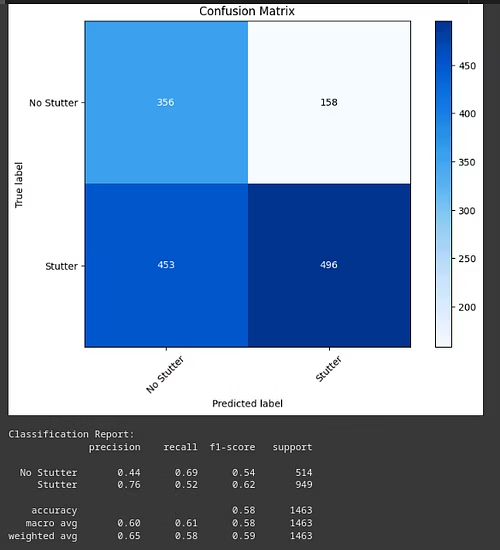

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
def extract_mfcc_features(audio_path, sr=16000, n_mfcc=13, visualize=False):
    """
    Enhanced MFCC feature extraction with stability measurement
    Implements:
    - Davis & Mermelstein (1980) - Standard MFCC parameters
    - Zhou et al. (2001) - Temporal fluctuation analysis
    - Kinnunen et al. (2006) - Spectral stability measurement
    """
    try:
        # Load audio with academic-standard parameters
        y, sr = librosa.load(audio_path, sr=sr)

        # Pre-emphasis filter (α=0.97) as per Rabiner & Schafer (1978)
        y = librosa.effects.preemphasis(y, coef=0.97)

        # Frame parameters (25ms window, 10ms hop) for speech analysis
        frame_length = int(0.025 * sr)
        hop_length = int(0.010 * sr)

        # Extract MFCCs with standard speech parameters
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, n_mfcc=n_mfcc,
            n_fft=frame_length,
            hop_length=hop_length,
            lifter=22  # Cepstral emphasis (Hanson, 1994)
        )

        # Delta features (Furui, 1986)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

        # Temporal fluctuation (Zhou et al., 2001)
        temporal_fluctuation = np.std(np.diff(mfcc, axis=1), axis=1)

        # Local variability using sliding window (5 frames = 50ms)
        local_variability = np.array([
            np.mean(librosa.util.slide(y=coeff, window_len=5) ** 2)
            for coeff in mfcc
        ])

        # MFCC Stability (Gaussian smoothed stability measure)
        def _calculate_stability(mfcc_matrix, sigma=2):
            """Spectral stability measurement using Gaussian smoothing"""
            return np.mean(gaussian_filter1d(mfcc_matrix, sigma=sigma, axis=1), axis=1)

        mfcc_stability = _calculate_stability(mfcc)

        # Transition rate (Jain & Hermansky, 2003)
        transition_rate = np.mean(np.abs(delta_mfcc)) / (np.max(mfcc) - np.min(mfcc))

        # Create feature dictionary
        features = {
            'mfcc_raw': mfcc,
            'delta_raw': delta_mfcc,
            'delta2_raw': delta2_mfcc,
            'mfcc_mean': np.mean(mfcc, axis=1),
            'mfcc_std': np.std(mfcc, axis=1),
            'delta_mean': np.mean(delta_mfcc, axis=1),
            'delta_std': np.std(delta_mfcc, axis=1),
            'delta2_mean': np.mean(delta2_mfcc, axis=1),
            'delta2_std': np.std(delta2_mfcc, axis=1),
            'temporal_fluctuation': temporal_fluctuation,
            'local_variability': local_variability,
            'transition_rate': transition_rate,
            'mfcc_stability': mfcc_stability
        }

        # Visualization
        if visualize:
            _visualize_features(y, sr, mfcc, delta_mfcc, temporal_fluctuation, mfcc_stability)

        return features

    except Exception as e:
        print(f"MFCC extraction error: {str(e)}")
        return None

def extract_mfcc_feature_vector(audio_path, sr=16000):
    """
    Create comprehensive feature vector with stability measure
    """
    features = extract_mfcc_features(audio_path, sr=sr)
    if features is None:
        return None

    return np.concatenate([
        features['mfcc_mean'],
        features['mfcc_std'],
        features['delta_mean'],
        features['delta2_mean'],
        features['temporal_fluctuation'],
        features['local_variability'],
        [features['transition_rate']],
        [np.mean(features['mfcc_stability'])]  # Mean stability across coefficients
    ])


Extracting MFCC features...
Processing batch 1/94 (clips 1-100)


Batch 1: 100%|██████████| 100/100 [00:02<00:00, 44.15it/s]


Processing batch 2/94 (clips 101-200)


Batch 2: 100%|██████████| 100/100 [00:00<00:00, 101.32it/s]


Processing batch 3/94 (clips 201-300)


Batch 3: 100%|██████████| 100/100 [00:00<00:00, 118.14it/s]


Processing batch 4/94 (clips 301-400)


Batch 4: 100%|██████████| 100/100 [00:01<00:00, 95.38it/s]


Processing batch 5/94 (clips 401-500)


Batch 5: 100%|██████████| 100/100 [00:01<00:00, 94.87it/s]


Processing batch 6/94 (clips 501-600)


Batch 6: 100%|██████████| 100/100 [00:00<00:00, 100.83it/s]


Processing batch 7/94 (clips 601-700)


Batch 7: 100%|██████████| 100/100 [00:00<00:00, 107.27it/s]


Processing batch 8/94 (clips 701-800)


Batch 8: 100%|██████████| 100/100 [00:00<00:00, 102.75it/s]


Processing batch 9/94 (clips 801-900)


Batch 9: 100%|██████████| 100/100 [00:02<00:00, 40.82it/s]


Processing batch 10/94 (clips 901-1000)


Batch 10: 100%|██████████| 100/100 [00:01<00:00, 98.01it/s]


Processing batch 11/94 (clips 1001-1100)


Batch 11: 100%|██████████| 100/100 [00:01<00:00, 92.27it/s]


Processing batch 12/94 (clips 1101-1200)


Batch 12: 100%|██████████| 100/100 [00:01<00:00, 94.78it/s]


Processing batch 13/94 (clips 1201-1300)


Batch 13: 100%|██████████| 100/100 [00:00<00:00, 103.21it/s]


Processing batch 14/94 (clips 1301-1400)


Batch 14: 100%|██████████| 100/100 [00:01<00:00, 94.22it/s]


Processing batch 15/94 (clips 1401-1500)


Batch 15: 100%|██████████| 100/100 [00:01<00:00, 96.25it/s]


Processing batch 16/94 (clips 1501-1600)


Batch 16: 100%|██████████| 100/100 [00:00<00:00, 115.33it/s]


Processing batch 17/94 (clips 1601-1700)


Batch 17: 100%|██████████| 100/100 [00:02<00:00, 42.32it/s]


Processing batch 18/94 (clips 1701-1800)


Batch 18: 100%|██████████| 100/100 [00:01<00:00, 96.22it/s]


Processing batch 19/94 (clips 1801-1900)


Batch 19: 100%|██████████| 100/100 [00:01<00:00, 95.08it/s]


Processing batch 20/94 (clips 1901-2000)


Batch 20: 100%|██████████| 100/100 [00:00<00:00, 114.31it/s]


Processing batch 21/94 (clips 2001-2100)


Batch 21: 100%|██████████| 100/100 [00:00<00:00, 100.70it/s]


Processing batch 22/94 (clips 2101-2200)


Batch 22: 100%|██████████| 100/100 [00:00<00:00, 120.43it/s]


Processing batch 23/94 (clips 2201-2300)


Batch 23: 100%|██████████| 100/100 [00:00<00:00, 111.58it/s]


Processing batch 24/94 (clips 2301-2400)


Batch 24: 100%|██████████| 100/100 [00:00<00:00, 101.80it/s]


Processing batch 25/94 (clips 2401-2500)


Batch 25: 100%|██████████| 100/100 [00:01<00:00, 91.56it/s]


Processing batch 26/94 (clips 2501-2600)


Batch 26: 100%|██████████| 100/100 [00:02<00:00, 46.49it/s]


Processing batch 27/94 (clips 2601-2700)


Batch 27: 100%|██████████| 100/100 [00:01<00:00, 96.23it/s]


Processing batch 28/94 (clips 2701-2800)


Batch 28: 100%|██████████| 100/100 [00:00<00:00, 117.50it/s]


Processing batch 29/94 (clips 2801-2900)


Batch 29: 100%|██████████| 100/100 [00:01<00:00, 94.97it/s]


Processing batch 30/94 (clips 2901-3000)


Batch 30: 100%|██████████| 100/100 [00:01<00:00, 95.14it/s]


Processing batch 31/94 (clips 3001-3100)


Batch 31: 100%|██████████| 100/100 [00:01<00:00, 94.28it/s]


Processing batch 32/94 (clips 3101-3200)


Batch 32: 100%|██████████| 100/100 [00:01<00:00, 95.51it/s]


Processing batch 33/94 (clips 3201-3300)


Batch 33: 100%|██████████| 100/100 [00:01<00:00, 97.55it/s]


Processing batch 34/94 (clips 3301-3400)


Batch 34: 100%|██████████| 100/100 [00:02<00:00, 47.77it/s]


Processing batch 35/94 (clips 3401-3500)


Batch 35: 100%|██████████| 100/100 [00:00<00:00, 106.11it/s]


Processing batch 36/94 (clips 3501-3600)


Batch 36: 100%|██████████| 100/100 [00:00<00:00, 109.34it/s]


Processing batch 37/94 (clips 3601-3700)


Batch 37: 100%|██████████| 100/100 [00:01<00:00, 99.07it/s]


Processing batch 38/94 (clips 3701-3800)


Batch 38: 100%|██████████| 100/100 [00:01<00:00, 93.02it/s]


Processing batch 39/94 (clips 3801-3900)


Batch 39: 100%|██████████| 100/100 [00:01<00:00, 97.89it/s]


Processing batch 40/94 (clips 3901-4000)


Batch 40: 100%|██████████| 100/100 [00:01<00:00, 97.99it/s]


Processing batch 41/94 (clips 4001-4100)


Batch 41: 100%|██████████| 100/100 [00:01<00:00, 98.35it/s]


Processing batch 42/94 (clips 4101-4200)


Batch 42: 100%|██████████| 100/100 [00:02<00:00, 41.77it/s]


Processing batch 43/94 (clips 4201-4300)


Batch 43: 100%|██████████| 100/100 [00:01<00:00, 94.89it/s]


Processing batch 44/94 (clips 4301-4400)


Batch 44: 100%|██████████| 100/100 [00:01<00:00, 93.72it/s]


Processing batch 45/94 (clips 4401-4500)


Batch 45: 100%|██████████| 100/100 [00:01<00:00, 97.99it/s]


Processing batch 46/94 (clips 4501-4600)


Batch 46: 100%|██████████| 100/100 [00:01<00:00, 94.19it/s]


Processing batch 47/94 (clips 4601-4700)


Batch 47: 100%|██████████| 100/100 [00:00<00:00, 106.84it/s]


Processing batch 48/94 (clips 4701-4800)


Batch 48: 100%|██████████| 100/100 [00:00<00:00, 118.99it/s]


Processing batch 49/94 (clips 4801-4900)


Batch 49: 100%|██████████| 100/100 [00:00<00:00, 121.96it/s]


Processing batch 50/94 (clips 4901-5000)


Batch 50: 100%|██████████| 100/100 [00:01<00:00, 92.82it/s]


Processing batch 51/94 (clips 5001-5100)


Batch 51: 100%|██████████| 100/100 [00:01<00:00, 56.45it/s]


Processing batch 52/94 (clips 5101-5200)


Batch 52: 100%|██████████| 100/100 [00:00<00:00, 121.52it/s]


Processing batch 53/94 (clips 5201-5300)


Batch 53: 100%|██████████| 100/100 [00:00<00:00, 121.78it/s]


Processing batch 54/94 (clips 5301-5400)


Batch 54: 100%|██████████| 100/100 [00:00<00:00, 120.40it/s]


Processing batch 55/94 (clips 5401-5500)


Batch 55: 100%|██████████| 100/100 [00:00<00:00, 120.77it/s]


Processing batch 56/94 (clips 5501-5600)


Batch 56: 100%|██████████| 100/100 [00:00<00:00, 123.15it/s]


Processing batch 57/94 (clips 5601-5700)


Batch 57: 100%|██████████| 100/100 [00:00<00:00, 123.87it/s]


Processing batch 58/94 (clips 5701-5800)


Batch 58: 100%|██████████| 100/100 [00:00<00:00, 121.13it/s]


Processing batch 59/94 (clips 5801-5900)


Batch 59: 100%|██████████| 100/100 [00:00<00:00, 130.17it/s]


Processing batch 60/94 (clips 5901-6000)


Batch 60: 100%|██████████| 100/100 [00:02<00:00, 49.97it/s]


Processing batch 61/94 (clips 6001-6100)


Batch 61: 100%|██████████| 100/100 [00:00<00:00, 104.17it/s]


Processing batch 62/94 (clips 6101-6200)


Batch 62: 100%|██████████| 100/100 [00:00<00:00, 124.43it/s]


Processing batch 63/94 (clips 6201-6300)


Batch 63: 100%|██████████| 100/100 [00:00<00:00, 122.31it/s]


Processing batch 64/94 (clips 6301-6400)


Batch 64: 100%|██████████| 100/100 [00:00<00:00, 126.80it/s]


Processing batch 65/94 (clips 6401-6500)


Batch 65: 100%|██████████| 100/100 [00:00<00:00, 122.85it/s]


Processing batch 66/94 (clips 6501-6600)


Batch 66: 100%|██████████| 100/100 [00:00<00:00, 123.67it/s]


Processing batch 67/94 (clips 6601-6700)


Batch 67: 100%|██████████| 100/100 [00:00<00:00, 124.10it/s]


Processing batch 68/94 (clips 6701-6800)


Batch 68: 100%|██████████| 100/100 [00:00<00:00, 126.51it/s]


Processing batch 69/94 (clips 6801-6900)


Batch 69: 100%|██████████| 100/100 [00:00<00:00, 104.19it/s]


Processing batch 70/94 (clips 6901-7000)


Batch 70: 100%|██████████| 100/100 [00:01<00:00, 53.63it/s]


Processing batch 71/94 (clips 7001-7100)


Batch 71: 100%|██████████| 100/100 [00:00<00:00, 127.23it/s]


Processing batch 72/94 (clips 7101-7200)


Batch 72: 100%|██████████| 100/100 [00:00<00:00, 126.84it/s]


Processing batch 73/94 (clips 7201-7300)


Batch 73: 100%|██████████| 100/100 [00:00<00:00, 121.18it/s]


Processing batch 74/94 (clips 7301-7400)


Batch 74: 100%|██████████| 100/100 [00:00<00:00, 120.75it/s]


Processing batch 75/94 (clips 7401-7500)


Batch 75: 100%|██████████| 100/100 [00:00<00:00, 124.88it/s]


Processing batch 76/94 (clips 7501-7600)


Batch 76: 100%|██████████| 100/100 [00:00<00:00, 123.12it/s]


Processing batch 77/94 (clips 7601-7700)


Batch 77: 100%|██████████| 100/100 [00:00<00:00, 125.95it/s]


Processing batch 78/94 (clips 7701-7800)


Batch 78: 100%|██████████| 100/100 [00:00<00:00, 125.89it/s]


Processing batch 79/94 (clips 7801-7900)


Batch 79: 100%|██████████| 100/100 [00:02<00:00, 47.62it/s]


Processing batch 80/94 (clips 7901-8000)


Batch 80: 100%|██████████| 100/100 [00:00<00:00, 122.11it/s]


Processing batch 81/94 (clips 8001-8100)


Batch 81: 100%|██████████| 100/100 [00:00<00:00, 124.28it/s]


Processing batch 82/94 (clips 8101-8200)


Batch 82: 100%|██████████| 100/100 [00:00<00:00, 124.97it/s]


Processing batch 83/94 (clips 8201-8300)


Batch 83: 100%|██████████| 100/100 [00:00<00:00, 123.85it/s]


Processing batch 84/94 (clips 8301-8400)


Batch 84: 100%|██████████| 100/100 [00:00<00:00, 122.53it/s]


Processing batch 85/94 (clips 8401-8500)


Batch 85: 100%|██████████| 100/100 [00:00<00:00, 125.94it/s]


Processing batch 86/94 (clips 8501-8600)


Batch 86: 100%|██████████| 100/100 [00:00<00:00, 123.74it/s]


Processing batch 87/94 (clips 8601-8700)


Batch 87: 100%|██████████| 100/100 [00:00<00:00, 120.97it/s]


Processing batch 88/94 (clips 8701-8800)


Batch 88: 100%|██████████| 100/100 [00:01<00:00, 91.93it/s]


Processing batch 89/94 (clips 8801-8900)


Batch 89: 100%|██████████| 100/100 [00:01<00:00, 56.62it/s]


Processing batch 90/94 (clips 8901-9000)


Batch 90: 100%|██████████| 100/100 [00:00<00:00, 127.21it/s]


Processing batch 91/94 (clips 9001-9100)


Batch 91: 100%|██████████| 100/100 [00:00<00:00, 127.94it/s]


Processing batch 92/94 (clips 9101-9200)


Batch 92: 100%|██████████| 100/100 [00:00<00:00, 123.56it/s]


Processing batch 93/94 (clips 9201-9300)


Batch 93: 100%|██████████| 100/100 [00:00<00:00, 120.10it/s]


Processing batch 94/94 (clips 9301-9394)


Batch 94: 100%|██████████| 94/94 [00:00<00:00, 119.41it/s]


(9394, 6)
Saving extracted features...
Preparing train/val/test datasets...
Training set: 6786 samples
Validation set: 1198 samples
Testing set: 1410 samples
Features: 80
(6786, 6)
Class distribution in training set: [1834 2304 1585 1535 2157 2424]
Class distribution in validation set: [324 406 279 269 382 428]
Class distribution in testing set: [380 478 329 317 448 504]
Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,798 (85.15 KB)

 Trainable params: 21,350 (83.40 KB)

 Non-trainable params: 448 (1.75 KB)

Training model...
Training model...
Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.1868 - auc: 0.5130 - loss: 1.1883 - precision: 0.3000 - recall: 0.5069 - val_accuracy: 0.3180 - val_auc: 0.5624 - val_loss: 0.9881 - val_precision: 0.3373 - val_recall: 0.4655 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2056 - auc: 0.5355 - loss: 1.0405 - precision: 0.3141 - recall: 0.5290 - val_accuracy: 0.3381 - val_auc: 0.5873 - val_loss: 0.9738 - val_precision: 0.3573 - val_recall: 0.4804 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2376 - auc: 0.5614 - loss: 0.9956 - precision: 0.3265 - recall: 0.5331 - val_accuracy: 0.3589 - val_auc: 0.6043 - val_loss: 0.9634 - val_precision: 0.3690 - val_recall: 0.4904 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2602 - auc: 0.5839 - loss: 0.9765 - precision: 0.3443 - recall: 0.5512 - val_accuracy: 0.3589

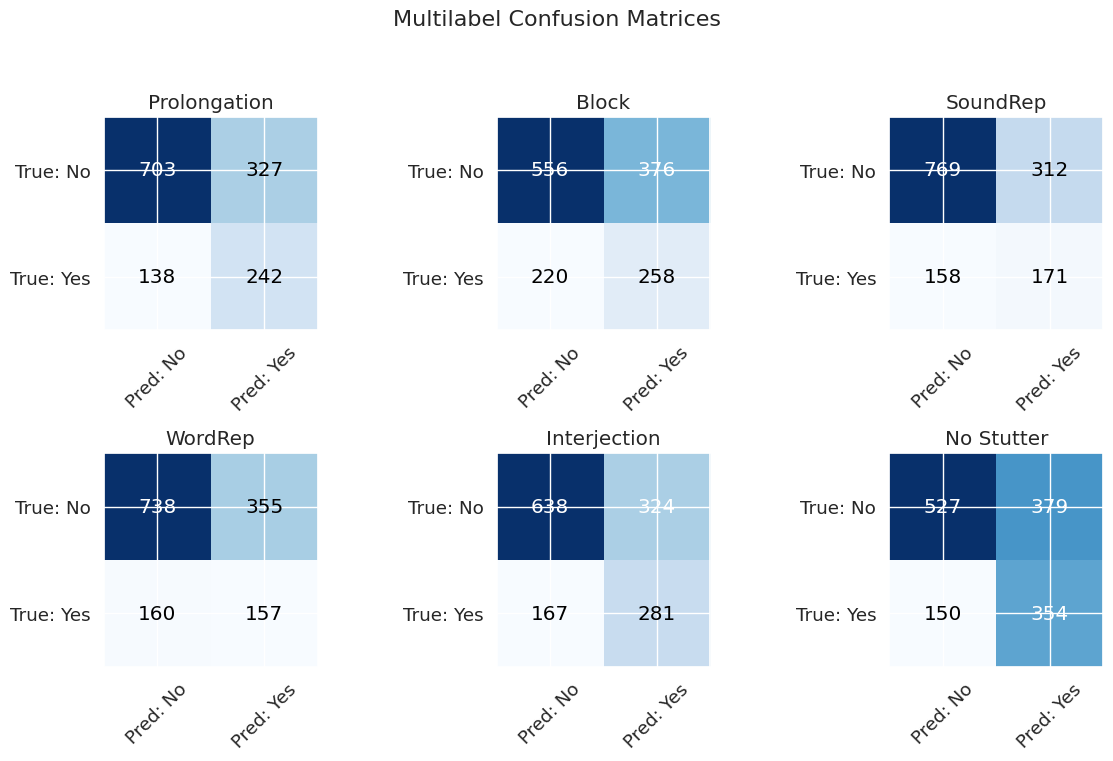


Classification Report:
              precision    recall  f1-score   support

Prolongation       0.43      0.64      0.51       380
       Block       0.41      0.54      0.46       478
    SoundRep       0.35      0.52      0.42       329
     WordRep       0.31      0.50      0.38       317
Interjection       0.46      0.63      0.53       448
  No Stutter       0.48      0.70      0.57       504

   micro avg       0.41      0.60      0.49      2456
   macro avg       0.41      0.59      0.48      2456
weighted avg       0.42      0.60      0.49      2456
 samples avg       0.44      0.61      0.49      2456

Plotting training history...
Available history keys: ['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate']


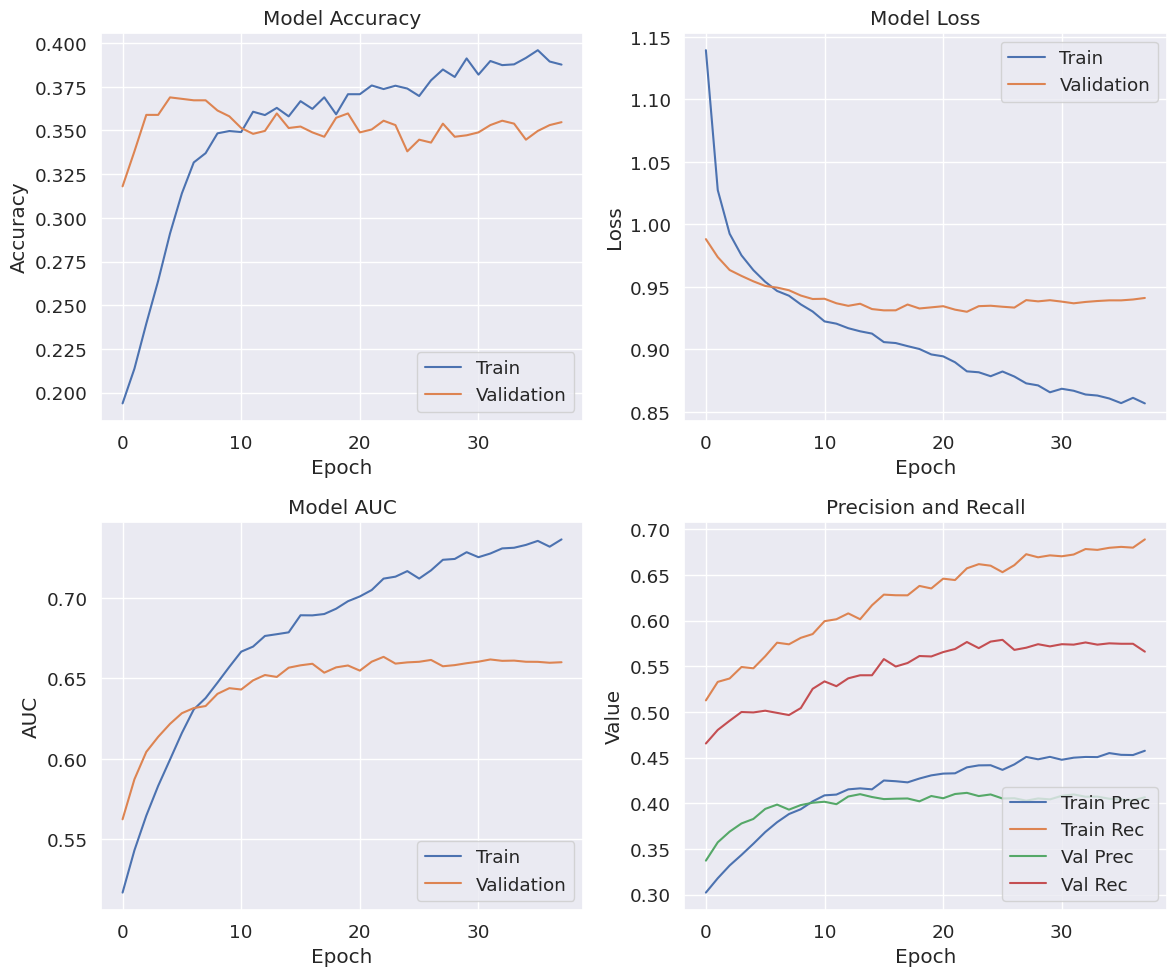

Analyzing feature importance...


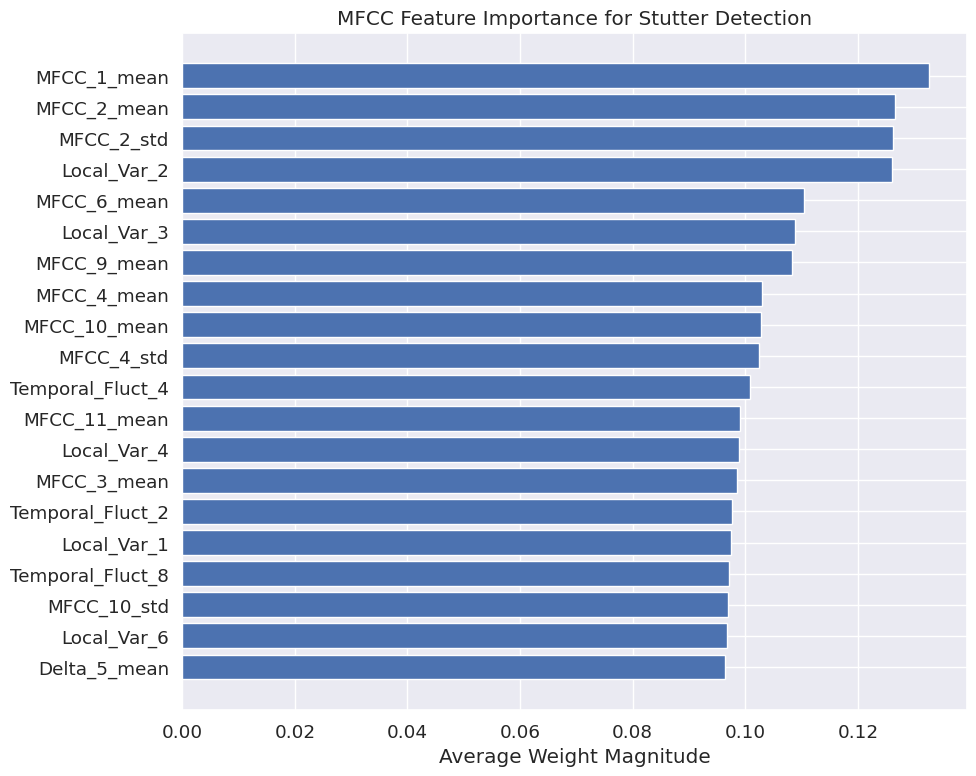


Top 10 MFCC Features for Stutter Detection:
MFCC_1_mean: 0.1327
MFCC_2_mean: 0.1265
MFCC_2_std: 0.1263
Local_Var_2: 0.1261
MFCC_6_mean: 0.1104
Local_Var_3: 0.1088
MFCC_9_mean: 0.1083
MFCC_4_mean: 0.1029
MFCC_10_mean: 0.1027
MFCC_4_std: 0.1023
Saving model...
MFCC-based stutter classification pipeline completed successfully!


In [10]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import warnings
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc  # Garbage collector
import IPython.display as ipd
import traceback

# Suppress warnings
warnings.filterwarnings('ignore')

def extract_mfcc_features(audio_path, sr=16000, n_mfcc=13, visualize=False):
    """
    Enhanced MFCC feature extraction with optimized parameters for stutter detection

    Parameters:
        audio_path (str): Path to the audio file
        sr (int): Sampling rate
        n_mfcc (int): Number of MFCC coefficients to extract
        visualize (bool): Whether to visualize the features

    Returns:
        dict: Dictionary containing MFCC features and statistics optimized for stutter detection
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr)

        # Apply pre-emphasis filter (standard in speech processing)
        y = librosa.effects.preemphasis(y, coef=0.97)

        # Extract MFCCs with optimized parameters for stuttering detection
        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=n_mfcc,
            n_fft=int(0.025*sr),    # 25ms window
            hop_length=int(0.010*sr), # 10ms hop
            lifter=22               # Emphasize lower-order coefficients
        )

        # Normalize MFCCs (important for stutter pattern recognition)
        mfcc = librosa.util.normalize(mfcc, axis=1)

        # Compute delta and delta-delta features (higher orders capture transitions)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

        # Compute temporal dynamics statistics (stutter correlates)
        temporal_fluctuation = np.std(np.diff(mfcc, axis=1), axis=1)

        # Calculate local variability (rapid changes indicate stutter)
        local_variability = []
        for i in range(mfcc.shape[0]):
            # Use rolling window of 5 frames (50ms)
            rolled = np.lib.stride_tricks.sliding_window_view(mfcc[i], 5)
            local_var = np.mean(np.var(rolled, axis=1))
            local_variability.append(local_var)

        # Create feature dictionary
        features = {
            'raw_audio': y,
            'sr': sr,
            'mfcc_raw': mfcc,
            'delta_raw': delta_mfcc,
            'delta2_raw': delta2_mfcc,
            'mfcc_mean': np.mean(mfcc, axis=1),
            'mfcc_std': np.std(mfcc, axis=1),
            'delta_mean': np.mean(delta_mfcc, axis=1),
            'delta_std': np.std(delta_mfcc, axis=1),
            'delta2_mean': np.mean(delta2_mfcc, axis=1),
            'delta2_std': np.std(delta2_mfcc, axis=1),
            'temporal_fluctuation': temporal_fluctuation,
            'local_variability': np.array(local_variability)
        }

        # Calculate transition metrics (repetition indicators)
        features['transition_rate'] = np.mean(np.abs(np.diff(mfcc, axis=1)))
        features['mfcc_stability'] = np.mean(temporal_fluctuation)

        # Visualize if requested
        if visualize:
            plt.figure(figsize=(14, 12))

            # Play audio
            print("Playing audio clip...")
            ipd.display(ipd.Audio(y, rate=sr))

            # Plot waveform
            plt.subplot(5, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title('Waveform')

            # Plot MFCC
            plt.subplot(5, 1, 2)
            librosa.display.specshow(mfcc, sr=sr, x_axis='time')
            plt.colorbar(format='%+2.0f')
            plt.title('MFCC Features')

            # Plot Delta MFCC
            plt.subplot(5, 1, 3)
            librosa.display.specshow(delta_mfcc, sr=sr, x_axis='time')
            plt.colorbar(format='%+2.0f')
            plt.title('Delta MFCC (Transitions)')

            # Plot temporal fluctuation (useful for spotting repetitions)
            plt.subplot(5, 1, 4)
            plt.bar(range(len(temporal_fluctuation)), temporal_fluctuation)
            plt.title('Temporal Fluctuation by Coefficient')
            plt.xlabel('MFCC Coefficient')
            plt.ylabel('Fluctuation')

            # Plot local variability
            plt.subplot(5, 1, 5)
            plt.bar(range(len(local_variability)), local_variability)
            plt.title('Local Variability (Stutter Indicator)')
            plt.xlabel('MFCC Coefficient')
            plt.ylabel('Variability')

            plt.tight_layout()
            plt.show()

            # Print key statistics
            print("\nMFCC Statistics for Stutter Detection:")
            print(f"Overall MFCC Stability: {features['mfcc_stability']:.4f}")
            print(f"Transition Rate: {features['transition_rate']:.4f}")
            print("\nIndividual Coefficients:")
            for i in range(n_mfcc):
                print(f"MFCC {i+1}: Mean = {features['mfcc_mean'][i]:.4f}, "
                      f"Std = {features['mfcc_std'][i]:.4f}, "
                      f"Fluctuation = {temporal_fluctuation[i]:.4f}")

        return features

    except Exception as e:
        print(f"Error extracting MFCC features: {str(e)}")
        traceback.print_exc()
        return None

def extract_mfcc_feature_vector(audio_path, sr=16000, n_mfcc=13):
    """
    Extract a flat feature vector from MFCC features for model input
    """
    try:
        # Extract MFCC features
        features = extract_mfcc_features(audio_path, sr=sr, n_mfcc=n_mfcc, visualize=False)

        if features is None:
            return None

        # Create feature vector suitable for model input
        feature_vector = np.concatenate([
            features['mfcc_mean'],
            features['mfcc_std'],
            features['delta_mean'],
            features['delta2_mean'],
            features['temporal_fluctuation'],
            features['local_variability'],
            [features['transition_rate']],
            [features['mfcc_stability']]
        ])

        return feature_vector

    except Exception as e:
        print(f"Error extracting feature vector from {audio_path}: {str(e)}")
        return None

def batch_process_clips(clips_df, batch_size=100, n_mfcc=13):
    """Process clips in batches to avoid memory issues"""
    all_features = []
    all_labels = []

    total_batches = len(clips_df) // batch_size + (1 if len(clips_df) % batch_size > 0 else 0)

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(clips_df))

        batch_df = clips_df.iloc[start_idx:end_idx]

        print(f"Processing batch {batch_idx+1}/{total_batches} (clips {start_idx+1}-{end_idx})")

        # Extract features for this batch
        batch_results = []
        for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx+1}"):
            feature_vector = extract_mfcc_feature_vector(row['file_path'], n_mfcc=n_mfcc)
            if feature_vector is not None:
                batch_results.append((feature_vector, row[3:9]))

        # Add valid results to our lists
        for features, label in batch_results:
            all_features.append(features)
            all_labels.append(label)

        # Force garbage collection to free memory
        gc.collect()

    if len(all_features) == 0:
        raise ValueError("No valid features extracted. Check your audio files and paths.")

    # Convert features to arrays
    features_array = np.array(all_features)
    labels = np.array(all_labels)
    print(labels.shape)

    return features_array, labels

def prepare_dataset(features_array, labels):
    """Prepare train/val/test datasets with proper scaling"""
    # First split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        features_array, labels, test_size=0.15, random_state=42, stratify=labels
    )

    # Then split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )

    # Standardize features based on training set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")

    print(y_train.shape)
    # Print class distribution
    print(f"Class distribution in training set: {np.sum(y_train, axis = 0)}")
    print(f"Class distribution in validation set: {np.sum(y_val, axis = 0)}")
    print(f"Class distribution in testing set: {np.sum(y_test, axis = 0)}")

    # Save scaler for future use
    from joblib import dump
    dump(scaler, 'mfcc_feature_scaler.joblib')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def build_model(input_shape, loss_fn='binary_crossentropy'):
    """Build DNN model for stutter detection using MFCC features"""

    model = Sequential([
        # Input layer - adapted for MFCC features which typically have higher dimensionality
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),

        # Hidden layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(6, activation='sigmoid')
    ])

    # Compile model with explicitly named metrics
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    # Show model summary
    model.summary()

    return model

def get_weighted_binary_crossentropy(class_weights):
    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        loss = - (class_weights_tensor * y_true * tf.math.log(y_pred + 1e-7) +
                  (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))
        return tf.reduce_mean(loss)

    return loss_fn

def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with early stopping and LR reduction"""

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    # Train model
    y_train = np.array(y_train, dtype=np.int32)
    y_val = np.array(y_val, dtype=np.int32)
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    print("Evaluating model on test set...")
    y_test = np.array(y_test, dtype=np.int32)
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Display confusion matrix
    cm = multilabel_confusion_matrix(y_test, y_pred)
    labels = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection', 'No Stutter']


    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns
    axes = axes.flatten()

    for i in range(len(labels)):
        ax = axes[i]
        matrix = cm[i]
        im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

        # Axis settings
        ax.set_title(labels[i])
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Pred: No', 'Pred: Yes'], rotation=45)
        ax.set_yticklabels(['True: No', 'True: Yes'])

        # Text annotations with dynamic color
        thresh = matrix.max() / 2.
        for j in range(2):
            for k in range(2):
                ax.text(k, j, format(matrix[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if matrix[j, k] > thresh else "black")

    # Layout & labels
    fig.suptitle('Multilabel Confusion Matrices', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    return y_pred

def plot_training_history(history):
    """Plot training metrics"""
    # First, print available keys to debug
    print("Available history keys:", list(history.history.keys()))

    plt.figure(figsize=(12, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot Precision/Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['precision'])
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_precision'])
    plt.plot(history.history['val_recall'])
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(['Train Prec', 'Train Rec', 'Val Prec', 'Val Rec'], loc='lower right')

    plt.tight_layout()
    plt.show()

def analyze_feature_importance(model, feature_names):
    """Analyze which MFCC features are most important for stutter detection"""
    # For a DNN, we can examine the weights of the first layer
    weights = model.layers[0].get_weights()[0]

    # Calculate average absolute weight for each feature
    importance = np.mean(np.abs(weights), axis=1)

    # Pair feature names with their importance
    feature_importance = list(zip(feature_names, importance))

    # Sort by importance (descending)
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    features, importance = zip(*feature_importance[:20])  # Top 20 features
    plt.barh(features, importance)
    plt.xlabel('Average Weight Magnitude')
    plt.title('MFCC Feature Importance for Stutter Detection')
    plt.gca().invert_yaxis()  # Display most important at the top
    plt.tight_layout()
    plt.show()

    print("\nTop 10 MFCC Features for Stutter Detection:")
    for feature, imp in feature_importance[:10]:
        print(f"{feature}: {imp:.4f}")

    return feature_importance

def run_mfcc_stutter_classification(clips_df, n_mfcc=13):
    """End-to-end MFCC-based stutter classification pipeline"""
    # Check if cached features exist
    if os.path.exists('mfcc_features.npy') and os.path.exists('mfcc_labels.npy'):
        print("Loading pre-extracted features...")
        features_array = np.load('mfcc_features.npy', allow_pickle=True)
        labels = np.load('mfcc_labels.npy', allow_pickle=True)
    else:
    # 1. Extract features
        print("Extracting MFCC features...")
        features_array, labels = batch_process_clips(clips_df, n_mfcc=n_mfcc)

        # Save extracted features to avoid reprocessing
        print("Saving extracted features...")
        np.save('mfcc_features.npy', features_array)
        np.save('mfcc_labels.npy', labels)

    # 2. Prepare datasets
    print("Preparing train/val/test datasets...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_array, labels)

    pos_counts = np.sum(y_train, axis=0)
    neg_counts = y_train.shape[0] - pos_counts
    class_weights = neg_counts / (pos_counts + 1e-6)

    loss_fn = get_weighted_binary_crossentropy(class_weights)

    # 3. Build model
    print("Building model...")
    model = build_model(X_train.shape[1], loss_fn)

    # 4. Train model
    print("Training model...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)

    # 5. Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X_test, y_test)

    # 6. Plot training history
    print("Plotting training history...")
    plot_training_history(history)

    # 7. Analyze feature importance
    print("Analyzing feature importance...")
    # Create feature names
    feature_names = []
    for i in range(n_mfcc):
        feature_names.append(f"MFCC_{i+1}_mean")
    for i in range(n_mfcc):
        feature_names.append(f"MFCC_{i+1}_std")
    for i in range(n_mfcc):
        feature_names.append(f"Delta_{i+1}_mean")
    for i in range(n_mfcc):
        feature_names.append(f"Delta2_{i+1}_mean")
    for i in range(n_mfcc):
        feature_names.append(f"Temporal_Fluct_{i+1}")
    for i in range(n_mfcc):
        feature_names.append(f"Local_Var_{i+1}")
    feature_names.append("Transition_Rate")
    feature_names.append("MFCC_Stability")

    analyze_feature_importance(model, feature_names)

    # 8. Save model
    print("Saving model...")
    model.save('mfcc_stutter_detection_model.h5')

    return model, features_array

# Function to test a single clip
def test_single_clip(clip_path, model, scaler, n_mfcc=13):
    """Test the model on a single clip"""
    print(f"Testing clip: {clip_path}")

    # Extract features
    features = extract_mfcc_features(clip_path, n_mfcc=n_mfcc, visualize=True)

    if features is None:
        print("Failed to extract features from the clip")
        return

    # Create feature vector
    feature_vector = np.concatenate([
        features['mfcc_mean'],
        features['mfcc_std'],
        features['delta_mean'],
        features['delta2_mean'],
        features['temporal_fluctuation'],
        features['local_variability'],
        [features['transition_rate']],
        [features['mfcc_stability']]
    ])

    # Scale features
    feature_vector_scaled = scaler.transform(feature_vector.reshape(1, -1))

    # Predict
    pred_prob = model.predict(feature_vector_scaled)[0][0]
    prediction = "Stutter" if pred_prob > 0.5 else "No Stutter"

    print(f"\nPrediction: {prediction} (Confidence: {pred_prob:.2f})")
    print("Stutter indicators:")
    print(f"- MFCC Stability: {features['mfcc_stability']:.4f} (Lower values suggest more stuttering)")
    print(f"- Transition Rate: {features['transition_rate']:.4f} (Higher values suggest more stuttering)")

    return prediction, pred_prob

# Run the pipeline
try:
    # Check if model already exists
    if os.path.exists('mfcc_stutter_detection_model.h5') and os.path.exists('mfcc_feature_scaler.joblib'):
        print("Loading existing model and scaler...")
        from tensorflow.keras.models import load_model
        from joblib import load
        model = load_model('mfcc_stutter_detection_model.h5')
        scaler = load('mfcc_feature_scaler.joblib')

        # Ask if user wants to test a single clip
        test_clip = input("Do you want to test a single clip? (y/n): ")
        if test_clip.lower() == 'y':
            clip_path = input("Enter the path to the audio clip: ")
            test_single_clip(clip_path, model, scaler)
        else:
          model, features_array = run_mfcc_stutter_classification(clips_df)
          print("MFCC-based stutter classification pipeline completed successfully!")
    else:
        model, features_array = run_mfcc_stutter_classification(clips_df)
        print("MFCC-based stutter classification pipeline completed successfully!")

except Exception as e:
    print(f"Error in MFCC-based stutter classification pipeline: {str(e)}")
    traceback.print_exc()


Extracting prosodic features...
Processing batch 1/19 (clips 1-500)


Batch 1: 100%|██████████| 500/500 [04:17<00:00,  1.94it/s]


Processing batch 2/19 (clips 501-1000)


Batch 2: 100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


Processing batch 3/19 (clips 1001-1500)


Batch 3: 100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


Processing batch 4/19 (clips 1501-2000)


Batch 4: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


Processing batch 5/19 (clips 2001-2500)


Batch 5: 100%|██████████| 500/500 [04:22<00:00,  1.91it/s]


Processing batch 6/19 (clips 2501-3000)


Batch 6: 100%|██████████| 500/500 [04:15<00:00,  1.96it/s]


Processing batch 7/19 (clips 3001-3500)


Batch 7: 100%|██████████| 500/500 [04:12<00:00,  1.98it/s]


Processing batch 8/19 (clips 3501-4000)


Batch 8: 100%|██████████| 500/500 [04:13<00:00,  1.98it/s]


Processing batch 9/19 (clips 4001-4500)


Batch 9: 100%|██████████| 500/500 [04:12<00:00,  1.98it/s]


Processing batch 10/19 (clips 4501-5000)


Batch 10: 100%|██████████| 500/500 [04:10<00:00,  2.00it/s]


Processing batch 11/19 (clips 5001-5500)


Batch 11: 100%|██████████| 500/500 [04:10<00:00,  1.99it/s]


Processing batch 12/19 (clips 5501-6000)


Batch 12: 100%|██████████| 500/500 [04:09<00:00,  2.01it/s]


Processing batch 13/19 (clips 6001-6500)


Batch 13: 100%|██████████| 500/500 [04:09<00:00,  2.00it/s]


Processing batch 14/19 (clips 6501-7000)


Batch 14: 100%|██████████| 500/500 [04:08<00:00,  2.01it/s]


Processing batch 15/19 (clips 7001-7500)


Batch 15: 100%|██████████| 500/500 [04:08<00:00,  2.01it/s]


Processing batch 16/19 (clips 7501-8000)


Batch 16: 100%|██████████| 500/500 [04:09<00:00,  2.00it/s]


Processing batch 17/19 (clips 8001-8500)


Batch 17: 100%|██████████| 500/500 [04:09<00:00,  2.01it/s]


Processing batch 18/19 (clips 8501-9000)


Batch 18: 100%|██████████| 500/500 [04:12<00:00,  1.98it/s]


Processing batch 19/19 (clips 9001-9394)


Batch 19: 100%|██████████| 394/394 [03:16<00:00,  2.00it/s]


Saving extracted features...
Preparing train/val/test datasets...
Training set: 6786 samples
Validation set: 1198 samples
Testing set: 1410 samples
Features: 13
(6786, 6)
Class distribution in training set: [1834 2304 1585 1535 2157 2424]
Class distribution in validation set: [324 406 279 269 382 428]
Class distribution in testing set: [380 478 329 317 448 504]
Building model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,222 (51.65 KB)

 Trainable params: 12,774 (49.90 KB)

 Non-trainable params: 448 (1.75 KB)

Training model...
Training model...
Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.1953 - auc: 0.5178 - loss: 1.1940 - precision: 0.3014 - recall: 0.5291 - val_accuracy: 0.3397 - val_auc: 0.5586 - val_loss: 0.9786 - val_precision: 0.3209 - val_recall: 0.6015 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2120 - auc: 0.5534 - loss: 1.0298 - precision: 0.3239 - recall: 0.5476 - val_accuracy: 0.3072 - val_auc: 0.5963 - val_loss: 0.9645 - val_precision: 0.3506 - val_recall: 0.5991 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2451 - auc: 0.5751 - loss: 0.9906 - precision: 0.3393 - recall: 0.5637 - val_accuracy: 0.3289 - val_auc: 0.6034 - val_loss: 0.9599 - val_precision: 0.3611 - val_recall: 0.5833 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2622 - auc: 0.5853 - loss: 0.9747 - precision: 0.3441 - recall: 0.5606 - val_accuracy: 0.3322 

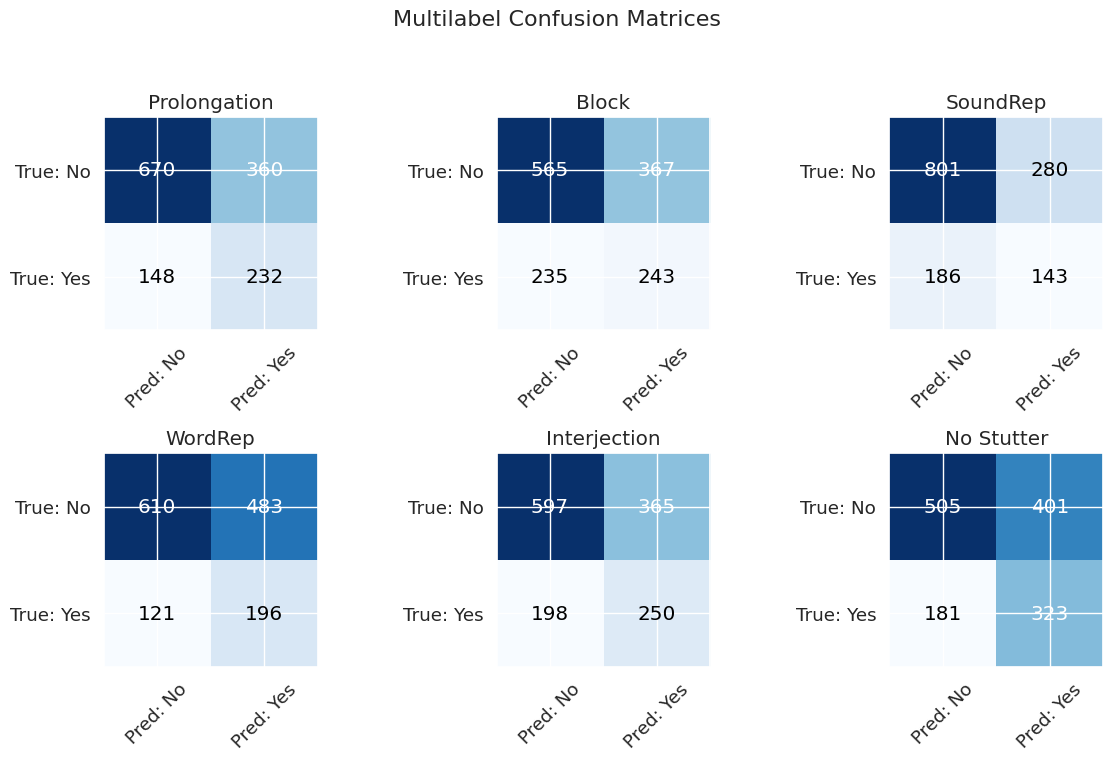


Classification Report:
              precision    recall  f1-score   support

Prolongation       0.39      0.61      0.48       380
       Block       0.40      0.51      0.45       478
    SoundRep       0.34      0.43      0.38       329
     WordRep       0.29      0.62      0.39       317
Interjection       0.41      0.56      0.47       448
  No Stutter       0.45      0.64      0.53       504

   micro avg       0.38      0.56      0.45      2456
   macro avg       0.38      0.56      0.45      2456
weighted avg       0.39      0.56      0.46      2456
 samples avg       0.39      0.59      0.45      2456

Plotting training history...


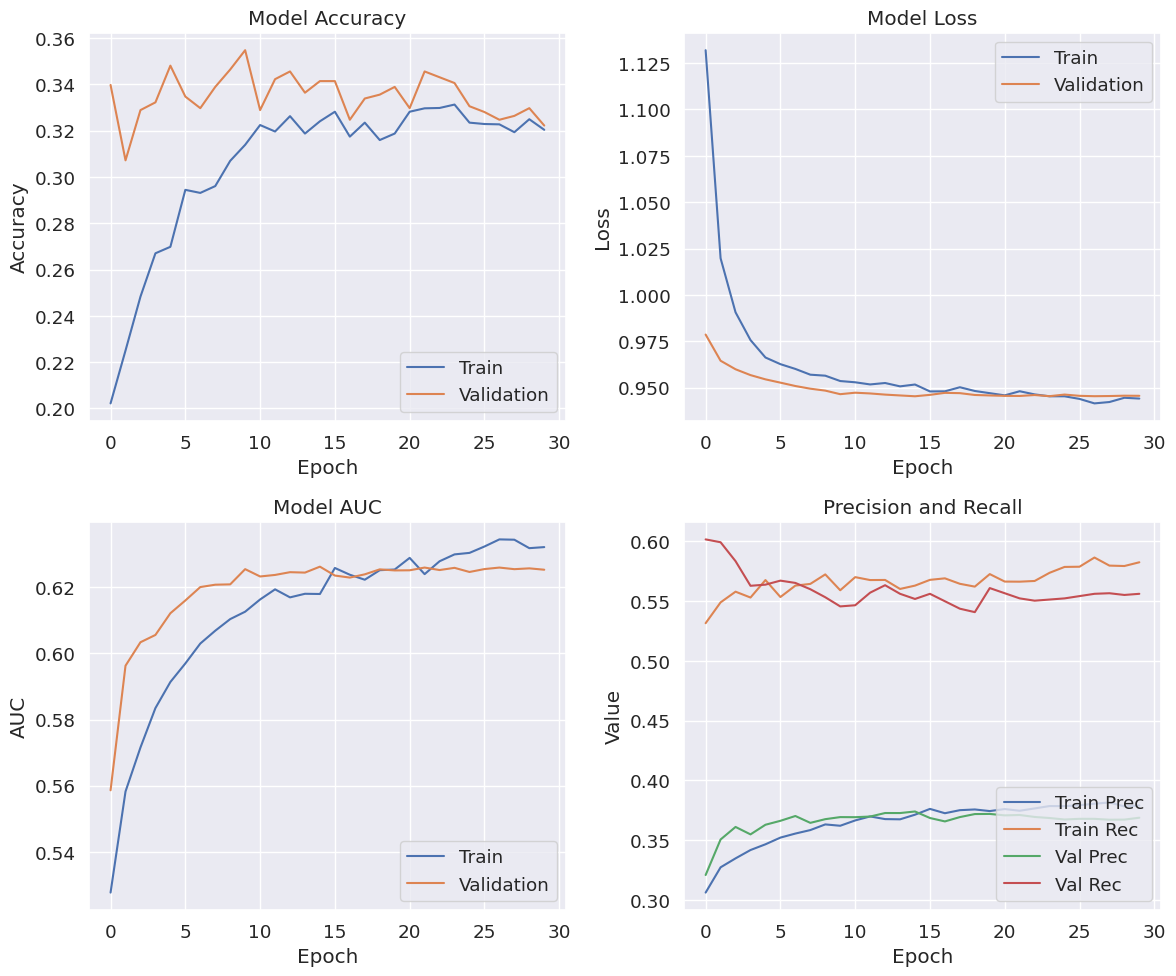

Analyzing feature importance...


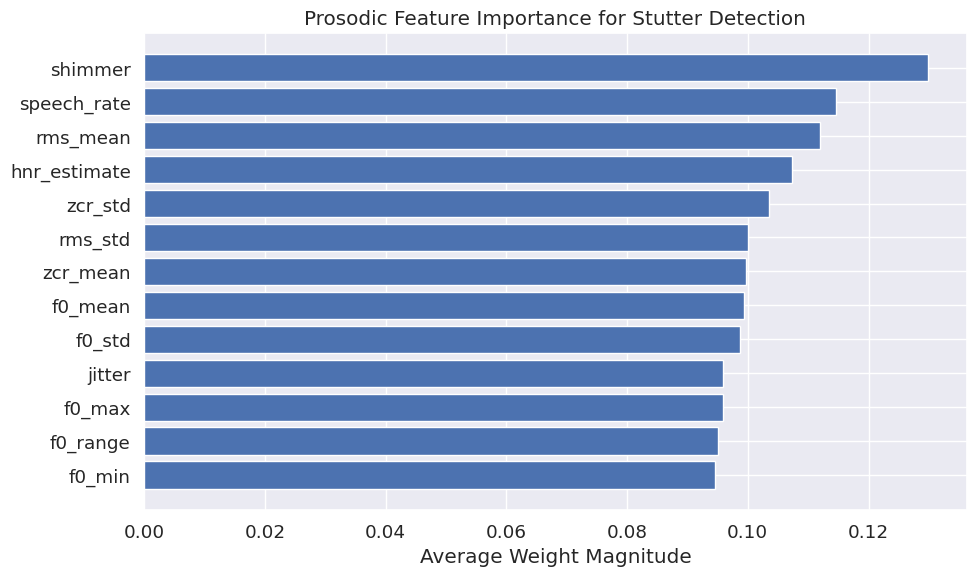


Feature Importance Ranking:
shimmer: 0.1298
speech_rate: 0.1146
rms_mean: 0.1119
hnr_estimate: 0.1073
zcr_std: 0.1036
rms_std: 0.1001
zcr_mean: 0.0997
f0_mean: 0.0994
f0_std: 0.0988
jitter: 0.0959
f0_max: 0.0959
f0_range: 0.0951
f0_min: 0.0946
Saving model...
Stutter classification pipeline completed successfully!


In [11]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import warnings
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc  # Garbage collector

# Suppress warnings
warnings.filterwarnings('ignore')

def extract_prosodic_features(audio_path, sr=16000):
    """
    Extract prosodic features with robust error handling
    """
    try:
        # Load audio file with error checking
        try:
            y, sr = librosa.load(audio_path, sr=sr)
            # Check if audio is valid
            if len(y) == 0 or np.isnan(y).any() or np.isinf(y).any():
                print(f"Invalid audio in {audio_path}: empty or contains invalid values")
                return None
        except Exception as e:
            print(f"Error loading {audio_path}: {str(e)}")
            return None

        # Apply pre-emphasis filter
        y = librosa.effects.preemphasis(y, coef=0.97)

        # Initialize feature dictionary with default values
        features = {
            'f0_mean': 0, 'f0_std': 0, 'f0_min': 0, 'f0_max': 0, 'f0_range': 0,
            'rms_mean': 0, 'rms_std': 0, 'zcr_mean': 0, 'zcr_std': 0,
            'speech_rate': 0, 'jitter': 0, 'shimmer': 0, 'hnr_estimate': -60
        }

        # Extract pitch (F0) using pYIN algorithm with error handling
        try:
            f0, voiced_flag, _ = librosa.pyin(
                y, fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C7'), sr=sr
            )

            # Handle NaN values in f0
            f0_valid = f0[~np.isnan(f0)] if len(f0[~np.isnan(f0)]) > 0 else np.array([0])

            if len(f0_valid) > 0:
                features['f0_mean'] = float(np.mean(f0_valid))
                features['f0_std'] = float(np.std(f0_valid))
                features['f0_min'] = float(np.min(f0_valid))
                features['f0_max'] = float(np.max(f0_valid))
                features['f0_range'] = float(features['f0_max'] - features['f0_min'])
        except Exception as e:
            print(f"Error extracting pitch from {audio_path}: {str(e)}")

        # Extract energy (RMS)
        try:
            rms = librosa.feature.rms(y=y)[0]
            if len(rms) > 0:
                features['rms_mean'] = float(np.mean(rms))
                features['rms_std'] = float(np.std(rms))
        except Exception as e:
            print(f"Error extracting RMS from {audio_path}: {str(e)}")

        # Extract zero-crossing rate
        try:
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            if len(zcr) > 0:
                features['zcr_mean'] = float(np.mean(zcr))
                features['zcr_std'] = float(np.std(zcr))
        except Exception as e:
            print(f"Error extracting ZCR from {audio_path}: {str(e)}")

        # Extract speech rate
        try:
            onsets = librosa.onset.onset_detect(y=y, sr=sr)
            features['speech_rate'] = float(len(onsets) / (len(y) / sr)) if len(onsets) > 0 else 0
        except Exception as e:
            print(f"Error extracting speech rate from {audio_path}: {str(e)}")

        # Extract jitter (cycle-to-cycle frequency variation)
        try:
            if len(f0_valid) > 1 and np.mean(f0_valid) > 0:
                f0_diff = np.abs(np.diff(f0_valid))
                features['jitter'] = float(np.mean(f0_diff) / np.mean(f0_valid))
        except Exception as e:
            print(f"Error extracting jitter from {audio_path}: {str(e)}")

        # Extract shimmer (cycle-to-cycle amplitude variation)
        try:
            amplitude_env = librosa.feature.rms(y=y, frame_length=256, hop_length=128)[0]
            if len(amplitude_env) > 1 and np.mean(amplitude_env) > 0:
                amp_diff = np.abs(np.diff(amplitude_env))
                features['shimmer'] = float(np.mean(amp_diff) / np.mean(amplitude_env))
        except Exception as e:
            print(f"Error extracting shimmer from {audio_path}: {str(e)}")

        # Extract HNR
        try:
            S = np.abs(librosa.stft(y))
            S_db = librosa.amplitude_to_db(S, ref=np.max)
            features['hnr_estimate'] = float(np.mean(S_db)) if np.mean(S_db) != -np.inf else -60
        except Exception as e:
            print(f"Error extracting HNR from {audio_path}: {str(e)}")

        # Make sure all values are finite
        for key in features:
            if not np.isfinite(features[key]):
                features[key] = 0.0

        return features

    except Exception as e:
        print(f"Unexpected error in feature extraction for {audio_path}: {str(e)}")
        return None

def batch_process_clips(clips_df, batch_size=500):
    """Process clips in batches to avoid memory issues"""
    all_features = []
    all_labels = []

    total_batches = len(clips_df) // batch_size + (1 if len(clips_df) % batch_size > 0 else 0)

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(clips_df))

        batch_df = clips_df.iloc[start_idx:end_idx]

        print(f"Processing batch {batch_idx+1}/{total_batches} (clips {start_idx+1}-{end_idx})")

        # Extract features for this batch
        batch_results = []
        for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx+1}"):
            features = extract_prosodic_features(row['file_path'])
            if features is not None:
                batch_results.append((features, row[3:9]))

        # Add valid results to our lists
        for features, label in batch_results:
            all_features.append(features)
            all_labels.append(label)

        # Force garbage collection to free memory
        gc.collect()

    if len(all_features) == 0:
        raise ValueError("No valid features extracted. Check your audio files and paths.")

    # Convert features to DataFrame
    features_df = pd.DataFrame(all_features)
    labels = np.array(all_labels)

    return features_df, labels

def prepare_dataset(features_array, labels):
    """Prepare train/val/test datasets with proper scaling"""
    # First split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        features_array, labels, test_size=0.15, random_state=42, stratify=labels
    )

    # Then split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )

    # Standardize features based on training set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")

    print(y_train.shape)
    # Print class distribution
    print(f"Class distribution in training set: {np.sum(y_train, axis = 0)}")
    print(f"Class distribution in validation set: {np.sum(y_val, axis = 0)}")
    print(f"Class distribution in testing set: {np.sum(y_test, axis = 0)}")

    # Save scaler for future use
    from joblib import dump
    dump(scaler, 'mfcc_feature_scaler.joblib')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def get_weighted_binary_crossentropy(class_weights):
    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        loss = - (class_weights_tensor * y_true * tf.math.log(y_pred + 1e-7) +
                  (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))
        return tf.reduce_mean(loss)

    return loss_fn

def build_model(input_shape, loss_fn = 'binary_crossentropy'):
    """Build DNN model for stutter detection using MFCC features"""
    model = Sequential([
        # Input layer - adapted for MFCC features which typically have higher dimensionality
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),

        # Hidden layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(6, activation='sigmoid')
    ])

    # Compile model with explicitly named metrics
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    # Show model summary
    model.summary()

    return model

def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with early stopping and LR reduction"""
    # Calculate class weights for imbalanced dataset
    from sklearn.utils.class_weight import compute_class_weight

    # n_classes = y_train.shape[1]
    # class_weights = {}

    # for i in range(n_classes):
    #     labels = y_train[:, i]  # Get all labels for class i (0 or 1)
    #     weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels)
    #     class_weights[i] = dict(zip([0, 1], weights))


    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    # Train model
    y_train = np.array(y_train, dtype=np.int32)
    y_val = np.array(y_val, dtype=np.int32)
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    print("Evaluating model on test set...")
    y_test = np.array(y_test, dtype=np.int32)
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Display confusion matrix
    cm = multilabel_confusion_matrix(y_test, y_pred)
    labels = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection', 'No Stutter']


    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns
    axes = axes.flatten()

    for i in range(len(labels)):
        ax = axes[i]
        matrix = cm[i]
        im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

        # Axis settings
        ax.set_title(labels[i])
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Pred: No', 'Pred: Yes'], rotation=45)
        ax.set_yticklabels(['True: No', 'True: Yes'])

        # Text annotations with dynamic color
        thresh = matrix.max() / 2.
        for j in range(2):
            for k in range(2):
                ax.text(k, j, format(matrix[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if matrix[j, k] > thresh else "black")

    # Layout & labels
    fig.suptitle('Multilabel Confusion Matrices', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    return y_pred

def plot_training_history(history):
    """Plot training metrics"""
    plt.figure(figsize=(12, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot Precision/Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['precision'])
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_precision'])
    plt.plot(history.history['val_recall'])
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(['Train Prec', 'Train Rec', 'Val Prec', 'Val Rec'], loc='lower right')

    plt.tight_layout()
    plt.show()

def analyze_feature_importance(model, feature_names):
    """Analyze which prosodic features are most important"""
    # For a DNN, we can examine the weights of the first layer
    weights = model.layers[0].get_weights()[0]

    # Calculate average absolute weight for each feature
    importance = np.mean(np.abs(weights), axis=1)

    # Pair feature names with their importance
    feature_importance = list(zip(feature_names, importance))

    # Sort by importance (descending)
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    features, importance = zip(*feature_importance)
    plt.barh(features, importance)
    plt.xlabel('Average Weight Magnitude')
    plt.title('Prosodic Feature Importance for Stutter Detection')
    plt.gca().invert_yaxis()  # Display most important at the top
    plt.tight_layout()
    plt.show()

    print("\nFeature Importance Ranking:")
    for feature, imp in feature_importance:
        print(f"{feature}: {imp:.4f}")

    return feature_importance

def run_stutter_classification(clips_df):
    """End-to-end stutter classification pipeline"""
    # 1. Extract features (with batch processing to prevent memory issues)
    print("Extracting prosodic features...")
    features_df, labels = batch_process_clips(clips_df)

    # 2. Save extracted features to avoid reprocessing
    print("Saving extracted features...")
    features_df.to_csv('prosodic_features.csv', index=False)
    np.save('prosodic_labels.npy', labels)

    # 3. Prepare datasets
    print("Preparing train/val/test datasets...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_df, labels)

    pos_counts = np.sum(y_train, axis=0)
    neg_counts = y_train.shape[0] - pos_counts
    class_weights = neg_counts / (pos_counts + 1e-6)

    loss_fn = get_weighted_binary_crossentropy(class_weights)

    # 4. Build model
    print("Building model...")
    model = build_model(X_train.shape[1], loss_fn)

    # 5. Train model
    print("Training model...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)

    # 6. Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X_test, y_test)

    # 7. Plot training history
    print("Plotting training history...")
    plot_training_history(history)

    # 8. Analyze feature importance
    print("Analyzing feature importance...")
    analyze_feature_importance(model, features_df.columns)

    # 9. Save model
    print("Saving model...")
    model.save('stutter_detection_model.h5')

    return model, features_df


# Skip feature extraction if features are already saved
if os.path.exists('prosodic_features.csv') and os.path.exists('prosodic_labels.npy'):
    print("Loading pre-extracted features...")
    features_df = pd.read_csv('prosodic_features.csv')
    labels = np.load('prosodic_labels.npy', allow_pickle=True)

    # Proceed with model training
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_df, labels)
    model = build_model(X_train.shape[1])
    model, history = train_model(model, X_train, y_train, X_val, y_val)
    evaluate_model(model, X_test, y_test)
    plot_training_history(history)
    analyze_feature_importance(model, features_df.columns)
    model.save('stutter_detection_model.h5')
else:
    model, features_df = run_stutter_classification(clips_df)

print("Stutter classification pipeline completed successfully!")


Extracting word-level features...
Processing batch 1/94 (clips 1-100)


Batch 1: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Processing batch 2/94 (clips 101-200)


Batch 2: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


Processing batch 3/94 (clips 201-300)


Batch 3: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Processing batch 4/94 (clips 301-400)


Batch 4: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Processing batch 5/94 (clips 401-500)


Batch 5: 100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Processing batch 6/94 (clips 501-600)


Batch 6: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Processing batch 7/94 (clips 601-700)


Batch 7: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Processing batch 8/94 (clips 701-800)


Batch 8: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Processing batch 9/94 (clips 801-900)


Batch 9: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Processing batch 10/94 (clips 901-1000)


Batch 10: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Processing batch 11/94 (clips 1001-1100)


Batch 11: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Processing batch 12/94 (clips 1101-1200)


Batch 12: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Processing batch 13/94 (clips 1201-1300)


Batch 13: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Processing batch 14/94 (clips 1301-1400)


Batch 14: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Processing batch 15/94 (clips 1401-1500)


Batch 15: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Processing batch 16/94 (clips 1501-1600)


Batch 16: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Processing batch 17/94 (clips 1601-1700)


Batch 17: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Processing batch 18/94 (clips 1701-1800)


Batch 18: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


Processing batch 19/94 (clips 1801-1900)


Batch 19: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Processing batch 20/94 (clips 1901-2000)


Batch 20: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Processing batch 21/94 (clips 2001-2100)


Batch 21: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


Processing batch 22/94 (clips 2101-2200)


Batch 22: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Processing batch 23/94 (clips 2201-2300)


Batch 23: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Processing batch 24/94 (clips 2301-2400)


Batch 24: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Processing batch 25/94 (clips 2401-2500)


Batch 25: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Processing batch 26/94 (clips 2501-2600)


Batch 26: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Processing batch 27/94 (clips 2601-2700)


Batch 27: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Processing batch 28/94 (clips 2701-2800)


Batch 28: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Processing batch 29/94 (clips 2801-2900)


Batch 29: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


Processing batch 30/94 (clips 2901-3000)


Batch 30: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Processing batch 31/94 (clips 3001-3100)


Batch 31: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Processing batch 32/94 (clips 3101-3200)


Batch 32: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Processing batch 33/94 (clips 3201-3300)


Batch 33: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Processing batch 34/94 (clips 3301-3400)


Batch 34: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


Processing batch 35/94 (clips 3401-3500)


Batch 35: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


Processing batch 36/94 (clips 3501-3600)


Batch 36: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Processing batch 37/94 (clips 3601-3700)


Batch 37: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Processing batch 38/94 (clips 3701-3800)


Batch 38: 100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


Processing batch 39/94 (clips 3801-3900)


Batch 39: 100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


Processing batch 40/94 (clips 3901-4000)


Batch 40: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Processing batch 41/94 (clips 4001-4100)


Batch 41: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


Processing batch 42/94 (clips 4101-4200)


Batch 42: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Processing batch 43/94 (clips 4201-4300)


Batch 43: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


Processing batch 44/94 (clips 4301-4400)


Batch 44: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


Processing batch 45/94 (clips 4401-4500)


Batch 45: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Processing batch 46/94 (clips 4501-4600)


Batch 46: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Processing batch 47/94 (clips 4601-4700)


Batch 47: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Processing batch 48/94 (clips 4701-4800)


Batch 48: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Processing batch 49/94 (clips 4801-4900)


Batch 49: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Processing batch 50/94 (clips 4901-5000)


Batch 50: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Processing batch 51/94 (clips 5001-5100)


Batch 51: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Processing batch 52/94 (clips 5101-5200)


Batch 52: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


Processing batch 53/94 (clips 5201-5300)


Batch 53: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


Processing batch 54/94 (clips 5301-5400)


Batch 54: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Processing batch 55/94 (clips 5401-5500)


Batch 55: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Processing batch 56/94 (clips 5501-5600)


Batch 56: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Processing batch 57/94 (clips 5601-5700)


Batch 57: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Processing batch 58/94 (clips 5701-5800)


Batch 58: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Processing batch 59/94 (clips 5801-5900)


Batch 59: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Processing batch 60/94 (clips 5901-6000)


Batch 60: 100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


Processing batch 61/94 (clips 6001-6100)


Batch 61: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Processing batch 62/94 (clips 6101-6200)


Batch 62: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Processing batch 63/94 (clips 6201-6300)


Batch 63: 100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


Processing batch 64/94 (clips 6301-6400)


Batch 64: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Processing batch 65/94 (clips 6401-6500)


Batch 65: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Processing batch 66/94 (clips 6501-6600)


Batch 66: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Processing batch 67/94 (clips 6601-6700)


Batch 67: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Processing batch 68/94 (clips 6701-6800)


Batch 68: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


Processing batch 69/94 (clips 6801-6900)


Batch 69: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Processing batch 70/94 (clips 6901-7000)


Batch 70: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Processing batch 71/94 (clips 7001-7100)


Batch 71: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Processing batch 72/94 (clips 7101-7200)


Batch 72: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


Processing batch 73/94 (clips 7201-7300)


Batch 73: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Processing batch 74/94 (clips 7301-7400)


Batch 74: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Processing batch 75/94 (clips 7401-7500)


Batch 75: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


Processing batch 76/94 (clips 7501-7600)


Batch 76: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


Processing batch 77/94 (clips 7601-7700)


Batch 77: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Processing batch 78/94 (clips 7701-7800)


Batch 78: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


Processing batch 79/94 (clips 7801-7900)


Batch 79: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Processing batch 80/94 (clips 7901-8000)


Batch 80: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


Processing batch 81/94 (clips 8001-8100)


Batch 81: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Processing batch 82/94 (clips 8101-8200)


Batch 82: 100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


Processing batch 83/94 (clips 8201-8300)


Batch 83: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Processing batch 84/94 (clips 8301-8400)


Batch 84: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Processing batch 85/94 (clips 8401-8500)


Batch 85: 100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


Processing batch 86/94 (clips 8501-8600)


Batch 86: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


Processing batch 87/94 (clips 8601-8700)


Batch 87: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Processing batch 88/94 (clips 8701-8800)


Batch 88: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Processing batch 89/94 (clips 8801-8900)


Batch 89: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Processing batch 90/94 (clips 8901-9000)


Batch 90: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Processing batch 91/94 (clips 9001-9100)


Batch 91: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Processing batch 92/94 (clips 9101-9200)


Batch 92: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Processing batch 93/94 (clips 9201-9300)


Batch 93: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Processing batch 94/94 (clips 9301-9394)


Batch 94: 100%|██████████| 94/94 [00:16<00:00,  5.71it/s]


Saving extracted features...
Preparing train/val/test datasets...
Training set: 6786 samples
Validation set: 1198 samples
Testing set: 1410 samples
Features: 43
(6786, 6)
Class distribution in training set: [1834 2304 1585 1535 2157 2424]
Class distribution in validation set: [324 406 279 269 382 428]
Class distribution in testing set: [380 478 329 317 448 504]
Building model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,062 (66.65 KB)

 Trainable params: 16,614 (64.90 KB)

 Non-trainable params: 448 (1.75 KB)

Training model...
Training model...
Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.1742 - auc: 0.5142 - loss: 1.2093 - precision: 0.2960 - recall: 0.5108 - val_accuracy: 0.1369 - val_auc: 0.5359 - val_loss: 0.9865 - val_precision: 0.3164 - val_recall: 0.5201 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1962 - auc: 0.5355 - loss: 1.0449 - precision: 0.3086 - recall: 0.5311 - val_accuracy: 0.1962 - val_auc: 0.5666 - val_loss: 0.9748 - val_precision: 0.3296 - val_recall: 0.5311 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2049 - auc: 0.5541 - loss: 1.0079 - precision: 0.3260 - recall: 0.5460 - val_accuracy: 0.2053 - val_auc: 0.5693 - val_loss: 0.9687 - val_precision: 0.3272 - val_recall: 0.5278 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2313 - auc: 0.5613 - loss: 0.9867 - precision: 0.3233 - recall: 0.5419 - val_accuracy: 0.2371 

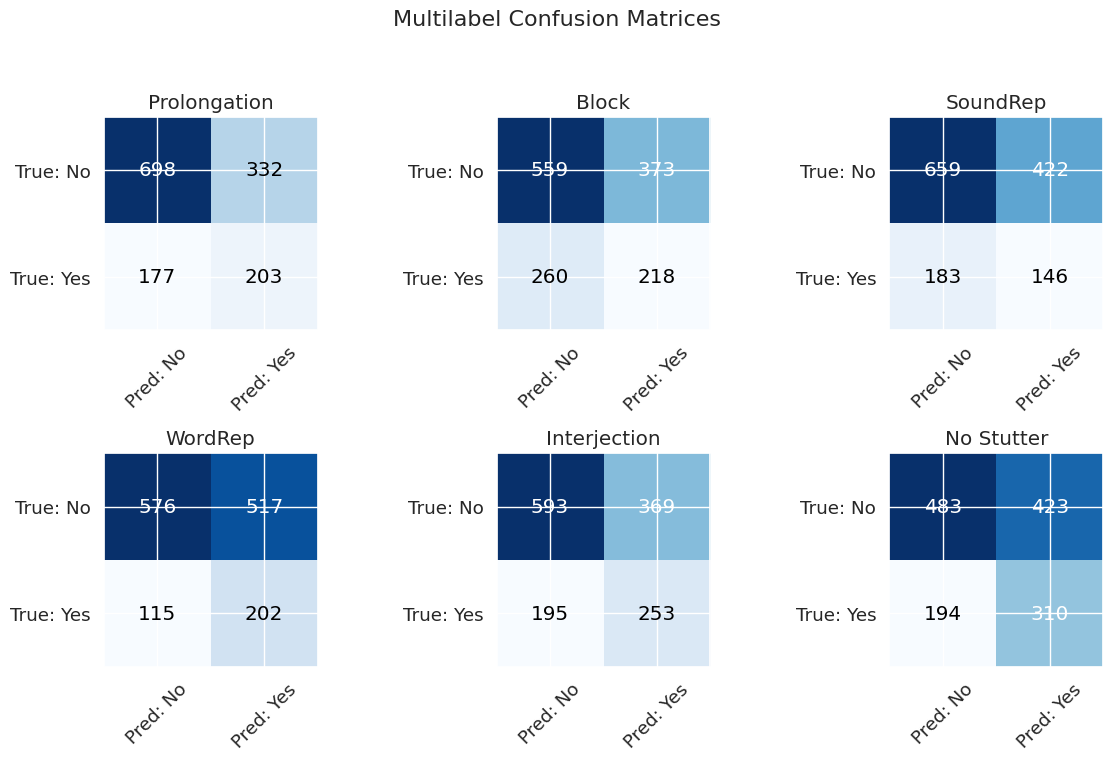


Classification Report:
              precision    recall  f1-score   support

Prolongation       0.38      0.53      0.44       380
       Block       0.37      0.46      0.41       478
    SoundRep       0.26      0.44      0.33       329
     WordRep       0.28      0.64      0.39       317
Interjection       0.41      0.56      0.47       448
  No Stutter       0.42      0.62      0.50       504

   micro avg       0.35      0.54      0.43      2456
   macro avg       0.35      0.54      0.42      2456
weighted avg       0.36      0.54      0.43      2456
 samples avg       0.36      0.56      0.42      2456

Plotting training history...
Available history keys: dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


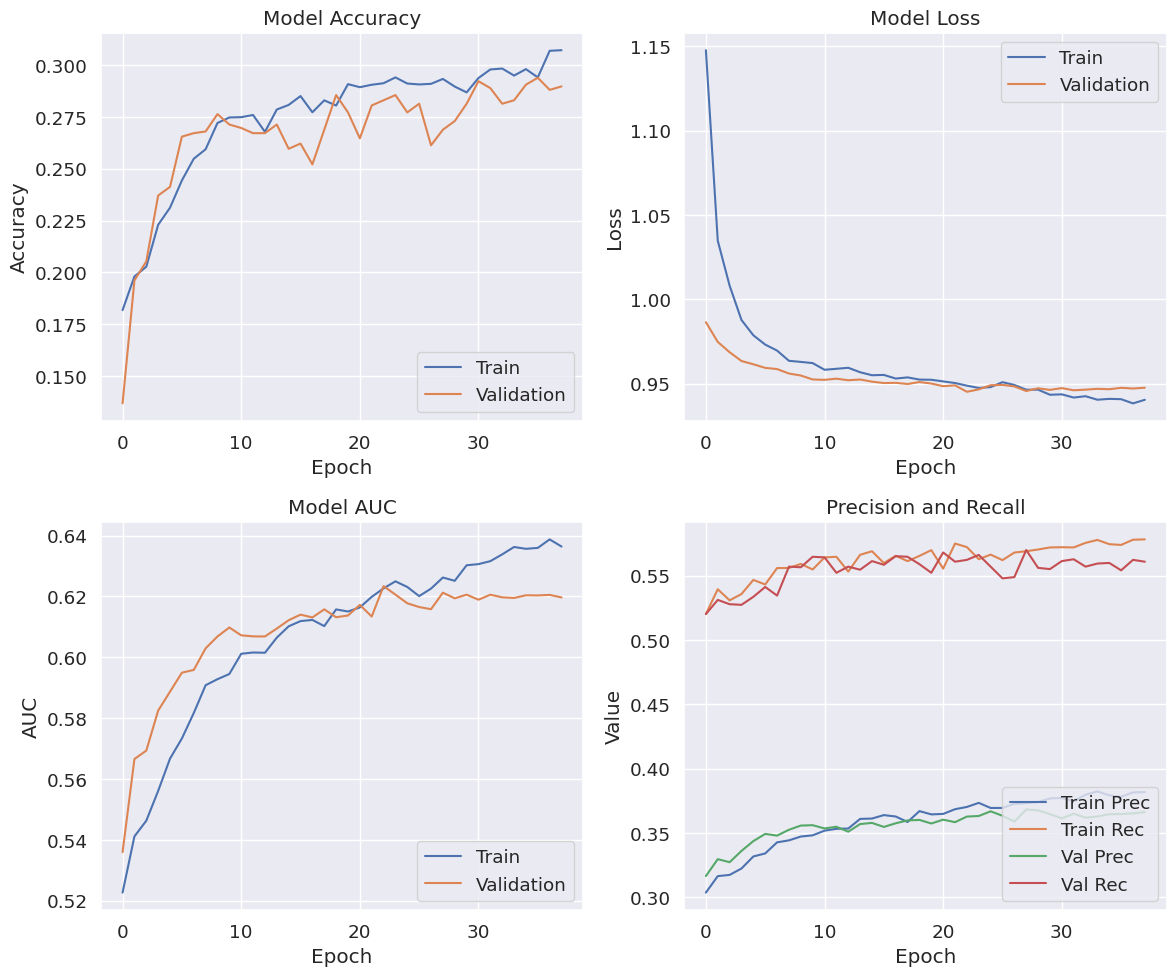

Analyzing feature importance...


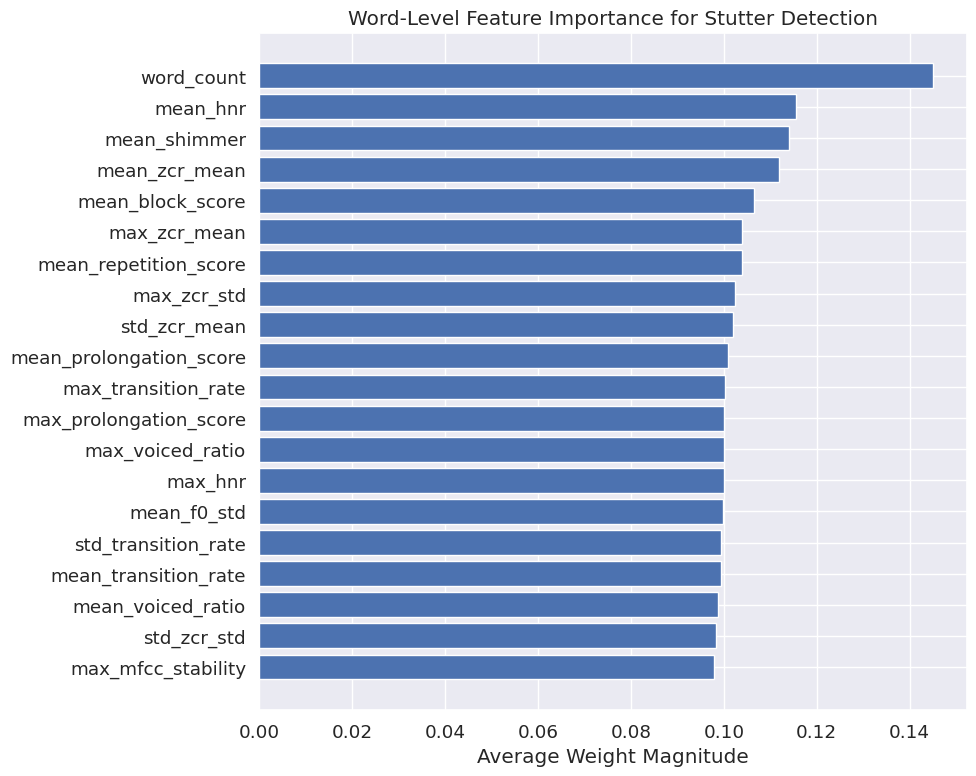


Top 10 Word-Level Features for Stutter Detection:
word_count: 0.1450
mean_hnr: 0.1156
mean_shimmer: 0.1139
mean_zcr_mean: 0.1119
mean_block_score: 0.1064
max_zcr_mean: 0.1040
mean_repetition_score: 0.1039
max_zcr_std: 0.1024
std_zcr_mean: 0.1019
mean_prolongation_score: 0.1010
Saving model...
Word-level stutter classification pipeline completed successfully!


In [12]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc  # Garbage collector

# Suppress warnings
warnings.filterwarnings('ignore')


def extract_word_level_features(audio_path, sr=16000, max_words=20, visualize=False):
    """
    Extract features at word level from an audio clip with enhanced features for stutter detection
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr)

        # Apply pre-emphasis filter
        pre_emphasis = 0.97
        y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        # Compute energy
        hop_length = 512
        energy = librosa.feature.rms(y=y, hop_length=hop_length)[0]

        # Calculate silence threshold (adaptive)
        silence_threshold = np.mean(energy) + 0.5 * np.std(energy)

        # Find silent regions (potential word boundaries)
        silences = []
        in_silence = True
        start_idx = 0

        # Minimum silence duration in frames (150ms typical between words)
        min_silence_frames = int(0.15 * sr / hop_length)

        for i, e in enumerate(energy):
            if in_silence and e > silence_threshold:
                # End of silence
                if i - start_idx >= min_silence_frames:
                    silences.append((start_idx, i))
                in_silence = False
            elif not in_silence and e <= silence_threshold:
                # Start of silence
                start_idx = i
                in_silence = True

        # Handle final silence
        if in_silence and len(energy) - start_idx >= min_silence_frames:
            silences.append((start_idx, len(energy)))

        # Convert silences to word segments
        word_segments = []

        # Add segment from start to first silence
        if silences and silences[0][0] > 0:
            word_segments.append((0, librosa.frames_to_samples(silences[0][0], hop_length=hop_length)))
        elif not silences:
            word_segments.append((0, len(y)))  # No silences, treat whole clip as one word

        # Add segments between silences
        for i in range(len(silences)-1):
            start = librosa.frames_to_samples(silences[i][1], hop_length=hop_length)
            end = librosa.frames_to_samples(silences[i+1][0], hop_length=hop_length)
            if end - start > sr * 0.1:  # Only keep segments longer than 100ms
                word_segments.append((start, end))

        # Add segment from last silence to end
        if silences and silences[-1][1] < len(energy):
            start = librosa.frames_to_samples(silences[-1][1], hop_length=hop_length)
            if len(y) - start > sr * 0.1:
                word_segments.append((start, len(y)))

        # If no word segments found, use whole clip
        if not word_segments:
            word_segments = [(0, len(y))]

        # Limit to max_words
        word_segments = word_segments[:max_words]

        # Initialize feature collections
        word_features = {}
        word_features['word_count'] = len(word_segments)
        word_features['word_segments'] = word_segments
        word_features['features_per_word'] = []

        # Extract features for each word
        for i, (start, end) in enumerate(word_segments):
            # Extract word audio
            word_audio = y[start:end]

            # Skip very short segments
            if len(word_audio) < sr * 0.05:  # < 50ms
                continue

            # Extract enhanced features for this word
            word_feature_dict = extract_enhanced_word_features(word_audio, sr, i)
            word_features['features_per_word'].append(word_feature_dict)

        # Store raw audio for visualization
        word_features['raw_audio'] = y
        word_features['sr'] = sr

        # Visualize if requested
        if visualize:
            plt.figure(figsize=(14, 10))

            # Play audio
            print("Playing audio clip...")
            ipd.display(ipd.Audio(y, rate=sr))

            # Plot waveform with word boundaries
            plt.subplot(3, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title('Waveform with Word Boundaries')

            # Add vertical lines for word boundaries
            for start, end in word_segments:
                plt.axvline(x=start/sr, color='r', linestyle='--', alpha=0.7)
                plt.axvline(x=end/sr, color='g', linestyle='--', alpha=0.7)

            # Plot energy
            plt.subplot(3, 1, 2)
            times = librosa.times_like(energy, sr=sr, hop_length=hop_length)
            plt.plot(times, energy)
            plt.axhline(y=silence_threshold, color='r', linestyle='--', label='Threshold')
            plt.title('Energy (RMS)')
            plt.ylabel('Energy')
            plt.legend()

            # Plot spectrogram
            plt.subplot(3, 1, 3)
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Mel Spectrogram with Word Boundaries')

            # Add vertical lines for word boundaries on spectrogram
            for start, end in word_segments:
                plt.axvline(x=start/sr, color='r', linestyle='--', alpha=0.7)
                plt.axvline(x=end/sr, color='g', linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.show()

            # Print key statistics
            print(f"\nDetected {word_features['word_count']} words")

            # Display features for each word
            for i, (start, end) in enumerate(word_segments):
                if i < len(word_features['features_per_word']):
                    word_feat = word_features['features_per_word'][i]
                    duration = (end - start) / sr

                    print(f"\nWord {i+1}:")
                    print(f"  Duration: {duration:.3f} sec")

                    # Play word audio
                    word_audio = y[start:end]
                    print(f"  Playing word audio...")
                    ipd.display(ipd.Audio(word_audio, rate=sr))

                    # Print stutter-relevant features
                    print(f"  Jitter: {word_feat['jitter']:.4f} (>0.015 indicates potential stutter)")
                    print(f"  Shimmer: {word_feat['shimmer']:.4f} (>0.035 indicates potential stutter)")
                    print(f"  HNR: {word_feat['hnr']:.2f} dB (<18 dB indicates potential stutter)")
                    print(f"  MFCC Stability: {word_feat['mfcc_stability']:.4f} (>0.12 indicates potential stutter)")

        return word_features

    except Exception as e:
        print(f"Error extracting word-level features: {str(e)}")
        traceback.print_exc()
        return None


def extract_enhanced_word_features(word_audio, sr, word_index):
    """
    Extract enhanced MFCC and prosodic features optimized for stutter detection
    """
    features = {}

    # Basic metadata
    features['word_index'] = word_index
    features['duration'] = len(word_audio) / sr

    try:
        # 1. Enhanced MFCC features
        mfcc = librosa.feature.mfcc(
            y=word_audio,
            sr=sr,
            n_mfcc=13,
            n_fft=int(0.025*sr),
            hop_length=int(0.010*sr),
            lifter=22
        )

        # Normalize MFCCs
        mfcc = librosa.util.normalize(mfcc, axis=1)

        # Compute delta and delta-delta features
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

        # Calculate temporal fluctuation (important for stutter detection)
        temporal_fluctuation = np.std(np.diff(mfcc, axis=1), axis=1)

        # Calculate local variability (rapid changes indicate stutter)
        local_variability = []
        for i in range(mfcc.shape[0]):
            if mfcc[i].shape[0] >= 5:  # Ensure enough frames
                rolled = np.lib.stride_tricks.sliding_window_view(mfcc[i], 5)
                local_variability.append(np.mean(np.var(rolled, axis=1)))
            else:
                local_variability.append(0)

        # Store MFCC features
        features['mfcc_mean'] = np.mean(mfcc, axis=1).tolist()
        features['mfcc_std'] = np.std(mfcc, axis=1).tolist()
        features['delta_mean'] = np.mean(delta_mfcc, axis=1).tolist()
        features['delta2_mean'] = np.mean(delta2_mfcc, axis=1).tolist()
        features['temporal_fluctuation'] = temporal_fluctuation.tolist()
        features['local_variability'] = local_variability
        features['mfcc_stability'] = np.mean(temporal_fluctuation)
        features['transition_rate'] = np.mean(np.abs(np.diff(mfcc, axis=1)))

        # 2. Enhanced prosodic features
        # Pitch (F0) extraction
        f0, voiced_flag, _ = librosa.pyin(
            word_audio,
            fmin=80,
            fmax=400,
            sr=sr
        )
        f0_valid = f0[~np.isnan(f0)]

        # Jitter calculation (cycle-to-cycle frequency variation)
        if len(f0_valid) > 1:
            jitter = np.mean(np.abs(np.diff(f0_valid))) / np.mean(f0_valid)
            # Relative Average Perturbation (RAP)
            if len(f0_valid) > 2:
                rap = np.mean(np.abs(f0_valid[1:-1] - (f0_valid[:-2] + f0_valid[1:-1] + f0_valid[2:])/3)) / np.mean(f0_valid)
            else:
                rap = 0
        else:
            jitter = 0
            rap = 0

        # Shimmer calculation (cycle-to-cycle amplitude variation)
        amplitude = librosa.feature.rms(y=word_audio)[0]
        if len(amplitude) > 1:
            shimmer = np.mean(np.abs(np.diff(amplitude))) / np.mean(amplitude)
            # Amplitude Perturbation Quotient (APQ)
            if len(amplitude) > 4:
                apq = np.mean(np.abs(amplitude[2:-2] - np.mean(np.lib.stride_tricks.sliding_window_view(amplitude, 5), axis=1))) / np.mean(amplitude)
            else:
                apq = 0
        else:
            shimmer = 0
            apq = 0

        # Harmonics-to-Noise Ratio (HNR)
        harmonic, percussive = librosa.effects.hpss(word_audio)
        hnr = 10 * np.log10(np.sum(harmonic**2) / (np.sum(percussive**2) + 1e-10))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=word_audio)[0]

        # Store prosodic features
        features['f0_mean'] = np.mean(f0_valid) if len(f0_valid) > 0 else 0
        features['f0_std'] = np.std(f0_valid) if len(f0_valid) > 0 else 0
        features['jitter'] = jitter
        features['rap'] = rap
        features['shimmer'] = shimmer
        features['apq'] = apq
        features['hnr'] = hnr
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)
        features['voiced_ratio'] = np.sum(~np.isnan(f0)) / len(f0) if len(f0) > 0 else 0

        # 3. Stutter-specific metrics
        # Repetition indicator (high local variability with low global variability)
        features['repetition_score'] = np.mean(local_variability) / (np.mean(features['mfcc_std']) + 1e-10)

        # Prolongation indicator (low jitter with high duration)
        features['prolongation_score'] = features['duration'] * (1 - min(jitter * 10, 1))

        # Block indicator (low energy with high ZCR)
        features['block_score'] = features['zcr_mean'] * (1 - min(np.mean(amplitude) * 10, 1))

        return features

    except Exception as e:
        print(f"Error extracting enhanced word features: {str(e)}")
        # Return basic features if extraction fails
        return {
            'word_index': word_index,
            'duration': len(word_audio) / sr,
            'error': str(e)
        }

def extract_aggregated_word_features(clip_path):
    """Extract and aggregate word-level features for a single clip"""
    try:
        # Extract word-level features
        word_features = extract_word_level_features(clip_path, visualize=False)

        if word_features is None or 'features_per_word' not in word_features or len(word_features['features_per_word']) == 0:
            return None

        # Initialize aggregated features dictionary
        agg_features = {}

        # Track word count
        word_count = len(word_features['features_per_word'])
        agg_features['word_count'] = word_count

        # Numeric features to aggregate
        numeric_features = ['duration', 'mfcc_stability', 'transition_rate',
                          'jitter', 'shimmer', 'hnr', 'f0_mean', 'f0_std',
                          'zcr_mean', 'zcr_std', 'voiced_ratio',
                          'repetition_score', 'prolongation_score', 'block_score']

        # Initialize aggregated features
        for feature in numeric_features:
            agg_features[f'mean_{feature}'] = 0
            agg_features[f'std_{feature}'] = 0
            agg_features[f'max_{feature}'] = 0

        # Collect values for each feature across words
        feature_values = {feature: [] for feature in numeric_features}

        # Extract values from each word
        for word_feat in word_features['features_per_word']:
            for feature in numeric_features:
                if feature in word_feat:
                    feature_values[feature].append(word_feat[feature])

        # Calculate statistics for each feature
        for feature in numeric_features:
            if feature_values[feature]:  # If we have values
                agg_features[f'mean_{feature}'] = np.mean(feature_values[feature])
                if len(feature_values[feature]) > 1:
                    agg_features[f'std_{feature}'] = np.std(feature_values[feature])
                agg_features[f'max_{feature}'] = np.max(feature_values[feature])

        return agg_features

    except Exception as e:
        print(f"Error processing {clip_path}: {str(e)}")
        return None

def batch_process_clips(clips_df, batch_size=100):
    """Process clips in batches to avoid memory issues"""
    all_features = []
    all_labels = []

    total_batches = len(clips_df) // batch_size + (1 if len(clips_df) % batch_size > 0 else 0)

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(clips_df))

        batch_df = clips_df.iloc[start_idx:end_idx]

        print(f"Processing batch {batch_idx+1}/{total_batches} (clips {start_idx+1}-{end_idx})")

        # Extract features for this batch
        batch_results = []
        for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx+1}"):
            features = extract_aggregated_word_features(row['file_path'])
            if features is not None:
                batch_results.append((features, row[3:9]))

        # Add valid results to our lists
        for features, label in batch_results:
            all_features.append(features)
            all_labels.append(label)

        # Force garbage collection to free memory
        gc.collect()

    if len(all_features) == 0:
        raise ValueError("No valid features extracted. Check your audio files and paths.")

    # Convert features to DataFrame
    features_df = pd.DataFrame(all_features)
    labels = np.array(all_labels)

    return features_df, labels

def prepare_dataset(features_array, labels):
    """Prepare train/val/test datasets with proper scaling"""
    # First split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        features_array, labels, test_size=0.15, random_state=42, stratify=labels
    )

    # Then split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )

    # Standardize features based on training set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")

    print(y_train.shape)
    # Print class distribution
    print(f"Class distribution in training set: {np.sum(y_train, axis = 0)}")
    print(f"Class distribution in validation set: {np.sum(y_val, axis = 0)}")
    print(f"Class distribution in testing set: {np.sum(y_test, axis = 0)}")

    # Save scaler for future use
    from joblib import dump
    dump(scaler, 'mfcc_feature_scaler.joblib')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def get_weighted_binary_crossentropy(class_weights):
    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        loss = - (class_weights_tensor * y_true * tf.math.log(y_pred + 1e-7) +
                  (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))
        return tf.reduce_mean(loss)

    return loss_fn

def build_model(input_shape, loss_fn = 'binary_crossentropy'):
    """Build DNN model for stutter detection using MFCC features"""
    model = Sequential([
        # Input layer - adapted for MFCC features which typically have higher dimensionality
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),

        # Hidden layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(6, activation='sigmoid')
    ])

    # Compile model with explicitly named metrics
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    # Show model summary
    model.summary()

    return model

def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with early stopping and LR reduction"""
    # Calculate class weights for imbalanced dataset
    from sklearn.utils.class_weight import compute_class_weight

    # n_classes = y_train.shape[1]
    # class_weights = {}

    # for i in range(n_classes):
    #     labels = y_train[:, i]  # Get all labels for class i (0 or 1)
    #     weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels)
    #     class_weights[i] = dict(zip([0, 1], weights))


    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    # Train model
    y_train = np.array(y_train, dtype=np.int32)
    y_val = np.array(y_val, dtype=np.int32)
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    print("Evaluating model on test set...")
    y_test = np.array(y_test, dtype=np.int32)
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Display confusion matrix
    cm = multilabel_confusion_matrix(y_test, y_pred)
    labels = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection', 'No Stutter']


    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns
    axes = axes.flatten()

    for i in range(len(labels)):
        ax = axes[i]
        matrix = cm[i]
        im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

        # Axis settings
        ax.set_title(labels[i])
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Pred: No', 'Pred: Yes'], rotation=45)
        ax.set_yticklabels(['True: No', 'True: Yes'])

        # Text annotations with dynamic color
        thresh = matrix.max() / 2.
        for j in range(2):
            for k in range(2):
                ax.text(k, j, format(matrix[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if matrix[j, k] > thresh else "black")

    # Layout & labels
    fig.suptitle('Multilabel Confusion Matrices', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    return y_pred


def plot_training_history(history):
    """Plot training metrics"""
    # First, print available keys to debug
    print("Available history keys:", history.history.keys())

    plt.figure(figsize=(12, 10))

    # Plot accuracy - access the correct metric name
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC - the key might be different than just 'auc'
    # In TF 2.0+, it might be something like 'auc_1' or the custom name you provided
    plt.subplot(2, 2, 3)

    # Use the correct AUC key from the printed keys above
    auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' not in k][0]
    val_auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' in k][0]

    plt.plot(history.history[auc_key])
    plt.plot(history.history[val_auc_key])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot Precision/Recall if available
    if any('precision' in k for k in history.history.keys()):
        plt.subplot(2, 2, 4)
        prec_key = [k for k in history.history.keys() if 'precision' in k and 'val' not in k][0]
        val_prec_key = [k for k in history.history.keys() if 'precision' in k and 'val' in k][0]
        rec_key = [k for k in history.history.keys() if 'recall' in k and 'val' not in k][0]
        val_rec_key = [k for k in history.history.keys() if 'recall' in k and 'val' in k][0]

        plt.plot(history.history[prec_key])
        plt.plot(history.history[rec_key])
        plt.plot(history.history[val_prec_key])
        plt.plot(history.history[val_rec_key])
        plt.title('Precision and Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend(['Train Prec', 'Train Rec', 'Val Prec', 'Val Rec'], loc='lower right')

    plt.tight_layout()
    plt.show()


def analyze_feature_importance(model, feature_names):
    """Analyze which word-level features are most important"""
    # For a DNN, we can examine the weights of the first layer
    weights = model.layers[0].get_weights()[0]

    # Calculate average absolute weight for each feature
    importance = np.mean(np.abs(weights), axis=1)

    # Pair feature names with their importance
    feature_importance = list(zip(feature_names, importance))

    # Sort by importance (descending)
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    features, importance = zip(*feature_importance[:20])  # Top 20 features
    plt.barh(features, importance)
    plt.xlabel('Average Weight Magnitude')
    plt.title('Word-Level Feature Importance for Stutter Detection')
    plt.gca().invert_yaxis()  # Display most important at the top
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Word-Level Features for Stutter Detection:")
    for feature, imp in feature_importance[:10]:
        print(f"{feature}: {imp:.4f}")

    return feature_importance

def run_word_level_classification(clips_df):
    """End-to-end word-level stutter classification pipeline"""
    # Check if cached features exist
    if os.path.exists('word_features.csv') and os.path.exists('word_labels.npy'):
        print("Loading pre-extracted features...")
        features_df = pd.read_csv('word_features.csv')
        labels = np.load('word_labels.npy', allow_pickle=True)
    else:
        # 1. Extract features
        print("Extracting word-level features...")
        features_df, labels = batch_process_clips(clips_df)

        # Save extracted features to avoid reprocessing
        print("Saving extracted features...")
        features_df.to_csv('word_features.csv', index=False)
        np.save('word_labels.npy', labels)

    # 2. Prepare datasets
    print("Preparing train/val/test datasets...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_df, labels)

    pos_counts = np.sum(y_train, axis=0)
    neg_counts = y_train.shape[0] - pos_counts
    class_weights = neg_counts / (pos_counts + 1e-6)

    loss_fn = get_weighted_binary_crossentropy(class_weights)

    # 3. Build model
    print("Building model...")
    model = build_model(X_train.shape[1], loss_fn)

    # 4. Train model
    print("Training model...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)

    # 5. Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X_test, y_test)

    # 6. Plot training history
    print("Plotting training history...")
    plot_training_history(history)

    # 7. Analyze feature importance
    print("Analyzing feature importance...")
    analyze_feature_importance(model, features_df.columns)

    # 8. Save model
    print("Saving model...")
    model.save('word_level_stutter_model.h5')

    return model, features_df

# Run the pipeline
try:
    model, features_df = run_word_level_classification(clips_df)
    print("Word-level stutter classification pipeline completed successfully!")
except Exception as e:
    print(f"Error in word-level classification pipeline: {str(e)}")
    import traceback
    traceback.print_exc()


Extracting syllable-level features...
Processing batch 1/314 (clips 1-30)
Processing batch 2/314 (clips 31-60)
Processing batch 3/314 (clips 61-90)
Processing batch 4/314 (clips 91-120)
Processing batch 5/314 (clips 121-150)
Processing batch 6/314 (clips 151-180)
Saved intermediate results after batch 5
Processing batch 7/314 (clips 181-210)
Processing batch 8/314 (clips 211-240)
Processing batch 9/314 (clips 241-270)
Processing batch 10/314 (clips 271-300)
Processing batch 11/314 (clips 301-330)
Saved intermediate results after batch 10
Processing batch 12/314 (clips 331-360)
Processing batch 13/314 (clips 361-390)
Processing batch 14/314 (clips 391-420)
Processing batch 15/314 (clips 421-450)
Processing batch 16/314 (clips 451-480)
Saved intermediate results after batch 15
Processing batch 17/314 (clips 481-510)
Processing batch 18/314 (clips 511-540)
Processing batch 19/314 (clips 541-570)
Processing batch 20/314 (clips 571-600)
Processing batch 21/314 (clips 601-630)
Saved intermed

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,118 (55.15 KB)

 Trainable params: 13,670 (53.40 KB)

 Non-trainable params: 448 (1.75 KB)

Training model...
Training model...
Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.1889 - auc: 0.5244 - loss: 1.2001 - precision: 0.3038 - recall: 0.5234 - val_accuracy: 0.1369 - val_auc: 0.5436 - val_loss: 0.9763 - val_precision: 0.3097 - val_recall: 0.6858 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.2068 - auc: 0.5352 - loss: 1.0561 - precision: 0.3132 - recall: 0.5258 - val_accuracy: 0.2713 - val_auc: 0.5931 - val_loss: 0.9653 - val_precision: 0.3469 - val_recall: 0.5920 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2383 - auc: 0.5550 - loss: 1.0069 - precision: 0.3247 - recall: 0.5373 - val_accuracy: 0.2838 - val_auc: 0.5991 - val_loss: 0.9628 - val_precision: 0.3485 - val_recall: 0.6149 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2398 - auc: 0.5560 - loss: 0.9906 - precision: 0.3207 - recall: 0.5295 - val_accuracy: 0.2771

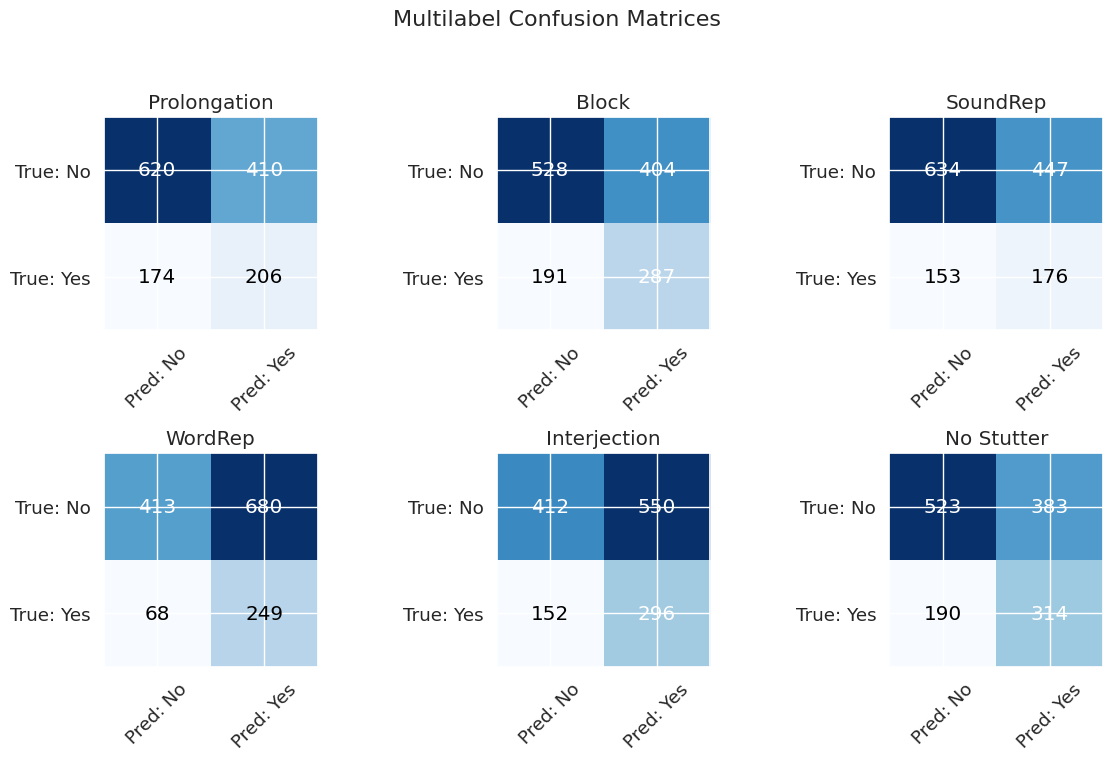


Classification Report:
              precision    recall  f1-score   support

Prolongation       0.33      0.54      0.41       380
       Block       0.42      0.60      0.49       478
    SoundRep       0.28      0.53      0.37       329
     WordRep       0.27      0.79      0.40       317
Interjection       0.35      0.66      0.46       448
  No Stutter       0.45      0.62      0.52       504

   micro avg       0.35      0.62      0.45      2456
   macro avg       0.35      0.62      0.44      2456
weighted avg       0.36      0.62      0.45      2456
 samples avg       0.37      0.62      0.44      2456

Plotting training history...
Available metrics: ['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate']


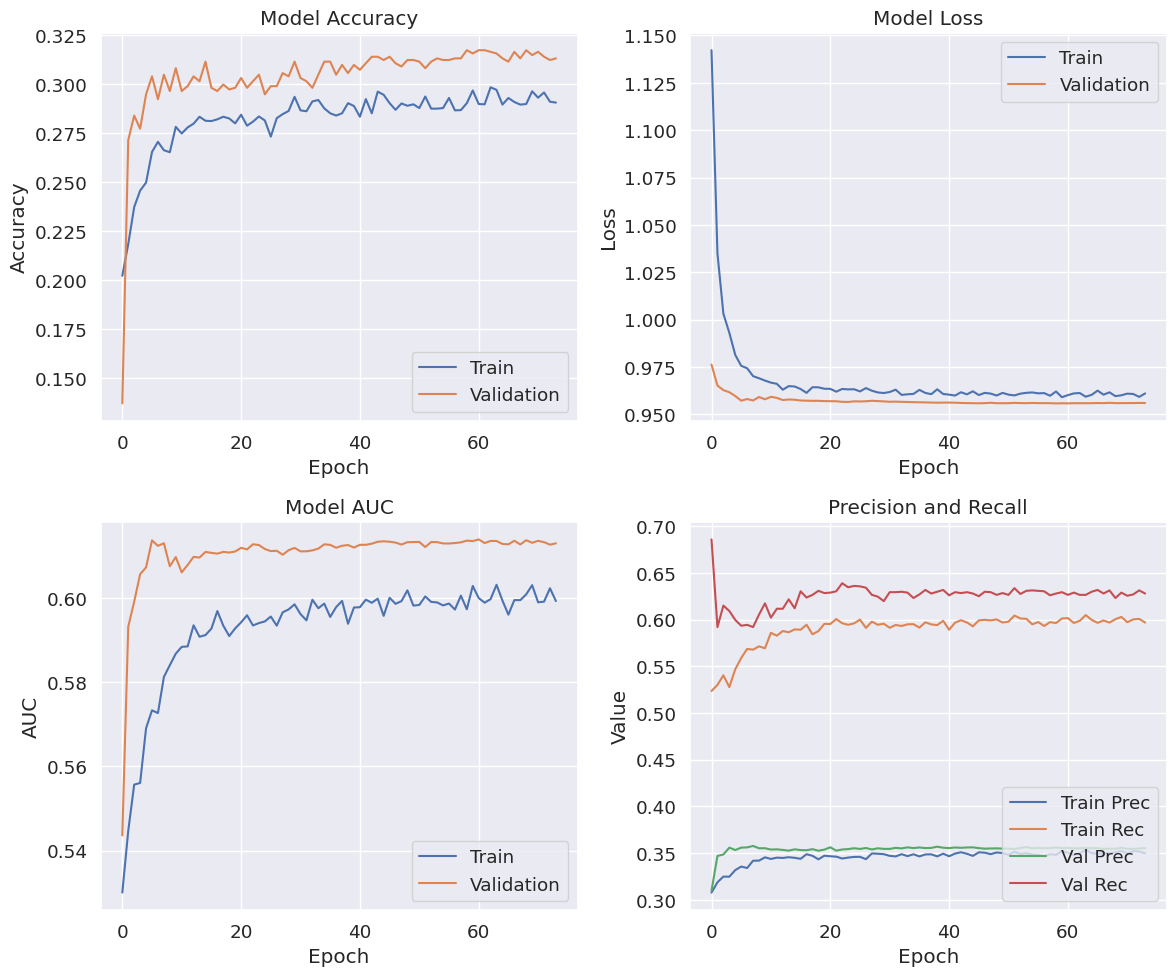

Analyzing feature importance...


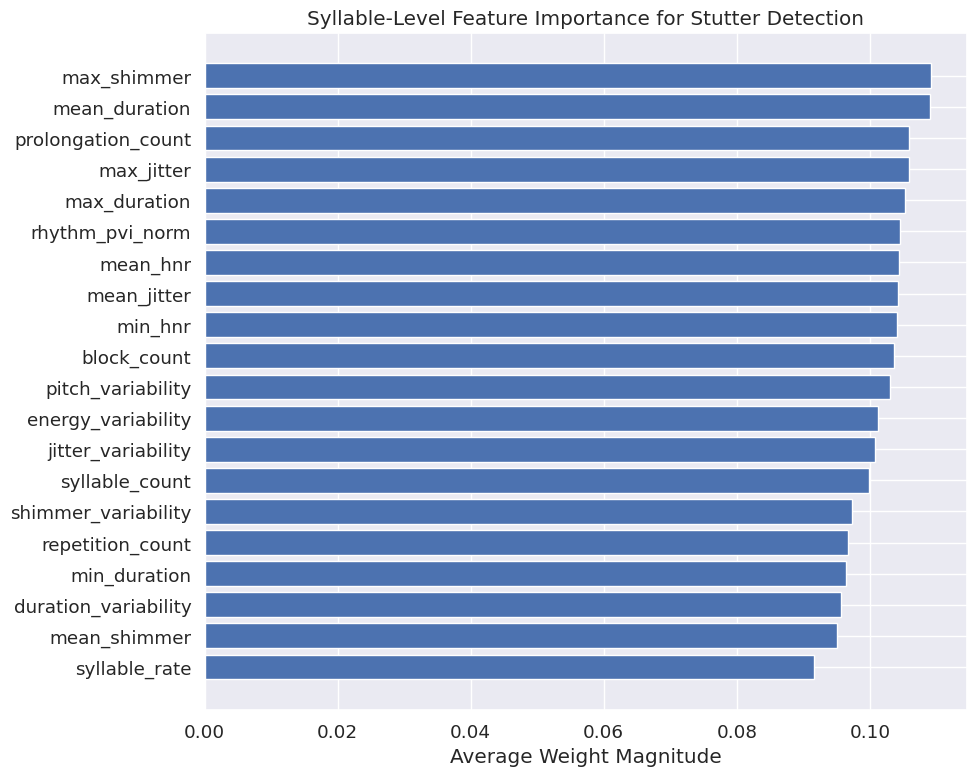


Top 10 Syllable-Level Features for Stutter Detection:
max_shimmer: 0.1091
mean_duration: 0.1090
prolongation_count: 0.1059
max_jitter: 0.1058
max_duration: 0.1053
rhythm_pvi_norm: 0.1046
mean_hnr: 0.1043
mean_jitter: 0.1042
min_hnr: 0.1041
block_count: 0.1036
Saving model...
Syllable-level stutter classification pipeline completed successfully!


In [13]:



import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from joblib import Parallel, delayed
import scipy.signal
import gc

# Suppress warnings to keep output clean
warnings.filterwarnings('ignore')

def extract_syllable_level_features(audio_path, sr=16000, visualize=False):
    """
    Extract syllable-level features using group delay function approach from Nagarajan et al. (2003)
    with enhanced features for stutter detection.

    Parameters:
        audio_path (str): Path to the audio file
        sr (int): Sampling rate
        visualize (bool): Whether to visualize the features

    Returns:
        dict: Dictionary containing syllable-level features
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr)

        # Apply pre-emphasis filter
        pre_emphasis = 0.97
        y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        # Create three sub-bands as described in the paper
        # 1. Original signal
        y_original = y.copy()

        # 2. Low-pass filtered signal (to remove fricatives)
        b_low = [1.0, -0.97]
        a_low = [1.0]
        y_low = lfilter(b_low, a_low, y)

        # 3. Band-pass filtered signal (to attenuate semivowels)
        D = librosa.stft(y, n_fft=1024, hop_length=256)
        D_mid = D.copy()
        D_mid[:20] = 0
        D_mid[50:] = 0
        y_mid = librosa.istft(D_mid, hop_length=256)

        # Ensure all signals have the same length by truncating to the minimum length
        min_length = min(len(y_original), len(y_low), len(y_mid))
        y_original = y_original[:min_length]
        y_low = y_low[:min_length]
        y_mid = y_mid[:min_length]

        # Compute short-term energy functions for each sub-band with the same parameters
        hop_length = 128
        frame_length = 512
        energy_original = librosa.feature.rms(y=y_original, frame_length=frame_length, hop_length=hop_length)[0]
        energy_low = librosa.feature.rms(y=y_low, frame_length=frame_length, hop_length=hop_length)[0]
        energy_mid = librosa.feature.rms(y=y_mid, frame_length=frame_length, hop_length=hop_length)[0]

        # Normalize energy functions
        energy_original = energy_original / np.max(energy_original) if np.max(energy_original) > 0 else energy_original
        energy_low = energy_low / np.max(energy_low) if np.max(energy_low) > 0 else energy_low
        energy_mid = energy_mid / np.max(energy_mid) if np.max(energy_mid) > 0 else energy_mid

        # Function to compute minimum phase group delay function
        def compute_group_delay(energy):
            # 1. Create symmetric energy sequence
            energy_sym = np.concatenate([energy, energy[::-1]])

            # 2. Invert the sequence (since we're interested in valleys)
            energy_inv = 1.0 - energy_sym

            # 3. Compute root cepstrum (inverse DFT)
            root_cepstrum = np.fft.ifft(energy_inv).real

            # 4. Window the causal part (minimum phase signal)
            window_size = int(len(root_cepstrum) * 0.1)
            windowed_cepstrum = root_cepstrum[:window_size].copy()

            # 5. Compute group delay function
            group_delay = np.zeros_like(energy)
            for n in range(len(group_delay)):
                for k in range(min(window_size, len(windowed_cepstrum))):
                    group_delay[n] += k * windowed_cepstrum[k] * np.cos(2 * np.pi * k * n / len(energy))

            return group_delay

        # Compute group delay functions for each sub-band
        gd_original = compute_group_delay(energy_original)
        gd_low = compute_group_delay(energy_low)
        gd_mid = compute_group_delay(energy_mid)

        # Detect peaks in each group delay function
        def find_peaks(gd, threshold=0.2):
            peaks = []
            for i in range(1, len(gd) - 1):
                if gd[i] > gd[i-1] and gd[i] > gd[i+1] and gd[i] > threshold:
                    peaks.append(i)
            return peaks

        peaks_original = find_peaks(gd_original)
        peaks_low = find_peaks(gd_low)
        peaks_mid = find_peaks(gd_mid)

        # Convert peak indices to time (in samples)
        peaks_original_samples = [p * hop_length for p in peaks_original]
        peaks_low_samples = [p * hop_length for p in peaks_low]
        peaks_mid_samples = [p * hop_length for p in peaks_mid]

        # Combine evidence from all sub-bands as per paper section 3.2.5
        combined_peaks = []

        # First, add all peaks from original signal
        combined_peaks.extend(peaks_original_samples)

        # Add peaks from low-pass filtered signal if close to original
        for peak_low in peaks_low_samples:
            # Check if within 20ms of any peak in original
            if not any(abs(peak_low - peak_orig) <= 0.02 * sr for peak_orig in peaks_original_samples):
                # Only add if not too close to existing peaks
                if not any(abs(peak_low - peak) <= 0.01 * sr for peak in combined_peaks):
                    combined_peaks.append(peak_low)

        # Add peaks from band-pass filtered signal if in specific range
        for peak_mid in peaks_mid_samples:
            # Check if within 50-100ms range from any peak in combined
            if not any(0.05 * sr <= abs(peak_mid - peak) <= 0.1 * sr for peak in combined_peaks):
                # Only add if not too close to existing peaks
                if not any(abs(peak_mid - peak) <= 0.01 * sr for peak in combined_peaks):
                    combined_peaks.append(peak_mid)

        # Sort peaks chronologically
        combined_peaks.sort()

        # Create syllable segments
        segments = []
        for i in range(len(combined_peaks) - 1):
            start = combined_peaks[i]
            end = combined_peaks[i + 1]
            # Ensure minimum syllable duration (50ms)
            if (end - start) >= 0.05 * sr:
                segments.append((start, end))

        # If no segments detected or only one boundary, use whole clip
        if len(segments) == 0 and len(combined_peaks) > 0:
            segments = [(0, combined_peaks[0]), (combined_peaks[0], len(y))]
        elif len(segments) == 0:
            segments = [(0, len(y))]

        # Extract features from each syllable
        syllable_features = {}
        syllable_features['syllable_count'] = len(segments)
        syllable_features['syllable_segments'] = segments
        syllable_features['syllable_data'] = []

        durations = []
        energies = []
        pitches = []
        mfccs_means = []
        mfccs_stds = []
        jitters = []
        shimmers = []
        hnrs = []

        # Process each syllable segment
        for i, (start, end) in enumerate(segments):
            if end <= len(y):
                syllable = y[start:end]
                duration = (end - start) / sr
                durations.append(duration)

                # Energy profile
                syl_energy = librosa.feature.rms(y=syllable)[0]
                energy_mean = np.mean(syl_energy)
                energy_std = np.std(syl_energy)
                energies.append(energy_mean)

                # MFCC features
                if len(syllable) > 512:  # Ensure enough samples for MFCC
                    mfcc = librosa.feature.mfcc(
                        y=syllable,
                        sr=sr,
                        n_mfcc=13,
                        n_fft=int(0.025*sr),
                        hop_length=int(0.010*sr)
                    )
                    mfcc_mean = np.mean(mfcc, axis=1)
                    mfcc_std = np.std(mfcc, axis=1)
                    mfccs_means.append(mfcc_mean)
                    mfccs_stds.append(mfcc_std)

                    # Calculate temporal fluctuation
                    temporal_fluctuation = np.std(np.diff(mfcc, axis=1), axis=1)
                else:
                    mfcc_mean = np.zeros(13)
                    mfcc_std = np.zeros(13)
                    temporal_fluctuation = np.zeros(13)
                    mfccs_means.append(mfcc_mean)
                    mfccs_stds.append(mfcc_std)

                # Pitch analysis
                if len(syllable) > 512:  # Ensure enough samples for pitch analysis
                    f0, voiced_flag, _ = librosa.pyin(
                        syllable,
                        fmin=librosa.note_to_hz('C2'),
                        fmax=librosa.note_to_hz('C7'),
                        sr=sr
                    )
                    f0_valid = f0[~np.isnan(f0)]

                    if len(f0_valid) > 0:
                        f0_mean = np.mean(f0_valid)
                        f0_std = np.std(f0_valid)
                        f0_stability = f0_std/f0_mean if f0_mean > 0 else 0
                        pitches.append(f0_mean)

                        # Calculate jitter (frequency perturbation)
                        if len(f0_valid) > 1:
                            jitter = np.mean(np.abs(np.diff(f0_valid))) / f0_mean if f0_mean > 0 else 0
                            jitters.append(jitter)
                        else:
                            jitter = 0
                            jitters.append(0)
                    else:
                        f0_mean = 0
                        f0_std = 0
                        f0_stability = 0
                        pitches.append(0)
                        jitter = 0
                        jitters.append(0)
                else:
                    f0_mean = 0
                    f0_std = 0
                    f0_stability = 0
                    pitches.append(0)
                    jitter = 0
                    jitters.append(0)

                # Calculate shimmer (amplitude perturbation)
                if len(syl_energy) > 1:
                    shimmer = np.mean(np.abs(np.diff(syl_energy))) / energy_mean if energy_mean > 0 else 0
                    shimmers.append(shimmer)
                else:
                    shimmer = 0
                    shimmers.append(0)

                # Calculate HNR (harmonics-to-noise ratio)
                if len(syllable) > 512:
                    harmonic, percussive = librosa.effects.hpss(syllable)
                    hnr = 10 * np.log10(np.sum(harmonic**2) / (np.sum(percussive**2) + 1e-10))
                    hnrs.append(hnr)
                else:
                    hnr = 0
                    hnrs.append(0)

                # Zero-crossing rate
                zcr = librosa.feature.zero_crossing_rate(y=syllable)[0]
                zcr_mean = np.mean(zcr)

                # Spectral centroid
                if len(syllable) > 512:
                    spectral_centroid = librosa.feature.spectral_centroid(y=syllable, sr=sr)[0]
                    centroid_mean = np.mean(spectral_centroid)
                else:
                    centroid_mean = 0

                # Store syllable features
                syllable_data = {
                    'start_time': start/sr,
                    'end_time': end/sr,
                    'duration': duration,
                    'energy_mean': energy_mean,
                    'energy_std': energy_std,
                    'f0_mean': f0_mean,
                    'f0_std': f0_std,
                    'f0_stability': f0_stability,
                    'mfcc_mean': mfcc_mean.tolist(),
                    'mfcc_std': mfcc_std.tolist(),
                    'temporal_fluctuation': temporal_fluctuation.tolist(),
                    'jitter': jitter,
                    'shimmer': shimmer,
                    'hnr': hnr,
                    'zcr_mean': zcr_mean,
                    'spectral_centroid': centroid_mean
                }

                syllable_features['syllable_data'].append(syllable_data)

        # Calculate rhythm metrics if we have enough syllables
        if len(durations) > 1:
            # Normalized Pairwise Variability Index (nPVI)
            pvi_norm = np.mean([abs(a-b)/((a+b)/2) for a, b in zip(durations[:-1], durations[1:])])

            # Calculate duration coefficient of variation
            duration_cv = np.std(durations)/np.mean(durations) if np.mean(durations) > 0 else 0

            # Calculate energy variability
            energy_cv = np.std(energies)/np.mean(energies) if np.mean(energies) > 0 else 0

            # Calculate pitch variability
            valid_pitches = [p for p in pitches if p > 0]
            pitch_cv = np.std(valid_pitches)/np.mean(valid_pitches) if len(valid_pitches) > 0 and np.mean(valid_pitches) > 0 else 0

            # Calculate jitter and shimmer variability
            jitter_cv = np.std(jitters)/np.mean(jitters) if len(jitters) > 0 and np.mean(jitters) > 0 else 0
            shimmer_cv = np.std(shimmers)/np.mean(shimmers) if len(shimmers) > 0 and np.mean(shimmers) > 0 else 0

            syllable_features.update({
                'syllable_rate': len(durations)/(segments[-1][1]/sr),
                'mean_duration': np.mean(durations),
                'duration_variability': duration_cv,
                'rhythm_pvi_norm': pvi_norm,
                'energy_variability': energy_cv,
                'pitch_variability': pitch_cv,
                'jitter_variability': jitter_cv,
                'shimmer_variability': shimmer_cv,
                'mean_jitter': np.mean(jitters),
                'mean_shimmer': np.mean(shimmers),
                'mean_hnr': np.mean(hnrs)
            })

            # Detect potential repetitions (important for stutter analysis)
            repetition_indices = []
            for i in range(len(durations)-1):
                # Check for similar consecutive syllables
                duration_ratio = min(durations[i], durations[i+1]) / max(durations[i], durations[i+1])
                energy_ratio = min(energies[i], energies[i+1]) / max(energies[i], energies[i+1])

                # If we have MFCC data, use it for similarity
                mfcc_similarity = 0
                if i < len(mfccs_means)-1:
                    mfcc_similarity = np.corrcoef(mfccs_means[i], mfccs_means[i+1])[0,1]
                    if np.isnan(mfcc_similarity):
                        mfcc_similarity = 0

                # Combine multiple factors for repetition detection
                if duration_ratio > 0.8 and energy_ratio > 0.75 and mfcc_similarity > 0.6:
                    repetition_indices.append(i)

            syllable_features['potential_repetitions'] = repetition_indices
            syllable_features['repetition_count'] = len(repetition_indices)

            # Calculate stutter-specific metrics
            # Prolongation detection (long syllables with stable pitch)
            prolongation_indices = []
            mean_duration = np.mean(durations)
            for i, duration in enumerate(durations):
                if duration > 1.5 * mean_duration and i < len(jitters) and jitters[i] < 0.015:
                    prolongation_indices.append(i)

            syllable_features['potential_prolongations'] = prolongation_indices
            syllable_features['prolongation_count'] = len(prolongation_indices)

            # Block detection (short syllables with high jitter/shimmer)
            block_indices = []
            for i, duration in enumerate(durations):
                if duration < 0.7 * mean_duration and i < len(jitters) and i < len(shimmers):
                    if jitters[i] > 0.025 or shimmers[i] > 0.04:
                        block_indices.append(i)

            syllable_features['potential_blocks'] = block_indices
            syllable_features['block_count'] = len(block_indices)

        # Visualize if requested
        if visualize:
            plt.figure(figsize=(14, 12))

            # Play audio
            print("Playing audio clip...")
            ipd.display(ipd.Audio(y, rate=sr))

            # Plot waveform with syllable boundaries
            plt.subplot(5, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            for start, end in segments:
                plt.axvline(x=start/sr, color='r', linestyle='--', alpha=0.7)
                plt.axvline(x=end/sr, color='g', linestyle='--', alpha=0.7)
            plt.title('Waveform with Syllable Boundaries')

            # Generate time axis - Ensure all energy arrays have same length
            min_energy_len = min(len(energy_original), len(energy_low), len(energy_mid))
            energy_original_plot = energy_original[:min_energy_len]
            energy_low_plot = energy_low[:min_energy_len]
            energy_mid_plot = energy_mid[:min_energy_len]
            times = librosa.times_like(energy_original_plot, sr=sr, hop_length=hop_length)

            # Plot energy contours
            plt.subplot(5, 1, 2)
            plt.plot(times, energy_original_plot, label='Original')
            plt.plot(times, energy_low_plot, label='Low-pass filtered')
            plt.plot(times, energy_mid_plot, label='Band-pass filtered')
            plt.legend()
            plt.title('Energy Contours from Different Sub-bands')

            # Plot group delay functions
            plt.subplot(5, 1, 3)
            gd_original_plot = gd_original[:min_energy_len]
            gd_low_plot = gd_low[:min_energy_len]
            gd_mid_plot = gd_mid[:min_energy_len]

            plt.plot(times, gd_original_plot, label='Original')
            plt.plot(times, gd_low_plot, label='Low-pass filtered')
            plt.plot(times, gd_mid_plot, label='Band-pass filtered')

            # Mark peaks
            for p in peaks_original:
                if p < min_energy_len:
                    plt.plot(times[p], gd_original_plot[p], 'ro')
            for p in peaks_low:
                if p < min_energy_len:
                    plt.plot(times[p], gd_low_plot[p], 'go')
            for p in peaks_mid:
                if p < min_energy_len:
                    plt.plot(times[p], gd_mid_plot[p], 'bo')

            plt.legend()
            plt.title('Group Delay Functions with Detected Peaks')

            # Plot syllable durations
            plt.subplot(5, 1, 4)
            plt.bar(range(len(durations)), durations)
            if 'potential_repetitions' in syllable_features:
                for idx in syllable_features['potential_repetitions']:
                    plt.bar(idx, durations[idx], color='red')
                    plt.bar(idx+1, durations[idx+1], color='red')
            plt.title('Syllable Durations')
            plt.xlabel('Syllable Index')
            plt.ylabel('Duration (s)')

            # Plot spectrogram
            plt.subplot(5, 1, 5)
            S = librosa.feature.melspectrogram(y=y, sr=sr)
            S_dB = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            for start, end in segments:
                plt.axvline(x=start/sr, color='w', linestyle='--', alpha=0.5)
            plt.title('Mel Spectrogram with Syllable Boundaries')

            plt.tight_layout()
            plt.show()

            # Print key statistics
            print("\nSyllable-Level Features for Stutter Detection:")
            print(f"Total Syllables: {syllable_features['syllable_count']}")

            if 'syllable_rate' in syllable_features:
                print(f"Syllable Rate: {syllable_features['syllable_rate']:.2f} syllables/sec")
                print(f"Mean Syllable Duration: {syllable_features['mean_duration']*1000:.1f} ms")
                print(f"Duration Variability (CV): {syllable_features['duration_variability']:.2f}")
                print(f"Rhythm PVI (normalized): {syllable_features['rhythm_pvi_norm']:.2f}")
                print(f"Energy Variability: {syllable_features['energy_variability']:.2f}")

                if syllable_features['repetition_count'] > 0:
                    print(f"\nPotential Syllable Repetitions: {syllable_features['repetition_count']}")
                    for idx in syllable_features['potential_repetitions']:
                        print(f"  Syllables {idx+1} and {idx+2} appear repeated")

            return syllable_features

    except Exception as e:
        print(f"Error extracting syllable-level features: {str(e)}")
        return None

def extract_aggregated_syllable_features(clip_path, sr=16000, verbose=False):
    """
    Extract and aggregate syllable-level features with enhanced error handling
    """
    try:
        # Basic audio integrity check
        if not os.path.exists(clip_path):
            if verbose:
                print(f"File not found: {clip_path}")
            return None

        # Load audio with error handling
        try:
            y, sr = librosa.load(clip_path, sr=sr)

            # Check if audio is valid (not empty or corrupted)
            if len(y) < sr*0.1:  # Less than 100ms
                if verbose:
                    print(f"Audio too short: {clip_path}")
                return None

        except Exception as e:
            if verbose:
                print(f"Error loading audio {clip_path}: {str(e)}")
            return None

        # Apply pre-emphasis filter
        y = librosa.effects.preemphasis(y, coef=0.97)

        # First attempt: Use standard syllable feature extraction
        syllable_features = extract_syllable_level_features(clip_path, sr=sr, visualize=False)

        # If standard method fails, try simplified fallback method
        if syllable_features is None or 'syllable_count' not in syllable_features or syllable_features['syllable_count'] == 0:
            if verbose:
                print(f"Using fallback syllable detection for {clip_path}")
            syllable_features = extract_fallback_syllable_features(y, sr)

            # If still no syllables, return None
            if syllable_features is None or syllable_features['syllable_count'] == 0:
                if verbose:
                    print(f"No syllables detected in {clip_path}")
                return None

        # Initialize aggregated features dictionary
        agg_features = {}

        # Include syllable count
        agg_features['syllable_count'] = syllable_features['syllable_count']

        # Add basic prosodic statistics
        global_metrics = [
            'syllable_rate', 'mean_duration', 'duration_variability',
            'rhythm_pvi_norm', 'energy_variability', 'pitch_variability'
        ]

        # Add these metrics if available, otherwise use defaults
        for metric in global_metrics:
            if metric in syllable_features:
                agg_features[metric] = syllable_features[metric]
            else:
                agg_features[metric] = 0

        # Add stutter-specific metrics
        stutter_metrics = [
            'jitter_variability', 'shimmer_variability', 'mean_jitter',
            'mean_shimmer', 'mean_hnr', 'repetition_count',
            'prolongation_count', 'block_count'
        ]

        for metric in stutter_metrics:
            if metric in syllable_features:
                agg_features[metric] = syllable_features[metric]
            else:
                agg_features[metric] = 0

        # Extract additional statistics from individual syllables if available
        if 'syllable_data' in syllable_features and len(syllable_features['syllable_data']) > 0:
            # Extract key features from each syllable
            durations = []
            energies = []
            jitters = []
            shimmers = []
            hnrs = []

            for syl_data in syllable_features['syllable_data']:
                if 'duration' in syl_data:
                    durations.append(syl_data['duration'])
                if 'energy_mean' in syl_data:
                    energies.append(syl_data['energy_mean'])
                if 'jitter' in syl_data:
                    jitters.append(syl_data['jitter'])
                if 'shimmer' in syl_data:
                    shimmers.append(syl_data['shimmer'])
                if 'hnr' in syl_data:
                    hnrs.append(syl_data['hnr'])

            # Add meaningful statistics only if we have valid data
            if durations:
                agg_features['max_duration'] = np.max(durations)
                agg_features['min_duration'] = np.min(durations)
            else:
                # Default values if metrics missing
                agg_features['max_duration'] = 0
                agg_features['min_duration'] = 0

            if jitters:
                agg_features['max_jitter'] = np.max(jitters)
            else:
                agg_features['max_jitter'] = 0

            if shimmers:
                agg_features['max_shimmer'] = np.max(shimmers)
            else:
                agg_features['max_shimmer'] = 0

            if hnrs:
                valid_hnrs = [h for h in hnrs if h > 0]
                agg_features['min_hnr'] = np.min(valid_hnrs) if valid_hnrs else 0
            else:
                agg_features['min_hnr'] = 0

        # If no syllable data available, add default values
        else:
            default_features = ['max_duration', 'min_duration', 'max_jitter',
                               'max_shimmer', 'min_hnr']
            for feat in default_features:
                agg_features[feat] = 0

        return agg_features

    except Exception as e:
        if verbose:
            print(f"Unexpected error processing {clip_path}: {str(e)}")
        return None

def extract_fallback_syllable_features(y, sr):
    """Fallback method for syllable detection when main method fails"""
    try:
        # Use energy-based method for syllable segmentation
        # Calculate energy envelope
        energy = librosa.feature.rms(y=y, frame_length=int(0.025*sr), hop_length=int(0.010*sr))[0]

        # Normalize energy
        energy = energy / np.max(energy) if np.max(energy) > 0 else energy

        # Find peaks in energy contour (potential syllable centers)
        peaks, _ = scipy.signal.find_peaks(energy, height=0.1, distance=int(0.15*sr/160))

        # If no peaks found, return None
        if len(peaks) == 0:
            return None

        # Create syllable segments
        segments = []
        for i in range(len(peaks)-1):
            start = peaks[i]
            end = peaks[i+1]
            # Minimum syllable duration check (50ms)
            if (end - start) >= int(0.05*sr/160):
                segments.append((start*160, end*160))  # Convert frame indices to samples

        # Handle first and last segments
        if len(segments) == 0 and len(peaks) > 0:
            start_sample = max(0, peaks[0]*160 - int(0.1*sr))
            end_sample = min(len(y), peaks[0]*160 + int(0.1*sr))
            segments = [(start_sample, end_sample)]

        # Create basic syllable features
        syllable_features = {
            'syllable_count': len(segments),
            'syllable_segments': segments,
            'syllable_data': []
        }

        # Create basic metrics
        durations = [(end-start)/sr for start, end in segments]

        if len(durations) > 1:
            syllable_features['mean_duration'] = np.mean(durations)
            syllable_features['duration_variability'] = np.std(durations)/np.mean(durations) if np.mean(durations) > 0 else 0
            syllable_features['syllable_rate'] = len(durations)/(segments[-1][1]/sr) if segments else 0
        else:
            syllable_features['mean_duration'] = durations[0] if durations else 0
            syllable_features['duration_variability'] = 0
            syllable_features['syllable_rate'] = 1/durations[0] if durations and durations[0] > 0 else 0

        # Process each syllable segment for basic features
        for i, (start, end) in enumerate(segments):
            if end <= len(y):
                syllable = y[start:end]
                duration = (end - start) / sr

                # Basic energy
                syl_energy = np.mean(np.abs(syllable)**2)

                syllable_data = {
                    'duration': duration,
                    'energy_mean': syl_energy,
                    'jitter': 0,  # Default values for fallback method
                    'shimmer': 0,
                    'hnr': 0
                }

                syllable_features['syllable_data'].append(syllable_data)

        return syllable_features

    except Exception as e:
        print(f"Error in fallback syllable detection: {str(e)}")
        return None

def batch_process_clips(clips_df, batch_size=30, n_jobs=4):
    """
    Process clips in smaller batches with parallel processing for speed
    """
    all_features = []
    all_labels = []

    # Calculate number of batches
    total_batches = len(clips_df) // batch_size + (1 if len(clips_df) % batch_size > 0 else 0)

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(clips_df))

        batch_df = clips_df.iloc[start_idx:end_idx]

        print(f"Processing batch {batch_idx+1}/{total_batches} (clips {start_idx+1}-{end_idx})")

        # Use parallel processing to speed up extraction
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_clip)(row, idx)
            for idx, row in enumerate(batch_df.iterrows())
        )

        # Filter out None results and add to lists
        valid_results = [(feat, label) for feat, label in results if feat is not None]

        if valid_results:
            batch_features, batch_labels = zip(*valid_results)
            all_features.extend(batch_features)
            all_labels.extend(batch_labels)

            # Save intermediate results for recovery in case of crash
            if batch_idx % 5 == 0 and batch_idx > 0:
                temp_df = pd.DataFrame(all_features)
                temp_df.to_csv(f'syllable_features_batch_{batch_idx}.csv', index=False)
                np.save(f'syllable_labels_batch_{batch_idx}.npy', np.array(all_labels))
                print(f"Saved intermediate results after batch {batch_idx}")
        else:
            print(f"Warning: No valid features in batch {batch_idx+1}")

        # Force garbage collection
        gc.collect()

    # Check if we got any valid features
    if len(all_features) == 0:
        raise ValueError("No valid features extracted. Try using verbose=True in extract_aggregated_syllable_features to debug.")

    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    labels = np.array(all_labels)

    # Fill NaN values with 0
    features_df = features_df.fillna(0)

    print(f"Successfully extracted features from {len(features_df)} clips out of {len(clips_df)} total clips")

    return features_df, labels

def process_clip(row_data, idx):
    """Process a single clip for parallel execution"""
    idx, row = row_data
    try:
        features = extract_aggregated_syllable_features(row['file_path'])
        if features is not None:
            return (features, row[3:9])
        return None
    except Exception as e:
        print(f"Error processing clip {idx}: {str(e)}")
        return None

# Main function for running syllable-level classification
def run_syllable_level_classification(clips_df):
    """End-to-end syllable-level stutter classification pipeline with robust error handling"""
    # Check if cached features exist
    if os.path.exists('syllable_features.csv') and os.path.exists('syllable_labels.npy'):
        print("Loading pre-extracted features...")
        features_df = pd.read_csv('syllable_features.csv')
        labels = np.load('syllable_labels.npy')
    else:
        # Look for partial results from previous runs
        partial_files = [f for f in os.listdir('.') if f.startswith('syllable_features_batch_') and f.endswith('.csv')]

        if partial_files and input("Found partial results from previous run. Use them? (y/n): ").lower() == 'y':
            # Load and combine partial results
            print("Loading partial results...")
            partial_features = []
            partial_labels = []

            for file in sorted(partial_files, key=lambda x: int(x.split('_')[-1].split('.')[0])):
                batch_idx = int(file.split('_')[-1].split('.')[0])
                feat_file = f'syllable_features_batch_{batch_idx}.csv'
                label_file = f'syllable_labels_batch_{batch_idx}.npy'

                if os.path.exists(feat_file) and os.path.exists(label_file):
                    batch_df = pd.read_csv(feat_file)
                    batch_labels = np.load(label_file)

                    partial_features.append(batch_df)
                    partial_labels.extend(batch_labels)

            if partial_features:
                features_df = pd.concat(partial_features, ignore_index=True)
                labels = np.array(partial_labels)

                print(f"Loaded {len(features_df)} clips from partial results")

                # Process remaining clips
                processed_files = set(features_df['file_path'].values) if 'file_path' in features_df.columns else set()
                remaining_clips = clips_df[~clips_df['file_path'].isin(processed_files)]

                if len(remaining_clips) > 0:
                    print(f"Processing {len(remaining_clips)} remaining clips...")
                    remaining_features, remaining_labels = batch_process_clips(remaining_clips)

                    # Combine with partial results
                    features_df = pd.concat([features_df, remaining_features], ignore_index=True)
                    labels = np.concatenate([labels, remaining_labels])
            else:
                # If partial loading failed, process all clips
                print("Extracting syllable-level features...")
                features_df, labels = batch_process_clips(clips_df)
        else:
            # Process all clips normally
            print("Extracting syllable-level features...")
            features_df, labels = batch_process_clips(clips_df)

        # Save extracted features
        print("Saving extracted features...")
        features_df.to_csv('syllable_features.csv', index=False)
        np.save('syllable_labels.npy', labels)

    # Continue with the rest of the pipeline (train/test split, model building, etc.)
    print(f"Feature extraction complete. Found {len(features_df)} valid clips with {features_df.shape[1]} features per clip.")
    return features_df, labels





def prepare_dataset(features_array, labels):
    """Prepare train/val/test datasets with proper scaling"""
    # First split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        features_array, labels, test_size=0.15, random_state=42, stratify=labels
    )

    # Then split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )

    # Standardize features based on training set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")

    print(y_train.shape)
    # Print class distribution
    print(f"Class distribution in training set: {np.sum(y_train, axis = 0)}")
    print(f"Class distribution in validation set: {np.sum(y_val, axis = 0)}")
    print(f"Class distribution in testing set: {np.sum(y_test, axis = 0)}")

    # Save scaler for future use
    from joblib import dump
    dump(scaler, 'mfcc_feature_scaler.joblib')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def get_weighted_binary_crossentropy(class_weights):
    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        loss = - (class_weights_tensor * y_true * tf.math.log(y_pred + 1e-7) +
                  (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))
        return tf.reduce_mean(loss)

    return loss_fn

def build_model(input_shape, loss_fn = 'binary_crossentropy'):
    """Build DNN model for stutter detection using MFCC features"""
    model = Sequential([
        # Input layer - adapted for MFCC features which typically have higher dimensionality
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),

        # Hidden layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(6, activation='sigmoid')
    ])

    # Compile model with explicitly named metrics
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    # Show model summary
    model.summary()

    return model

def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with early stopping and LR reduction"""
    # Calculate class weights for imbalanced dataset
    from sklearn.utils.class_weight import compute_class_weight

    # n_classes = y_train.shape[1]
    # class_weights = {}

    # for i in range(n_classes):
    #     labels = y_train[:, i]  # Get all labels for class i (0 or 1)
    #     weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels)
    #     class_weights[i] = dict(zip([0, 1], weights))


    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    # Train model
    y_train = np.array(y_train, dtype=np.int32)
    y_val = np.array(y_val, dtype=np.int32)
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    print("Evaluating model on test set...")
    y_test = np.array(y_test, dtype=np.int32)
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Display confusion matrix
    cm = multilabel_confusion_matrix(y_test, y_pred)
    labels = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection', 'No Stutter']


    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns
    axes = axes.flatten()

    for i in range(len(labels)):
        ax = axes[i]
        matrix = cm[i]
        im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

        # Axis settings
        ax.set_title(labels[i])
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Pred: No', 'Pred: Yes'], rotation=45)
        ax.set_yticklabels(['True: No', 'True: Yes'])

        # Text annotations with dynamic color
        thresh = matrix.max() / 2.
        for j in range(2):
            for k in range(2):
                ax.text(k, j, format(matrix[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if matrix[j, k] > thresh else "black")

    # Layout & labels
    fig.suptitle('Multilabel Confusion Matrices', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    return y_pred

def plot_training_history(history):
    """Plot training metrics with correct key names"""
    # Print available keys to debug
    print("Available metrics:", list(history.history.keys()))

    plt.figure(figsize=(12, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC - using correct key names
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot Precision/Recall - using correct key names
    plt.subplot(2, 2, 4)
    plt.plot(history.history['precision'])
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_precision'])
    plt.plot(history.history['val_recall'])
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(['Train Prec', 'Train Rec', 'Val Prec', 'Val Rec'], loc='lower right')

    plt.tight_layout()
    plt.show()

def analyze_feature_importance(model, feature_names):
    """Analyze which syllable-level features are most important for stutter detection"""
    # Extract first layer weights
    weights = model.layers[0].get_weights()[0]

    # Calculate average absolute weight for each feature
    importance = np.mean(np.abs(weights), axis=1)

    # Pair feature names with their importance
    feature_importance = list(zip(feature_names, importance))

    # Sort by importance (descending)
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance[:20]  # Show top 20 features
    features, importance = zip(*top_features)
    plt.barh(features, importance)
    plt.xlabel('Average Weight Magnitude')
    plt.title('Syllable-Level Feature Importance for Stutter Detection')
    plt.gca().invert_yaxis()  # Display most important at the top
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Syllable-Level Features for Stutter Detection:")
    for feature, imp in feature_importance[:10]:
        print(f"{feature}: {imp:.4f}")

    return feature_importance

def run_syllable_level_classification(clips_df):
    """End-to-end syllable-level stutter classification pipeline"""
    # Check if cached features exist
    if os.path.exists('syllable_features.csv') and os.path.exists('syllable_labels.npy'):
        print("Loading pre-extracted features...")
        features_df = pd.read_csv('syllable_features.csv')
        labels = np.load('syllable_labels.npy')
    else:
        # 1. Extract features
        print("Extracting syllable-level features...")
        features_df, labels = batch_process_clips(clips_df)

        # Save extracted features to avoid reprocessing
        print("Saving extracted features...")
        features_df.to_csv('syllable_features.csv', index=False)
        np.save('syllable_labels.npy', labels)

    # 2. Prepare datasets
    print("Preparing train/val/test datasets...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_df, labels)

    pos_counts = np.sum(y_train, axis=0)
    neg_counts = y_train.shape[0] - pos_counts
    class_weights = neg_counts / (pos_counts + 1e-6)

    loss_fn = get_weighted_binary_crossentropy(class_weights)

    # 3. Build model
    print("Building model...")
    model = build_model(X_train.shape[1], loss_fn)

    # 4. Train model
    print("Training model...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)

    # 5. Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X_test, y_test)

    # 6. Plot training history
    print("Plotting training history...")
    plot_training_history(history)

    # 7. Analyze feature importance
    print("Analyzing feature importance...")
    analyze_feature_importance(model, features_df.columns)

    # 8. Save model
    print("Saving model...")
    model.save('syllable_level_stutter_model.h5')

    return model, features_df

# Run the complete pipeline
try:
    # Run feature extraction and model training
    model, features_df = run_syllable_level_classification(clips_df)
    print("Syllable-level stutter classification pipeline completed successfully!")
except Exception as e:
    print(f"Error in syllable classification pipeline: {str(e)}")
    import traceback
    traceback.print_exc()




**Combination of mfcc and persoudy**

2 Physical GPU(s) available.
Dataset contains 9394 clips.
Extracting combined features (MFCC + Prosodic)...
Processing batch 1/94 (clips 1-100)


Batch 1: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Processing batch 2/94 (clips 101-200)


Batch 2: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Processing batch 3/94 (clips 201-300)


Batch 3: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Processing batch 4/94 (clips 301-400)


Batch 4: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Processing batch 5/94 (clips 401-500)


Batch 5: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 6/94 (clips 501-600)


Batch 6: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Processing batch 7/94 (clips 601-700)


Batch 7: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 8/94 (clips 701-800)


Batch 8: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 9/94 (clips 801-900)


Batch 9: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 10/94 (clips 901-1000)


Batch 10: 100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


Processing batch 11/94 (clips 1001-1100)


Batch 11: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 12/94 (clips 1101-1200)


Batch 12: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Processing batch 13/94 (clips 1201-1300)


Batch 13: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 14/94 (clips 1301-1400)


Batch 14: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 15/94 (clips 1401-1500)


Batch 15: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Processing batch 16/94 (clips 1501-1600)


Batch 16: 100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Processing batch 17/94 (clips 1601-1700)


Batch 17: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Processing batch 18/94 (clips 1701-1800)


Batch 18: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 19/94 (clips 1801-1900)


Batch 19: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 20/94 (clips 1901-2000)


Batch 20: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 21/94 (clips 2001-2100)


Batch 21: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 22/94 (clips 2101-2200)


Batch 22: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Processing batch 23/94 (clips 2201-2300)


Batch 23: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Processing batch 24/94 (clips 2301-2400)


Batch 24: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Processing batch 25/94 (clips 2401-2500)


Batch 25: 100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


Processing batch 26/94 (clips 2501-2600)


Batch 26: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 27/94 (clips 2601-2700)


Batch 27: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 28/94 (clips 2701-2800)


Batch 28: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 29/94 (clips 2801-2900)


Batch 29: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 30/94 (clips 2901-3000)


Batch 30: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch 31/94 (clips 3001-3100)


Batch 31: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 32/94 (clips 3101-3200)


Batch 32: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 33/94 (clips 3201-3300)


Batch 33: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 34/94 (clips 3301-3400)


Batch 34: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 35/94 (clips 3401-3500)


Batch 35: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 36/94 (clips 3501-3600)


Batch 36: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 37/94 (clips 3601-3700)


Batch 37: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 38/94 (clips 3701-3800)


Batch 38: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 39/94 (clips 3801-3900)


Batch 39: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 40/94 (clips 3901-4000)


Batch 40: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Processing batch 41/94 (clips 4001-4100)


Batch 41: 100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


Processing batch 42/94 (clips 4101-4200)


Batch 42: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 43/94 (clips 4201-4300)


Batch 43: 100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


Processing batch 44/94 (clips 4301-4400)


Batch 44: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Processing batch 45/94 (clips 4401-4500)


Batch 45: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 46/94 (clips 4501-4600)


Batch 46: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 47/94 (clips 4601-4700)


Batch 47: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 48/94 (clips 4701-4800)


Batch 48: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Processing batch 49/94 (clips 4801-4900)


Batch 49: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 50/94 (clips 4901-5000)


Batch 50: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 51/94 (clips 5001-5100)


Batch 51: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Processing batch 52/94 (clips 5101-5200)


Batch 52: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 53/94 (clips 5201-5300)


Batch 53: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 54/94 (clips 5301-5400)


Batch 54: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 55/94 (clips 5401-5500)


Batch 55: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 56/94 (clips 5501-5600)


Batch 56: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Processing batch 57/94 (clips 5601-5700)


Batch 57: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 58/94 (clips 5701-5800)


Batch 58: 100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


Processing batch 59/94 (clips 5801-5900)


Batch 59: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Processing batch 60/94 (clips 5901-6000)


Batch 60: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 61/94 (clips 6001-6100)


Batch 61: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 62/94 (clips 6101-6200)


Batch 62: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 63/94 (clips 6201-6300)


Batch 63: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 64/94 (clips 6301-6400)


Batch 64: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 65/94 (clips 6401-6500)


Batch 65: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 66/94 (clips 6501-6600)


Batch 66: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 67/94 (clips 6601-6700)


Batch 67: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Processing batch 68/94 (clips 6701-6800)


Batch 68: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 69/94 (clips 6801-6900)


Batch 69: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Processing batch 70/94 (clips 6901-7000)


Batch 70: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Processing batch 71/94 (clips 7001-7100)


Batch 71: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 72/94 (clips 7101-7200)


Batch 72: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 73/94 (clips 7201-7300)


Batch 73: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 74/94 (clips 7301-7400)


Batch 74: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Processing batch 75/94 (clips 7401-7500)


Batch 75: 100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


Processing batch 76/94 (clips 7501-7600)


Batch 76: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 77/94 (clips 7601-7700)


Batch 77: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Processing batch 78/94 (clips 7701-7800)


Batch 78: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 79/94 (clips 7801-7900)


Batch 79: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 80/94 (clips 7901-8000)


Batch 80: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Processing batch 81/94 (clips 8001-8100)


Batch 81: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 82/94 (clips 8101-8200)


Batch 82: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Processing batch 83/94 (clips 8201-8300)


Batch 83: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Processing batch 84/94 (clips 8301-8400)


Batch 84: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 85/94 (clips 8401-8500)


Batch 85: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 86/94 (clips 8501-8600)


Batch 86: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Processing batch 87/94 (clips 8601-8700)


Batch 87: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processing batch 88/94 (clips 8701-8800)


Batch 88: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch 89/94 (clips 8801-8900)


Batch 89: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 90/94 (clips 8901-9000)


Batch 90: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Processing batch 91/94 (clips 9001-9100)


Batch 91: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Processing batch 92/94 (clips 9101-9200)


Batch 92: 100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


Processing batch 93/94 (clips 9201-9300)


Batch 93: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 94/94 (clips 9301-9394)


Batch 94: 100%|██████████| 94/94 [00:49<00:00,  1.89it/s]


Extracted feature array shape: (9394, 91)
Training set: 6786 samples
Validation set: 1198 samples
Testing set: 1410 samples
Feature dimension: 91
Class distribution in training set: [1834. 2304. 1585. 1535. 2157. 2424.]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          11,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,206 (90.65 KB)

 Trainable params: 22,758 (88.90 KB)

 Non-trainable params: 448 (1.75 KB)

Training the model...
Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.1664 - auc: 0.5121 - loss: 0.8391 - precision: 0.2981 - recall: 0.4739 - val_accuracy: 0.2262 - val_auc: 0.5709 - val_loss: 0.6241 - val_precision: 0.3810 - val_recall: 0.2040 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2210 - auc: 0.5505 - loss: 0.6628 - precision: 0.3416 - recall: 0.3059 - val_accuracy: 0.3222 - val_auc: 0.6179 - val_loss: 0.5873 - val_precision: 0.5090 - val_recall: 0.0814 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2639 - auc: 0.5769 - loss: 0.6164 - precision: 0.3830 - recall: 0.1510 - val_accuracy: 0.3372 - val_auc: 0.6356 - val_loss: 0.5788 - val_precision: 0.5959 - val_recall: 0.0551 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3029 - auc: 0.6042 - loss: 0.5932 - precision: 0.4606 - recall: 0.1155 - val_accuracy: 0.3598 - val_auc: 0.6

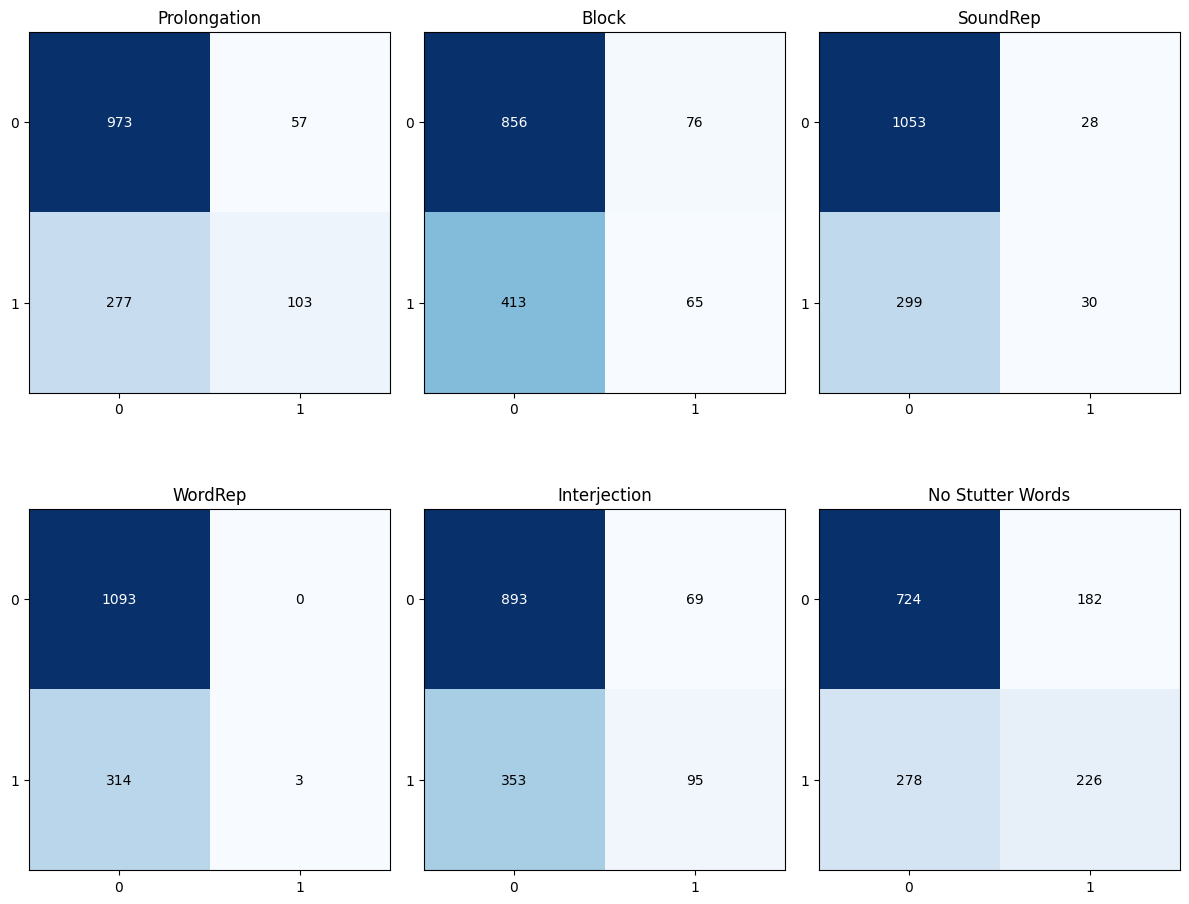

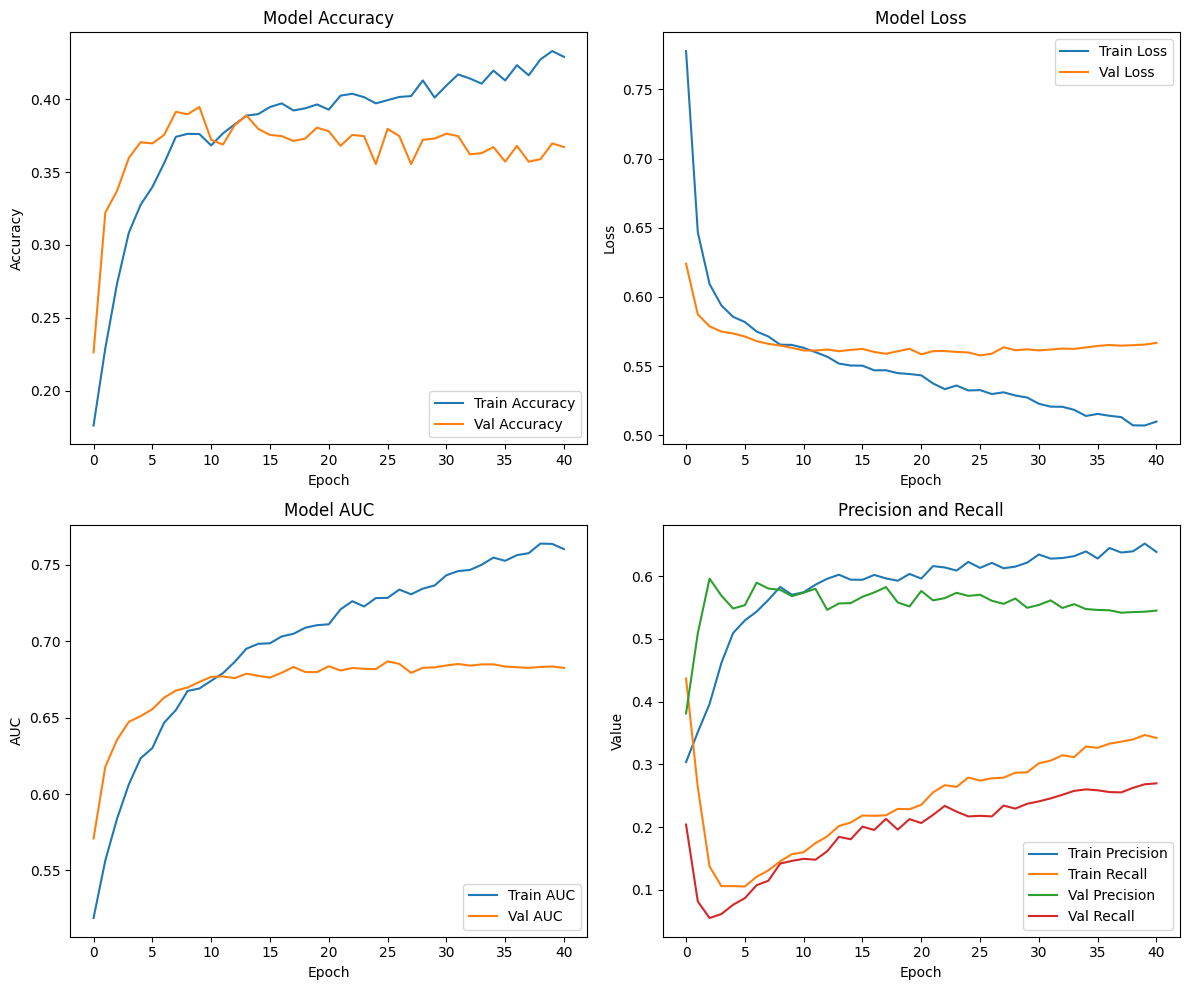

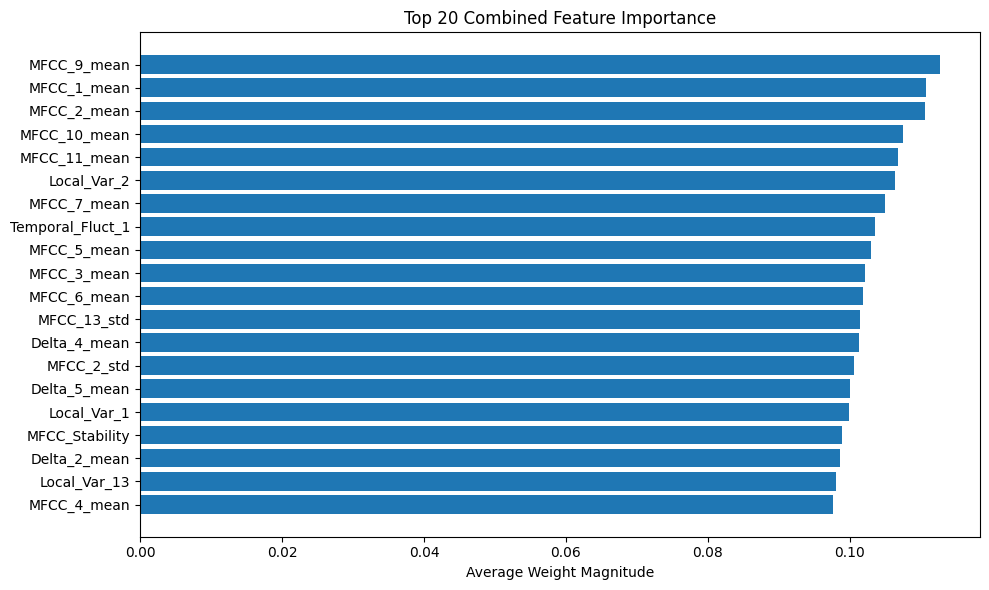


Top 10 Features:
MFCC_9_mean: 0.1127
MFCC_1_mean: 0.1108
MFCC_2_mean: 0.1106
MFCC_10_mean: 0.1075
MFCC_11_mean: 0.1068
Local_Var_2: 0.1064
MFCC_7_mean: 0.1049
Temporal_Fluct_1: 0.1035
MFCC_5_mean: 0.1030
MFCC_3_mean: 0.1021
Combined MFCC + Prosodic stutter classification pipeline completed successfully!


In [16]:
import os
import gc
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import traceback
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

############################################
# GPU and Mixed-Precision Configuration
############################################
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPU(s) available.")
    except RuntimeError as e:
        print(e)
        
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

############################################
# MFCC Feature Extraction Functions
############################################
def extract_mfcc_features(audio_path, sr=16000, n_mfcc=13, visualize=False):
    """
    Extract MFCC features with temporal dynamics and stability measures.
    This function returns a dictionary containing:
      - 'mfcc_raw': MFCC matrix (shape: [n_mfcc, T])
      - 'delta_raw': First-order derivative of the MFCCs
      - 'delta2_raw': Second-order derivative of the MFCCs
      - 'mfcc_mean': Mean of MFCC coefficients (vector, length n_mfcc)
      - 'mfcc_std': Standard deviation of MFCC coefficients
      - 'delta_mean': Mean of Delta coefficients
      - 'delta2_mean': Mean of Delta-Delta coefficients
      - 'temporal_fluctuation': Std. dev. of frame-to-frame differences (per coefficient)
      - 'local_variability': Average variance computed over a sliding window (per coefficient)
      - 'transition_rate': Average absolute change in MFCCs (normalized by dynamic range)
      - 'mfcc_stability': Mean temporal fluctuation (lower values imply higher stability)
    """
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=sr)
        # Pre-emphasis filtering
        y = librosa.effects.preemphasis(y, coef=0.97)
        # Frame parameters: 25ms window and 10ms hop
        frame_length = int(0.025 * sr)
        hop_length = int(0.010 * sr)
        
        # Extract MFCCs with liftering (lifter=22)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, n_mfcc=n_mfcc,
            n_fft=frame_length,
            hop_length=hop_length,
            lifter=22
        )
        mfcc = librosa.util.normalize(mfcc, axis=1)
        
        # Delta features
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        
        # Temporal fluctuation: standard deviation of MFCC differences over time
        temporal_fluctuation = np.std(np.diff(mfcc, axis=1), axis=1)
        
        # Local variability: average variance over a sliding window (window = 5 frames)
        local_variability = []
        for i in range(mfcc.shape[0]):
            # Use numpy's sliding_window_view (numpy>=1.20)
            rolled = np.lib.stride_tricks.sliding_window_view(mfcc[i], window_shape=5)
            local_var = np.mean(np.var(rolled, axis=1))
            local_variability.append(local_var)
        local_variability = np.array(local_variability)
        
        # Transition rate: average absolute frame-to-frame change normalized by MFCC dynamic range
        transition_rate = np.mean(np.abs(np.diff(mfcc, axis=1))) / (np.max(mfcc) - np.min(mfcc) + 1e-6)
        
        # MFCC stability: mean temporal fluctuation
        mfcc_stability = np.mean(temporal_fluctuation)
        
        features = {
            'mfcc_raw': mfcc,
            'delta_raw': delta_mfcc,
            'delta2_raw': delta2_mfcc,
            'mfcc_mean': np.mean(mfcc, axis=1),
            'mfcc_std': np.std(mfcc, axis=1),
            'delta_mean': np.mean(delta_mfcc, axis=1),
            'delta2_mean': np.mean(delta2_mfcc, axis=1),
            'temporal_fluctuation': temporal_fluctuation,
            'local_variability': local_variability,
            'transition_rate': transition_rate,
            'mfcc_stability': mfcc_stability
        }
        
        if visualize:
            plt.figure(figsize=(14, 12))
            plt.subplot(5, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title('Waveform')
            plt.subplot(5, 1, 2)
            librosa.display.specshow(mfcc, sr=sr, x_axis='time')
            plt.title('MFCC Features')
            plt.colorbar(format='%+2.0f')
            plt.subplot(5, 1, 3)
            librosa.display.specshow(delta_mfcc, sr=sr, x_axis='time')
            plt.title('Delta MFCC Features')
            plt.colorbar(format='%+2.0f')
            plt.subplot(5, 1, 4)
            plt.bar(range(len(temporal_fluctuation)), temporal_fluctuation)
            plt.title('Temporal Fluctuation per Coefficient')
            plt.xlabel('MFCC Coefficient')
            plt.ylabel('Fluctuation')
            plt.subplot(5, 1, 5)
            plt.bar([0], [mfcc_stability])
            plt.xticks([0], ['MFCC Stability'])
            plt.title('MFCC Stability')
            plt.tight_layout()
            plt.show()
        
        return features
    
    except Exception as e:
        print(f"MFCC extraction error in {audio_path}: {str(e)}")
        traceback.print_exc()
        return None

def extract_mfcc_feature_vector(audio_path, sr=16000, n_mfcc=13):
    """
    Create a flat MFCC feature vector by concatenating:
      - mfcc_mean, mfcc_std, delta_mean, delta2_mean,
      - temporal_fluctuation, local_variability,
      - transition_rate, mfcc_stability.
    For n_mfcc=13, total dimension is 6*13+2 = 80.
    """
    features = extract_mfcc_features(audio_path, sr=sr, n_mfcc=n_mfcc, visualize=False)
    if features is None:
        return None
    return np.concatenate([
        features['mfcc_mean'],
        features['mfcc_std'],
        features['delta_mean'],
        features['delta2_mean'],
        features['temporal_fluctuation'],
        features['local_variability'],
        [features['transition_rate']],
        [features['mfcc_stability']]
    ])

########################################
# Prosodic Feature Extraction Functions
########################################
def extract_prosodic_features(audio_path, sr=16000):
    """
    Extract prosodic features using robust signal processing techniques.
    Returns a dictionary with:
        f0_mean, f0_std, f0_range,
        rms_mean, rms_std,
        zcr_mean, zcr_std,
        speech_rate, jitter, shimmer, hnr_estimate
    """
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        y = librosa.effects.preemphasis(y, coef=0.97)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            f0, voiced_flag, _ = librosa.pyin(
                y, fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C7'),
                sr=sr
            )
        f0_valid = f0[~np.isnan(f0)] if np.any(~np.isnan(f0)) else np.array([0])
        f0_mean = float(np.mean(f0_valid)) if len(f0_valid) > 0 else 0
        f0_std = float(np.std(f0_valid)) if len(f0_valid) > 0 else 0
        f0_range = float(np.ptp(f0_valid)) if len(f0_valid) > 1 else 0

        rms = librosa.feature.rms(y=y)[0]
        rms_mean = float(np.mean(rms)) if len(rms) > 0 else 0
        rms_std = float(np.std(rms)) if len(rms) > 0 else 0

        zcr = librosa.feature.zero_crossing_rate(y)[0]
        zcr_mean = float(np.mean(zcr)) if len(zcr) > 0 else 0
        zcr_std = float(np.std(zcr)) if len(zcr) > 0 else 0

        onsets = librosa.onset.onset_detect(y=y, sr=sr)
        speech_rate = float(len(onsets) / (len(y)/sr)) if len(onsets) > 0 else 0

        jitter = 0.0
        if len(f0_valid) > 1 and f0_mean > 0:
            jitter = float(np.mean(np.abs(np.diff(f0_valid))) / f0_mean)
        amplitude_env = librosa.feature.rms(y=y, frame_length=256, hop_length=128)[0]
        shimmer = 0.0
        if len(amplitude_env) > 1 and np.mean(amplitude_env) > 0:
            shimmer = float(np.mean(np.abs(np.diff(amplitude_env))) / np.mean(amplitude_env))

        S = np.abs(librosa.stft(y))
        S_db = librosa.amplitude_to_db(S, ref=np.max)
        if np.any(np.isfinite(S_db)):
            hnr_estimate = float(np.mean(S_db[np.isfinite(S_db)]))
        else:
            hnr_estimate = -60.0

        features = {
            'f0_mean': f0_mean,
            'f0_std': f0_std,
            'f0_range': f0_range,
            'rms_mean': rms_mean,
            'rms_std': rms_std,
            'zcr_mean': zcr_mean,
            'zcr_std': zcr_std,
            'speech_rate': speech_rate,
            'jitter': jitter,
            'shimmer': shimmer,
            'hnr_estimate': hnr_estimate
        }
        return features
    except Exception as e:
        print(f"Error extracting prosodic features from {audio_path}: {e}")
        traceback.print_exc()
        return None

def extract_prosodic_feature_vector(audio_path, sr=16000):
    """
    Create a flat prosodic feature vector.
    Dimension: 11 (f0_mean, f0_std, f0_range, rms_mean, rms_std, zcr_mean, zcr_std, speech_rate, jitter, shimmer, hnr_estimate)
    """
    features = extract_prosodic_features(audio_path, sr=sr)
    if features is None:
        return None
    return np.array([
        features['f0_mean'],
        features['f0_std'],
        features['f0_range'],
        features['rms_mean'],
        features['rms_std'],
        features['zcr_mean'],
        features['zcr_std'],
        features['speech_rate'],
        features['jitter'],
        features['shimmer'],
        features['hnr_estimate']
    ])

########################################
# Combined Feature Vector
########################################
def extract_combined_feature_vector(audio_path, sr=16000, n_mfcc=13):
    """
    Combine MFCC and prosodic feature vectors into one.
    MFCC vector dimension: 6*n_mfcc + 2. (For n_mfcc=13, dimension = 80.)
    Prosodic vector dimension: 11.
    Total dimension: 80 + 11 = 91.
    """
    mfcc_vec = extract_mfcc_feature_vector(audio_path, sr=sr, n_mfcc=n_mfcc)
    prosody_vec = extract_prosodic_feature_vector(audio_path, sr=sr)
    if mfcc_vec is None or prosody_vec is None:
        return None
    return np.concatenate([mfcc_vec, prosody_vec])

########################################
# Batch Processing for Combined Features
########################################
def batch_process_clips(clips_df, batch_size=100, n_mfcc=13):
    """Process the clips DataFrame in batches to extract combined feature vectors and labels."""
    all_features = []
    all_labels = []
    total_batches = len(clips_df) // batch_size + (1 if len(clips_df) % batch_size > 0 else 0)
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(clips_df))
        batch_df = clips_df.iloc[start_idx:end_idx]
        print(f"Processing batch {batch_idx+1}/{total_batches} (clips {start_idx+1}-{end_idx})")
        for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx+1}"):
            feat_vector = extract_combined_feature_vector(row['file_path'], n_mfcc=n_mfcc)
            if feat_vector is not None:
                all_features.append(feat_vector)
                # Assume that label columns correspond exactly to STUTTER_TYPES order.
                all_labels.append(row[STUTTER_TYPES].values)
        gc.collect()
    
    if len(all_features) == 0:
        raise ValueError("No valid features extracted. Check your audio files and paths.")
    
    features_array = np.array(all_features)
    labels_array = np.array(all_labels, dtype=np.float32)
    print("Extracted feature array shape:", features_array.shape)
    return features_array, labels_array

########################################
# Data Preparation (Train/Val/Test Splitting)
########################################
def prepare_dataset(features_array, labels):
    """Split into train, validation, and test sets and scale the features."""
    X_temp, X_test, y_temp, y_test = train_test_split(
        features_array, labels, test_size=0.15, random_state=42, stratify=labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")
    print("Class distribution in training set:", np.sum(y_train, axis=0))
    from joblib import dump
    dump(scaler, 'combined_feature_scaler.joblib')
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

########################################
# Build DNN Model Using Combined Features
########################################
def build_dnn_model(input_shape, num_classes):
    """Build a DNN for multi-label classification on the combined feature set."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    model.summary()
    return model

########################################
# Training Pipeline
########################################
def train_pipeline(clips_df, n_mfcc=13, batch_size=100):
    """
    End-to-end training pipeline combining MFCC and prosodic features.
    It extracts combined feature vectors, splits the data, scales it,
    builds a DNN model using combined features, and trains the model.
    """
    features_array, labels = batch_process_clips(clips_df, batch_size=batch_size, n_mfcc=n_mfcc)
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_array, labels)
    
    # Build the DNN model
    model = build_dnn_model(input_shape=X_train.shape[1], num_classes=len(STUTTER_TYPES))
    
    # Define callbacks to mitigate overfitting
    callbacks_list = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
        ModelCheckpoint('best_combined_model.h5', save_best_only=True, verbose=1)
    ]
    
    # Train the model
    print("Starting model training...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)
    
    # Evaluate on test set
    y_pred = evaluate_model(model, X_test, y_test)
    
    # Plot training history
    plot_training_history(history)
    
    # Analyze feature importance from the first layer's weights
    analyze_feature_importance(model, [f"Feature_{i+1}" for i in range(X_train.shape[1])])
    
    # Save the final model
    model.save('combined_stutter_classifier.h5')
    
    return model, features_array

########################################
# Utility Functions for Training/Evaluation
########################################
def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with early stopping and LR reduction."""
    callbacks_list = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    return model, history

def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test data and plot confusion matrices."""
    print("Evaluating model on test set...")
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=STUTTER_TYPES))
    cm = multilabel_confusion_matrix(y_test, y_pred)
    fig, axes = plt.subplots(2, 3, figsize=(12, 10))
    axes = axes.flatten()
    for i in range(len(STUTTER_TYPES)):
        ax = axes[i]
        matrix = cm[i]
        im = ax.imshow(matrix, cmap=plt.cm.Blues)
        ax.set_title(STUTTER_TYPES[i])
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        thresh = matrix.max() / 2.
        for j in range(2):
            for k in range(2):
                ax.text(k, j, format(matrix[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if matrix[j, k] > thresh else "black")
    plt.tight_layout()
    plt.show()
    return y_pred

def plot_training_history(history):
    """Plot training history metrics."""
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(loc='lower right')
    plt.subplot(2, 2, 4)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['recall'], label='Train Recall')
    if 'val_precision' in history.history and 'val_recall' in history.history:
        plt.plot(history.history['val_precision'], label='Val Precision')
        plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

def analyze_feature_importance(model, feature_names):
    """Analyze feature importance using the absolute weights of the first Dense layer."""
    weights = model.layers[0].get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)
    feature_importance = list(zip(feature_names, importance))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    plt.figure(figsize=(10, 6))
    features, importance_vals = zip(*feature_importance[:20])
    plt.barh(features, importance_vals)
    plt.xlabel('Average Weight Magnitude')
    plt.title('Top 20 Combined Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print("\nTop 10 Features:")
    for feat, imp in feature_importance[:10]:
        print(f"{feat}: {imp:.4f}")
    return feature_importance

########################################
# Main Execution: Combined Feature Pipeline
########################################
if __name__ == "__main__":
    # Define stutter types for multi-label classification
    STUTTER_TYPES = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection','No Stutter Words']
    
    # Load your dataframe containing at least 'file_path' and stutter type columns.
    # clips_df = pd.read_csv('stutter_dataset.csv')
    print(f"Dataset contains {len(clips_df)} clips.")
    
    # Extract combined features for all clips using batch processing
    print("Extracting combined features (MFCC + Prosodic)...")
    features_array, labels = batch_process_clips(clips_df, batch_size=100, n_mfcc=13)
    
    # Prepare train/validation/test splits and scale features
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(features_array, labels)
    
    # Build the DNN model for combined features
    model = build_dnn_model(input_shape=X_train.shape[1], num_classes=len(STUTTER_TYPES))
    
    # Train the model using early stopping, LR reduction, and model checkpointing
    print("Training the model...")
    model, history = train_model(model, X_train, y_train, X_val, y_val)
    
    # Evaluate the trained model on the test set
    y_pred = evaluate_model(model, X_test, y_test)
    
    # Plot training history
    plot_training_history(history)
    
    # Analyze feature importance from the first Dense layer
    feature_names = []
    # Construct feature names based on the extraction order:
    for i in range(13):
        feature_names.append(f"MFCC_{i+1}_mean")
    for i in range(13):
        feature_names.append(f"MFCC_{i+1}_std")
    for i in range(13):
        feature_names.append(f"Delta_{i+1}_mean")
    for i in range(13):
        feature_names.append(f"Delta2_{i+1}_mean")
    for i in range(13):
        feature_names.append(f"Temporal_Fluct_{i+1}")
    for i in range(13):
        feature_names.append(f"Local_Var_{i+1}")
    feature_names.append("Transition_Rate")
    feature_names.append("MFCC_Stability")
    
    analyze_feature_importance(model, feature_names)
    
    # Save the final model
    model.save('combined_stutter_classifier.h5')
    
    print("Combined MFCC + Prosodic stutter classification pipeline completed successfully!")
